**Imports**

In [ ]:
import os
import numpy as np
import shutil
import pandas as pd
import nibabel as nib
import cv2
import SimpleITK as sitk
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage.filters import threshold_otsu
from scipy.ndimage import binary_fill_holes, gaussian_filter
from skimage.morphology import remove_small_objects
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage import img_as_ubyte
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef, recall_score, precision_score

**Preprocessing Steps**

**1️⃣ PNG Images  ➝  2️⃣ Stack to NIfTI  ➝  3️⃣ Gaussian Smoothing ➝  4️⃣ Skull Stripping ➝  5️⃣ Normalization ➝  6️⃣ Convert to PNG**


In [ ]:
class BrainMRIPreprocessor:
    def __init__(self, dataset_path, output_path, image_size=(128, 128)):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]

    """Stacks PNG images into a single 3D NIfTI volume."""
    def stack_images_to_nifti(self, image_folder):

        if not os.path.exists(image_folder):
            return None
        
        image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
        if not image_files:
            return None

        stacked_images = []
        for file in image_files:
            img = cv2.imread(os.path.join(image_folder, file), cv2.IMREAD_GRAYSCALE)
            stacked_images.append(img)

        stacked_array = np.stack(stacked_images, axis=-1)  # Stack along last axis (Depth)
        return nib.Nifti1Image(stacked_array.astype(np.float32), affine=np.eye(4))

    """Applies Gaussian smoothing and skull stripping using Otsu's thresholding and morphology."""
    def skull_strip(self, nifti_img):
    
        img_data = nifti_img.get_fdata()

        # Apply Gaussian Smoothing
        smoothed_data = gaussian_filter(img_data, sigma=1)

        # Compute Otsu's threshold
        threshold = threshold_otsu(smoothed_data)
        brain_mask = smoothed_data > (threshold * 0.8)

        # Fill holes in the mask and remove small objects
        brain_mask = binary_fill_holes(brain_mask)
        brain_mask = remove_small_objects(brain_mask, min_size=200)

        # Apply the mask to the image
        stripped_img = smoothed_data * brain_mask
        return nib.Nifti1Image(stripped_img, affine=nifti_img.affine)

    """Normalizes the intensity while preserving contrast, preventing division errors."""
    def normalize(self, nifti_img):
        
        img_data = nifti_img.get_fdata()

        min_val, max_val = np.percentile(img_data, (1, 99))  # Exclude extreme outliers
    
        # Fix division by zero issue
        if max_val - min_val == 0:
            norm_data = img_data  # Keep original values instead of dividing
        else:
            norm_data = np.clip((img_data - min_val) / (max_val - min_val + 1e-8), 0, 1)

        return nib.Nifti1Image(norm_data, affine=nifti_img.affine)

    """Saves the most representative slice (middle slice) as the final PNG."""
    def save_preprocessed_image(self, preprocessed_data, save_path):
        
        img_data = preprocessed_data.get_fdata()
        middle_index = img_data.shape[-1] // 2  # Select middle slice
        final_img = (img_data[:, :, middle_index] * 255).astype(np.uint8)
        cv2.imwrite(save_path, final_img)

    """Processes all MRI types for a single patient and saves output."""
    def process_patient(self, patient_path, output_patient_path):
        
        os.makedirs(output_patient_path, exist_ok=True)

        for mri_type in self.mri_types:
            input_mri_path = os.path.join(patient_path, mri_type)
            output_mri_path = os.path.join(output_patient_path, mri_type)
            os.makedirs(output_mri_path, exist_ok=True)

            nifti_img = self.stack_images_to_nifti(input_mri_path)
            if nifti_img is None:
                continue

            # Step 1: Skull Stripping (Includes Gaussian Smoothing)
            skull_stripped_nifti = self.skull_strip(nifti_img)

            # Step 2: Normalization
            normalized_nifti = self.normalize(skull_stripped_nifti)

            # Step 3: Save Final Image
            final_image_path = os.path.join(output_mri_path, "preprocessed.png")
            self.save_preprocessed_image(normalized_nifti, final_image_path)

    """Runs preprocessing on the full dataset (train + test)."""
    def run_preprocessing(self):
        
        for split in ["train", "test"]:
            split_path = os.path.join(self.dataset_path, split)
            output_split_path = os.path.join(self.output_path, split)

            patient_folders = sorted(os.listdir(split_path))
            for patient in tqdm(patient_folders, desc=f"Processing {split} set"):
                patient_path = os.path.join(split_path, patient)
                output_patient_path = os.path.join(output_split_path, patient)
                self.process_patient(patient_path, output_patient_path)

        print("Preprocessing completed for entire dataset! 🚀")

DATASET_PATH = "./brats2021"  
OUTPUT_PATH = "./output"  
# ATLAS_PATH = "./sri24_spm8/templates/T1_brain.nii"

preprocessor = BrainMRIPreprocessor(DATASET_PATH, OUTPUT_PATH)
preprocessor.run_preprocessing()

Processing test set: 100%|██████████| 87/87 [23:14<00:00, 16.03s/it]

Preprocessing completed for entire dataset! 🚀


**Split dataset in Two classes**

In [ ]:
class DatasetSorter:
    def __init__(self, dataset_path, output_path, csv_path):
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.csv_path = csv_path

    def load_patient_classes(self):
        """Reads the CSV file and returns a dictionary mapping patient IDs to their MGMT class."""
        df = pd.read_csv(self.csv_path)  # Load CSV
        df["BraTS21ID"] = df["BraTS21ID"].astype(str).str.zfill(5)
        patient_classes = dict(zip(df["BraTS21ID"], df["MGMT_value"]))
        return patient_classes

    def sort_patients(self):
        """Sorts patients into MGMT- and MGMT+ folders based on the CSV file."""
        patient_classes = self.load_patient_classes()
        mgmt_neg_path = os.path.join(self.output_path, "MGMT-")
        mgmt_pos_path = os.path.join(self.output_path, "MGMT+")
        os.makedirs(mgmt_neg_path, exist_ok=True)
        os.makedirs(mgmt_pos_path, exist_ok=True)

        for patient_id in tqdm(os.listdir(self.dataset_path), desc="Sorting patients"):
            patient_path = os.path.join(self.dataset_path, patient_id)
            if not os.path.isdir(patient_path):
                continue 
            
            if patient_id in patient_classes:
                class_label = "MGMT+" if patient_classes[patient_id] == 1 else "MGMT-"
                output_class_path = os.path.join(self.output_path, class_label) 
                shutil.copytree(patient_path, os.path.join(output_class_path, patient_id)) 

        print("✅ Dataset sorted into MGMT- and MGMT+!")


PREPROCESSED_DATASET = "./output/train"  # Path to preprocessed dataset
SORTED_OUTPUT = "./output/splitClasses"  # Where to save the sorted dataset
CSV_PATH = "./train_labels.csv" 

sorter = DatasetSorter(PREPROCESSED_DATASET, SORTED_OUTPUT, CSV_PATH)
sorter.sort_patients() 

Sorting patients: 100%|██████████| 585/585 [00:03<00:00, 166.80it/s]

✅ Dataset sorted into MGMT- and MGMT+!


**Rejection Algo**

In [ ]:
class RejectionAlgorithm:
    def __init__(self, dataset_path, output_path, pixel_sum_threshold=1000, brain_area_threshold=0.05):
        """
        dataset_path: Path to sorted dataset (MGMT- and MGMT+)
        output_path: Path to save the filtered dataset
        pixel_sum_threshold: Minimum sum of pixel values to keep an image
        brain_area_threshold: Minimum fraction of nonzero pixels (relative to total area)
        """
        self.dataset_path = dataset_path
        self.output_path = output_path
        self.pixel_sum_threshold = pixel_sum_threshold  # Reject images with very low total intensity
        self.brain_area_threshold = brain_area_threshold  # Reject images with very small visible brain area
        self.classes = ["MGMT-", "MGMT+"]  # Process both MGMT- and MGMT+ classes

    def process_class(self, class_label):
        """Processes a single class (MGMT- or MGMT+) and removes low-quality images."""
        input_class_path = os.path.join(self.dataset_path, class_label)
        output_class_path = os.path.join(self.output_path, class_label)
        os.makedirs(output_class_path, exist_ok=True)

        rejected_count = 0
        rejected_files = []

        for patient in tqdm(sorted(os.listdir(input_class_path)), desc=f"Processing {class_label}"):
            patient_path = os.path.join(input_class_path, patient)
            output_patient_path = os.path.join(output_class_path, patient)
            os.makedirs(output_patient_path, exist_ok=True)

            for mri_type in ["FLAIR", "T1w", "T1wCE", "T2w"]:
                input_mri_path = os.path.join(patient_path, mri_type)
                output_mri_path = os.path.join(output_patient_path, mri_type)
                os.makedirs(output_mri_path, exist_ok=True)

                if not os.path.exists(input_mri_path):
                    continue

                valid_images = 0  # Track number of valid images in this folder

                for img_file in sorted(os.listdir(input_mri_path)):
                    if not img_file.endswith(".png"):
                        continue

                    img_path = os.path.join(input_mri_path, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                    # Compute sum of pixel values
                    pixel_sum = np.sum(img)

                    # Compute brain area (percentage of nonzero pixels)
                    brain_area = np.count_nonzero(img) / img.size  # Fraction of nonzero pixels

                    # Check if image should be rejected
                    if pixel_sum < self.pixel_sum_threshold or brain_area < self.brain_area_threshold:
                        rejected_count += 1
                        rejected_files.append(img_path)
                    else:
                        # Copy valid image to output directory
                        output_img_path = os.path.join(output_mri_path, img_file)
                        shutil.copy2(img_path, output_img_path)
                        valid_images += 1  # Increase valid image count

                # Remove empty MRI type folder if no images remain
                if valid_images == 0:
                    shutil.rmtree(output_mri_path)

        print(f"✅ Rejection completed for {class_label}: {rejected_count} images removed.")

        # Save log of rejected images
        log_path = os.path.join(self.output_path, f"rejected_{class_label}.txt")
        with open(log_path, "w") as log_file:
            for file in rejected_files:
                log_file.write(file + "\n")

    def run_rejection(self):
        """Runs the rejection algorithm for both MGMT- and MGMT+ classes."""
        os.makedirs(self.output_path, exist_ok=True)

        for class_label in self.classes:
            self.process_class(class_label)

        print("✅ Rejection Algorithm completed for the entire dataset!")

SORTED_DATASET = "./output/splitClasses" 
FILTERED_OUTPUT = "./output/filtered_dataset"  

rejection = RejectionAlgorithm(SORTED_DATASET, FILTERED_OUTPUT)
rejection.run_rejection() 


Processing MGMT-:   0%|          | 0/278 [00:00<?, ?it/s]

Processing MGMT-: 100%|██████████| 278/278 [00:03<00:00, 72.82it/s] 


✅ Rejection completed for MGMT-: 283 images removed.


Processing MGMT+: 100%|██████████| 307/307 [00:04<00:00, 73.84it/s] 

✅ Rejection completed for MGMT+: 301 images removed.
✅ Rejection Algorithm completed for the entire dataset!


**GLCM feature extraction module**

In [ ]:
class GLCMExtractor:
    def __init__(self, preprocessed_path, output_file_path, image_size=(128, 128), 
                 distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256):
        """
        Initializes the GLCM extractor with:
        - preprocessed_path: Path to MRI images
        - output_file_path: Single .npz file for output
        - image_size: Input image size (default: 128x128)
        - distances: List of pixel distances (default: [1])
        - angles: List of angles in radians (0°, 45°, 90°, 135°)
        - levels: Number of gray levels (default: 256)
        """
        self.preprocessed_path = preprocessed_path
        self.output_file_path = output_file_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
        self.distances = distances
        self.angles = angles
        self.levels = levels
        self.properties = ['energy', 'contrast', 'correlation', 'homogeneity'] 

    def compute_glcm(self, image):
        """Computes GLCM for an image using scikit-image."""
        # Convert to 8-bit integer for graycomatrix
        gray_img = img_as_ubyte(image)
        # Compute GLCM for multiple distances and angles
        glcm = graycomatrix(gray_img, distances=self.distances, angles=self.angles, 
                            levels=self.levels, symmetric=True, normed=True)
        return glcm  # Shape: (levels, levels, n_distances, n_angles)

    def compute_features(self, glcm):
        """Computes Haralick-like features, averaging over distances and angles."""
        features = []
        # scikit-image properties
        for prop in self.properties:
            feat = graycoprops(glcm, prop)  # Shape: (n_distances, n_angles)
            features.append(feat.ravel())   # Flatten to 1D

        # Stack basic features (energy, contrast, correlation, homogeneity)
        basic_features = np.concatenate(features)  # Shape: (4 * n_distances * n_angles)

        # Additional Haralick features (computed manually)
        px = np.sum(glcm, axis=1)  # Row probabilities
        py = np.sum(glcm, axis=0)  # Column probabilities
        mean_x = np.sum(np.arange(self.levels)[:, None, None] * px, axis=0)
        mean_y = np.sum(np.arange(self.levels)[None, :, None] * py, axis=1)
        std_x = np.sqrt(np.sum(((np.arange(self.levels)[:, None, None] - mean_x) ** 2) * px, axis=0))
        std_y = np.sqrt(np.sum(((np.arange(self.levels)[None, :, None] - mean_y) ** 2) * py, axis=1))

        # Compute for each distance-angle pair
        extra_features = []
        for d in range(len(self.distances)):
            for a in range(len(self.angles)):
                g = glcm[:, :, d, a]
                px_g = px[:, d, a]
                py_g = py[:, d, a]
                mx = mean_x[d, a]
                my = mean_y[d, a]
                sx = std_x[d, a]
                sy = std_y[d, a]

                # Sum Average
                sum_avg = np.sum((np.arange(self.levels) + 1) * px_g)
                # Sum Variance
                sum_var = np.sum(((np.arange(self.levels) + 1 - sum_avg) ** 2) * px_g)
                # Sum Entropy
                sum_entropy = -np.sum(px_g * np.log2(px_g + 1e-8))
                # Entropy
                entropy = -np.sum(g * np.log2(g + 1e-8))
                # Difference Variance (simplified)
                diff_var = np.sum((np.arange(self.levels) ** 2) * px_g)
                # Difference Entropy
                diff_entropy = -np.sum(px_g * np.log2(px_g + 1e-8))
                # Information Measures (simplified)
                hxy = entropy
                hxy1 = -np.sum(g * np.log2(px_g[:, None] * py_g[None, :] + 1e-8))
                hxy2 = -np.sum(px_g[:, None] * py_g[None, :] * np.log2(px_g[:, None] * py_g[None, :] + 1e-8))
                imc1 = (hxy - hxy1) / (hxy + 1e-8)
                imc2 = np.sqrt(1 - np.exp(-2 * (hxy2 - hxy)))

                extra_features.append([sum_avg, sum_var, sum_entropy, entropy, diff_var, diff_entropy, imc1, imc2])

        extra_features = np.mean(extra_features, axis=0)  # Average over directions
        return np.concatenate([basic_features, extra_features])  # Total: 4*4 + 8 = 24 features

    def load_and_process_image(self, patient_path, mri_type):
        """Loads and processes a single MRI image."""
        img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != self.image_size:
                img = cv2.resize(img, self.image_size)
            return img.astype(np.float32) / 255.0
        else:
            # print(f"Warning: Missing {img_path}, using zero image")
            return np.zeros(self.image_size, dtype=np.float32)

    def process_patient(self, patient_path, label):
        """Processes a single patient and returns GLCM features."""
        try:
            patient_features = []
            for mri_type in self.mri_types:
                img = self.load_and_process_image(patient_path, mri_type)
                glcm = self.compute_glcm(img)
                glcm_feats = self.compute_features(glcm)
                patient_features.append(glcm_feats)
            
            # Stack features: 4 modalities * 24 features = 96 features
            combined_features = np.concatenate(patient_features)
            patient_id = os.path.basename(patient_path)
            return {'patient_id': patient_id, 'features': combined_features, 'label': label}
        except Exception as e:
            print(f"Error processing {patient_path}: {e}")
            return None

    def run_extraction(self):
        """Runs GLCM feature extraction and saves to a single .npz file."""
        all_data = []
        for mgmt_status in ["MGMT-", "MGMT+"]:
            mgmt_path = os.path.join(self.preprocessed_path, mgmt_status)
            label = 0 if mgmt_status == "MGMT-" else 1

            if not os.path.exists(mgmt_path):
                print(f"Skipping {mgmt_status}: directory not found.")
                continue

            patient_folders = sorted(os.listdir(mgmt_path))
            for patient in tqdm(patient_folders, desc=f"Extracting GLCM for {mgmt_status}"):
                patient_path = os.path.join(mgmt_path, patient)
                patient_data = self.process_patient(patient_path, label)
                if patient_data is not None:
                    all_data.append(patient_data)

        patient_ids = np.array([data['patient_id'] for data in all_data])
        features = np.array([data['features'] for data in all_data])  # Shape: (n_patients, 96)
        labels = np.array([data['label'] for data in all_data])
        np.savez(self.output_file_path, patient_ids=patient_ids, features=features, labels=labels)
        print(f"GLCM feature extraction completed! Saved to {self.output_file_path}")


PREPROCESSED_PATH = "./output/filtered_dataset" 
OUTPUT_FILE_PATH = "./output/features/glcm_features.npz"
extractor = GLCMExtractor(PREPROCESSED_PATH, OUTPUT_FILE_PATH)
extractor.run_extraction()

Extracting GLCM for MGMT+: 100%|██████████| 307/307 [00:52<00:00,  5.79it/s]


GLCM feature extraction completed! Saved to ./output/features/glcm_features.npz 🚀


In [37]:
def check_glcm_features(npz_file_path, patient_id):
    data = np.load(npz_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels']
    
    try:
        idx = np.where(patient_ids == patient_id)[0][0]
        print(f"Patient: {patient_id}")
        print(f"GLCM Features Shape: {features[idx].shape}")  # Should be (96,)
        print(f"GLCM Features (first 10): {features[idx][:10]}")  # Sample
        print(f"Label: {labels[idx]}")
    except IndexError:
        print(f"Patient {patient_id} not found.")

NPZ_FILE_PATH = "./output/features/glcm_features.npz"
PATIENT_ID = "00000"  
check_glcm_features(NPZ_FILE_PATH, PATIENT_ID)

Patient: 00000
GLCM Features Shape: (96,)
GLCM Features (first 10): [  0.85692088   0.8534998    0.85661329   0.85362326 190.19082185
 318.87717775 211.3058563  325.90526381   0.9634317    0.93909864]
Label: 1


***HOG features***

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

class HOGExtractor:
    def __init__(self, preprocessed_path, output_file_path, image_size=(128, 128), 
                 cell_size=(8, 8), block_size=(2, 2), bins=9, epsilon=1e-8):
        self.preprocessed_path = preprocessed_path
        self.output_file_path = output_file_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
        self.cell_size = cell_size
        self.block_size = block_size
        self.bins = bins
        self.epsilon = epsilon

    def compute_gradients(self, image):
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = image.astype(np.float32)  # Keep original range [0, 255]
        
        Ex = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        Ey = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        
        magnitude = np.sqrt(Ex ** 2 + Ey ** 2)
        angle = np.arctan2(Ey, Ex) * (180 / np.pi)
        angle[angle < 0] += 180
        
        max_mag = np.max(magnitude)
        # print(f"Gradient Magnitude - Min: {magnitude.min()}, Max: {max_mag}, Mean: {magnitude.mean()}")  # Debug
        if max_mag > 0:
            magnitude /= max_mag
        else:
            print("Warning: No gradients detected (max magnitude = 0)")
        
        return magnitude, angle

    def compute_histograms(self, magnitude, angle):
        h, w = magnitude.shape
        cell_h, cell_w = self.cell_size
        cells_x, cells_y = w // cell_w, h // cell_h
        histograms = np.zeros((cells_y, cells_x, self.bins))

        bin_size = 180 / self.bins
        for i in range(cells_y):
            for j in range(cells_x):
                cell_mag = magnitude[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
                cell_ang = angle[i * cell_h:(i + 1) * cell_h, j * cell_w:(j + 1) * cell_w]
                hist, _ = np.histogram(cell_ang, bins=self.bins, range=(0, 180), weights=cell_mag)
                histograms[i, j] = hist
        
        # print(f"Histograms - Min: {histograms.min()}, Max: {histograms.max()}, Mean: {histograms.mean()}")  # Debug
        return histograms

    def normalize_blocks(self, histograms):
        cells_y, cells_x, bins = histograms.shape
        block_h, block_w = self.block_size
        normalized_hog = []

        for i in range(cells_y - block_h + 1):
            for j in range(cells_x - block_w + 1):
                block = histograms[i:i + block_h, j:j + block_w].flatten()
                norm_factor = np.sum(block) + self.epsilon
                normalized_block = np.sqrt(block / norm_factor)
                normalized_hog.extend(normalized_block)

        hog_descriptor = np.array(normalized_hog)
        # print(f"HOG Descriptor - Min: {hog_descriptor.min()}, Max: {hog_descriptor.max()}, Mean: {hog_descriptor.mean()}")  # Debug
        return hog_descriptor

    def extract_features(self, image):
        magnitude, angle = self.compute_gradients(image)
        histograms = self.compute_histograms(magnitude, angle)
        hog_descriptor = self.normalize_blocks(histograms)
        if np.all(hog_descriptor == 0):
            print("Warning: HOG features are all zeros")
        return hog_descriptor

    def load_and_process_image(self, patient_path, mri_type):
        img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != self.image_size:
                img = cv2.resize(img, self.image_size)
            if img.max() == 0:
                print(f"Skipping {img_path}: Image is all zeros")
                return None
            # print(f"Loaded {img_path} - Min: {img.min()}, Max: {img.max()}, Mean: {img.mean()}")  # Debug
            return img
        else:
            print(f"Skipping {img_path}: Missing modality")
            return None

    def process_patient(self, patient_path, label):
        try:
            patient_features = []
            for mri_type in self.mri_types:
                img = self.load_and_process_image(patient_path, mri_type)
                if img is None:
                    return None
                hog_feats = self.extract_features(img)
                patient_features.append(hog_feats)
            
            combined_features = np.concatenate(patient_features)
            patient_id = os.path.basename(patient_path)
            return {'patient_id': patient_id, 'features': combined_features, 'label': label}
        except Exception as e:
            print(f"Error processing {patient_path}: {e}")
            return None

    def run_extraction(self):
        all_data = []
        for mgmt_status in ["MGMT-", "MGMT+"]:
            mgmt_path = os.path.join(self.preprocessed_path, mgmt_status)
            label = 0 if mgmt_status == "MGMT-" else 1

            if not os.path.exists(mgmt_path):
                print(f"Skipping {mgmt_status}: directory not found.")
                continue

            patient_folders = sorted(os.listdir(mgmt_path))
            for patient in tqdm(patient_folders, desc=f"Extracting HOG for {mgmt_status}"):
                patient_path = os.path.join(mgmt_path, patient)
                patient_data = self.process_patient(patient_path, label)
                if patient_data is not None:
                    all_data.append(patient_data)

        patient_ids = np.array([data['patient_id'] for data in all_data])
        features = np.array([data['features'] for data in all_data])
        labels = np.array([data['label'] for data in all_data])
        np.savez(self.output_file_path, patient_ids=patient_ids, features=features, labels=labels)
        print(f"HOG feature extraction completed! Saved to {self.output_file_path}")

# Usage
PREPROCESSED_PATH = "./output/filtered_dataset"
OUTPUT_FILE_PATH = "./output/features/hog_features.npz"
extractor = HOGExtractor(PREPROCESSED_PATH, OUTPUT_FILE_PATH)
extractor.run_extraction()

Extracting HOG for MGMT-:   0%|          | 1/278 [00:00<00:29,  9.52it/s]

Loaded ./output/filtered_dataset\MGMT-\00003\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 32.1160888671875
Gradient Magnitude - Min: 0.0, Max: 740.780669294225, Mean: 35.7566455212789
Histograms - Min: 0.0, Max: 21.043339297004554, Mean: 0.3432452948653232
HOG Descriptor - Min: 0.0, Max: 0.9999999532408688, Mean: 0.05130933253098606
Loaded ./output/filtered_dataset\MGMT-\00003\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 47.93719482421875
Gradient Magnitude - Min: 0.0, Max: 691.7832030340142, Mean: 31.554417435506277
Histograms - Min: 0.0, Max: 13.760848695817154, Mean: 0.3243602438540764
HOG Descriptor - Min: 0.0, Max: 0.999999858768465, Mean: 0.058227208270304774
Loaded ./output/filtered_dataset\MGMT-\00003\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 45.81451416015625
Gradient Magnitude - Min: 0.0, Max: 750.4731840645607, Mean: 35.65881506374881
Histograms - Min: 0.0, Max: 15.242456258665065, Mean: 0.3378852188102518
HOG Descriptor - Min: 0.0, Max: 0.9999999992901949, Mean

Extracting HOG for MGMT-:   1%|          | 3/278 [00:00<00:23, 11.49it/s]

Histograms - Min: 0.0, Max: 14.460145708653458, Mean: 0.32834244280876024
HOG Descriptor - Min: 0.0, Max: 0.9999999887355391, Mean: 0.05722666817165036
Loaded ./output/filtered_dataset\MGMT-\00017\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 42.4813232421875
Gradient Magnitude - Min: 0.0, Max: 779.1918890748286, Mean: 43.91662353360206
Histograms - Min: 0.0, Max: 12.867149016969817, Mean: 0.40079471302388053
HOG Descriptor - Min: 0.0, Max: 0.9999999947413262, Mean: 0.05949515454241813
Loaded ./output/filtered_dataset\MGMT-\00017\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 26.11785888671875
Gradient Magnitude - Min: 0.0, Max: 782.4129344534125, Mean: 39.99569034622142
Histograms - Min: 0.0, Max: 12.716199969655996, Mean: 0.363508558580085
HOG Descriptor - Min: 0.0, Max: 0.9999997233753689, Mean: 0.04617631521662091
Loaded ./output/filtered_dataset\MGMT-\00018\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 40.52264404296875
Gradient Magnitude - Min: 0.0, Max: 791.4000252716701, 

Extracting HOG for MGMT-:   3%|▎         | 7/278 [00:00<00:24, 11.15it/s]

Histograms - Min: 0.0, Max: 17.942666609955623, Mean: 0.34492499494493867
HOG Descriptor - Min: 0.0, Max: 0.9999999988698544, Mean: 0.04948729303297417
Loaded ./output/filtered_dataset\MGMT-\00019\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 26.7886962890625
Gradient Magnitude - Min: 0.0, Max: 764.920910944393, Mean: 27.151653289102946
Histograms - Min: 0.0, Max: 8.590382591788664, Mean: 0.2524161918266771
HOG Descriptor - Min: 0.0, Max: 0.9999993238997317, Mean: 0.044857620398844784
Loaded ./output/filtered_dataset\MGMT-\00021\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 43.2857666015625
Gradient Magnitude - Min: 0.0, Max: 756.9015788066504, Mean: 36.57802744048213
Histograms - Min: 0.0, Max: 17.965014604448037, Mean: 0.3436515719317643
HOG Descriptor - Min: 0.0, Max: 0.9999996177071914, Mean: 0.047003379824487844
Loaded ./output/filtered_dataset\MGMT-\00021\T1w\preprocessed.png - Min: 0, Max: 216, Mean: 31.44488525390625
Gradient Magnitude - Min: 0.0, Max: 586.1689176338166, Me

Extracting HOG for MGMT-:   3%|▎         | 9/278 [00:00<00:24, 11.02it/s]

Loaded ./output/filtered_dataset\MGMT-\00024\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 42.03936767578125
Gradient Magnitude - Min: 0.0, Max: 767.1258045457733, Mean: 42.91318109442305
Histograms - Min: 0.0, Max: 14.299858815835135, Mean: 0.3977970719866021
HOG Descriptor - Min: 0.0, Max: 0.9999999509079862, Mean: 0.052621003880963
Loaded ./output/filtered_dataset\MGMT-\00024\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 56.22747802734375
Gradient Magnitude - Min: 0.0, Max: 634.5344750287411, Mean: 35.77558397351941
Histograms - Min: 0.0, Max: 18.38877785960656, Mean: 0.40093038709844614
HOG Descriptor - Min: 0.0, Max: 0.9999999930235086, Mean: 0.05627601949312405
Loaded ./output/filtered_dataset\MGMT-\00024\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 43.85601806640625
Gradient Magnitude - Min: 0.0, Max: 795.0371060522899, Mean: 39.141807927122464
Histograms - Min: 0.0, Max: 19.963263908391205, Mean: 0.3500990622206642
HOG Descriptor - Min: 0.0, Max: 0.9999998246848408, Mea

Extracting HOG for MGMT-:   4%|▍         | 12/278 [00:00<00:20, 12.90it/s]

Histograms - Min: 0.0, Max: 16.19560677102706, Mean: 0.3149623241313181
HOG Descriptor - Min: 0.0, Max: 0.9999999942343961, Mean: 0.05547801558503691
Loaded ./output/filtered_dataset\MGMT-\00032\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 40.46466064453125
Gradient Magnitude - Min: 0.0, Max: 748.7295907068185, Mean: 31.345642665048317
Histograms - Min: 0.0, Max: 13.511001327220347, Mean: 0.29770741080223434
HOG Descriptor - Min: 0.0, Max: 0.999999997737024, Mean: 0.05308092040699066
Loaded ./output/filtered_dataset\MGMT-\00032\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 26.32281494140625
Gradient Magnitude - Min: 0.0, Max: 777.829030057377, Mean: 35.4243302169787
Histograms - Min: 0.0, Max: 11.713090611731944, Mean: 0.3238582496606539
HOG Descriptor - Min: 0.0, Max: 0.9999998170989144, Mean: 0.05678874499685511
Skipping ./output/filtered_dataset\MGMT-\00036\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00044\FLAIR\preprocessed.png - Min: 0, Max

Extracting HOG for MGMT-:   5%|▌         | 15/278 [00:01<00:18, 14.33it/s]

Gradient Magnitude - Min: 0.0, Max: 654.988549518234, Mean: 39.84959965438935
Histograms - Min: 0.0, Max: 18.609741665454404, Mean: 0.43264104553291716
HOG Descriptor - Min: 0.0, Max: 0.9999999964774064, Mean: 0.06947524100005877
Loaded ./output/filtered_dataset\MGMT-\00053\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 35.8829345703125
Gradient Magnitude - Min: 0.0, Max: 718.7224777339303, Mean: 29.604177205710357
Histograms - Min: 0.0, Max: 15.563472528606512, Mean: 0.29290665032012925
HOG Descriptor - Min: 0.0, Max: 0.9999999991963615, Mean: 0.0580705332903729
Loaded ./output/filtered_dataset\MGMT-\00053\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 33.9144287109375
Gradient Magnitude - Min: 0.0, Max: 732.0382503667414, Mean: 34.15601227384785
Histograms - Min: 0.0, Max: 9.202515596724991, Mean: 0.33179577470183247
HOG Descriptor - Min: 0.0, Max: 0.9999999368985345, Mean: 0.07235594870684119
Loaded ./output/filtered_dataset\MGMT-\00053\T2w\preprocessed.png - Min: 0, Max: 255, Mea

Extracting HOG for MGMT-:   6%|▋         | 18/278 [00:01<00:17, 15.10it/s]

Gradient Magnitude - Min: 0.0, Max: 523.6506469011568, Mean: 23.58554109528662
Histograms - Min: 0.0, Max: 12.124198515872504, Mean: 0.32028873512672035
HOG Descriptor - Min: 0.0, Max: 0.9999998595344094, Mean: 0.057412415013071316
Loaded ./output/filtered_dataset\MGMT-\00072\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 48.51092529296875
Gradient Magnitude - Min: 0.0, Max: 773.5179377364174, Mean: 39.27355307644362
Histograms - Min: 0.0, Max: 19.481587813998473, Mean: 0.3610499330784449
HOG Descriptor - Min: 0.0, Max: 0.9999999827698548, Mean: 0.05361739996922233
Loaded ./output/filtered_dataset\MGMT-\00072\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 29.27117919921875
Gradient Magnitude - Min: 0.0, Max: 791.3545349588893, Mean: 35.36882588987613
Histograms - Min: 0.0, Max: 14.216328159161723, Mean: 0.3178242363715253
HOG Descriptor - Min: 0.0, Max: 0.9999998753131075, Mean: 0.05624373844663962
Loaded ./output/filtered_dataset\MGMT-\00081\FLAIR\preprocessed.png - Min: 0, Max: 255

Extracting HOG for MGMT-:   8%|▊         | 23/278 [00:01<00:16, 15.07it/s]

Loaded ./output/filtered_dataset\MGMT-\00084\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 26.4786376953125
Gradient Magnitude - Min: 0.0, Max: 786.3078277621303, Mean: 32.02188315381487
Histograms - Min: 0.0, Max: 12.269786205520235, Mean: 0.28959544984039076
HOG Descriptor - Min: 0.0, Max: 0.999999998542779, Mean: 0.049742815446481244
Loaded ./output/filtered_dataset\MGMT-\00088\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 32.59979248046875
Gradient Magnitude - Min: 0.0, Max: 714.7041345899714, Mean: 34.072266661723866
Histograms - Min: 0.0, Max: 14.884846540215525, Mean: 0.33900975566334024
HOG Descriptor - Min: 0.0, Max: 0.9999999993981344, Mean: 0.04383048191946913
Loaded ./output/filtered_dataset\MGMT-\00088\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 28.4873046875
Gradient Magnitude - Min: 0.0, Max: 545.6244129435559, Mean: 24.781816605467483
Histograms - Min: 0.0, Max: 14.956065716928036, Mean: 0.32298087702114614
HOG Descriptor - Min: 0.0, Max: 0.9999996784878864, Mean

Extracting HOG for MGMT-:   9%|▉         | 26/278 [00:01<00:15, 15.86it/s]

Loaded ./output/filtered_dataset\MGMT-\00097\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 38.68927001953125
Gradient Magnitude - Min: 0.0, Max: 650.8102642091626, Mean: 39.72239531083318
Histograms - Min: 0.0, Max: 17.312673555542972, Mean: 0.43402875183300904
HOG Descriptor - Min: 0.0, Max: 0.9536775477122563, Mean: 0.05987638251951128
Loaded ./output/filtered_dataset\MGMT-\00097\T1w\preprocessed.png - Min: 0, Max: 230, Mean: 48.17059326171875
Gradient Magnitude - Min: 0.0, Max: 659.4740328473897, Mean: 30.100104996555018
Histograms - Min: 0.0, Max: 13.8529702144861, Mean: 0.32456955152947786
HOG Descriptor - Min: 0.0, Max: 0.999999222803305, Mean: 0.050217564557222025
Loaded ./output/filtered_dataset\MGMT-\00097\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 39.39892578125
Gradient Magnitude - Min: 0.0, Max: 751.511809621113, Mean: 33.64437767221431
Histograms - Min: 0.0, Max: 13.852943702123879, Mean: 0.31835681732256876
HOG Descriptor - Min: 0.0, Max: 0.9999999904480161, Mean

Extracting HOG for MGMT-:  10%|█         | 28/278 [00:02<00:17, 14.62it/s]

HOG Descriptor - Min: 0.0, Max: 0.9768733861297199, Mean: 0.03239293554971332
Loaded ./output/filtered_dataset\MGMT-\00104\T1wCE\preprocessed.png - Min: 0, Max: 254, Mean: 17.99432373046875
Gradient Magnitude - Min: 0.0, Max: 604.0827757849084, Mean: 15.041343134125118
Histograms - Min: 0.0, Max: 10.154702623061459, Mean: 0.17706292345139912
HOG Descriptor - Min: 0.0, Max: 0.9999999958288776, Mean: 0.0320012775463994
Loaded ./output/filtered_dataset\MGMT-\00104\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 18.0426025390625
Gradient Magnitude - Min: 0.0, Max: 580.9044671888829, Mean: 21.325125703331544
Histograms - Min: 0.0, Max: 10.413057000144706, Mean: 0.26105039107143607
HOG Descriptor - Min: 0.0, Max: 0.9753143231105231, Mean: 0.038501185779986465
Loaded ./output/filtered_dataset\MGMT-\00108\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 67.54339599609375
Gradient Magnitude - Min: 0.0, Max: 627.7403922004701, Mean: 47.37660167370534
Histograms - Min: 0.0, Max: 20.129181963540695

Extracting HOG for MGMT-:  11%|█         | 30/278 [00:02<00:18, 13.55it/s]

HOG Descriptor - Min: 0.0, Max: 0.9999999283376796, Mean: 0.03908346363662881
Loaded ./output/filtered_dataset\MGMT-\00111\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 22.34954833984375
Gradient Magnitude - Min: 0.0, Max: 612.1601097752123, Mean: 26.8196211191313
Histograms - Min: 0.0, Max: 21.47391310765901, Mean: 0.3115480781752946
HOG Descriptor - Min: 0.0, Max: 0.9999999995236194, Mean: 0.034035690330351136
Loaded ./output/filtered_dataset\MGMT-\00111\T1w\preprocessed.png - Min: 0, Max: 254, Mean: 18.2996826171875
Gradient Magnitude - Min: 0.0, Max: 485.7324366356441, Mean: 20.03840520594802
Histograms - Min: 0.0, Max: 24.872642750409224, Mean: 0.29336176701711975
HOG Descriptor - Min: 0.0, Max: 0.9999999874163839, Mean: 0.026540017651004118
Loaded ./output/filtered_dataset\MGMT-\00111\T1wCE\preprocessed.png - Min: 0, Max: 247, Mean: 10.3111572265625
Gradient Magnitude - Min: 0.0, Max: 644.9217006738105, Mean: 15.020669744543042
Histograms - Min: 0.0, Max: 18.79767668824416, Me

Extracting HOG for MGMT-:  12%|█▏        | 32/278 [00:02<00:18, 12.99it/s]

Histograms - Min: 0.0, Max: 21.601066703111563, Mean: 0.5081423964848465
HOG Descriptor - Min: 0.0, Max: 0.9999999995844665, Mean: 0.0778660453241193
Loaded ./output/filtered_dataset\MGMT-\00113\T1wCE\preprocessed.png - Min: 0, Max: 253, Mean: 65.97039794921875
Gradient Magnitude - Min: 0.0, Max: 441.80765045435777, Mean: 28.646603370829876
Histograms - Min: 0.0, Max: 21.854484013645315, Mean: 0.4610811499447906
HOG Descriptor - Min: 0.0, Max: 0.9999999660838463, Mean: 0.07533435264916742
Loaded ./output/filtered_dataset\MGMT-\00113\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 25.9818115234375
Gradient Magnitude - Min: 0.0, Max: 517.3490117899134, Mean: 34.40348886066229
Histograms - Min: 0.0, Max: 11.661947480599396, Mean: 0.4728858591062506
HOG Descriptor - Min: 0.0, Max: 0.9152025552096225, Mean: 0.057119748903670754
Loaded ./output/filtered_dataset\MGMT-\00116\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 37.62109375
Gradient Magnitude - Min: 0.0, Max: 542.5587525789258, Mean:

Extracting HOG for MGMT-:  14%|█▍        | 39/278 [00:02<00:14, 16.71it/s]

Loaded ./output/filtered_dataset\MGMT-\00122\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 48.756591796875
Gradient Magnitude - Min: 0.0, Max: 578.3165223301164, Mean: 35.63304224234783
Histograms - Min: 0.0, Max: 20.857371069678614, Mean: 0.438151968391472
HOG Descriptor - Min: 0.0, Max: 0.999999995716695, Mean: 0.057074788602169545
Loaded ./output/filtered_dataset\MGMT-\00122\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 60.47943115234375
Gradient Magnitude - Min: 0.0, Max: 689.8840482283962, Mean: 41.81852660281007
Histograms - Min: 0.0, Max: 20.709064459685464, Mean: 0.4310524209672515
HOG Descriptor - Min: 0.0, Max: 0.9999999982160963, Mean: 0.05683670080383829
Loaded ./output/filtered_dataset\MGMT-\00122\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 52.88763427734375
Gradient Magnitude - Min: 0.0, Max: 591.4118700195321, Mean: 33.97576399808406
Histograms - Min: 0.0, Max: 21.175686637925974, Mean: 0.4085231378045982
HOG Descriptor - Min: 0.0, Max: 0.9999999982411465, Mean:

Extracting HOG for MGMT-:  15%|█▍        | 41/278 [00:02<00:15, 15.04it/s]

Loaded ./output/filtered_dataset\MGMT-\00133\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 59.5762939453125
Gradient Magnitude - Min: 0.0, Max: 755.2443313259623, Mean: 52.79471091896499
Histograms - Min: 0.0, Max: 13.876929320744548, Mean: 0.4970961579607227
HOG Descriptor - Min: 0.0, Max: 0.9999999975768764, Mean: 0.06281303670420603
Loaded ./output/filtered_dataset\MGMT-\00133\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 55.47882080078125
Gradient Magnitude - Min: 0.0, Max: 632.5266792792222, Mean: 50.8486998707035
Histograms - Min: 0.0, Max: 15.515126963041103, Mean: 0.5716608745233549
HOG Descriptor - Min: 0.0, Max: 0.9999999979104424, Mean: 0.06207718389734956
Loaded ./output/filtered_dataset\MGMT-\00133\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 39.2955322265625
Gradient Magnitude - Min: 0.0, Max: 529.4317708638196, Mean: 39.3030611337635
Histograms - Min: 0.0, Max: 16.971281229377578, Mean: 0.5279026498031507
HOG Descriptor - Min: 0.0, Max: 0.9999999382868778, Mean: 

Extracting HOG for MGMT-:  15%|█▌        | 43/278 [00:03<00:16, 13.89it/s]

Loaded ./output/filtered_dataset\MGMT-\00142\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 57.6871337890625
Gradient Magnitude - Min: 0.0, Max: 624.8199740725323, Mean: 48.61653787053497
Histograms - Min: 0.0, Max: 15.808051349387823, Mean: 0.5533075397406912
HOG Descriptor - Min: 0.0, Max: 0.9999988954657283, Mean: 0.06552768688379391
Loaded ./output/filtered_dataset\MGMT-\00142\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 45.75750732421875
Gradient Magnitude - Min: 0.0, Max: 722.8388478768971, Mean: 39.94586298171572
Histograms - Min: 0.0, Max: 12.967985717120984, Mean: 0.3929775923451438
HOG Descriptor - Min: 0.0, Max: 0.9999996349114492, Mean: 0.05687861122051135
Loaded ./output/filtered_dataset\MGMT-\00147\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 40.4755859375
Gradient Magnitude - Min: 0.0, Max: 651.6087783325206, Mean: 32.4379443517784
Histograms - Min: 0.0, Max: 14.770498403059806, Mean: 0.35400048951431223
HOG Descriptor - Min: 0.0, Max: 0.9999999959791263, Mean: 0

Extracting HOG for MGMT-:  16%|█▌        | 45/278 [00:03<00:17, 13.21it/s]

Histograms - Min: 0.0, Max: 18.44717319450972, Mean: 0.35873147203782246
HOG Descriptor - Min: 0.0, Max: 0.9999999106713048, Mean: 0.05541671763616714
Loaded ./output/filtered_dataset\MGMT-\00149\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 59.18133544921875
Gradient Magnitude - Min: 0.0, Max: 519.0472040190565, Mean: 40.95655793802772
Histograms - Min: 0.0, Max: 21.953179571088718, Mean: 0.5611178173599833
HOG Descriptor - Min: 0.0, Max: 0.9999999885032811, Mean: 0.07194065611651125
Loaded ./output/filtered_dataset\MGMT-\00149\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 79.29693603515625
Gradient Magnitude - Min: 0.0, Max: 539.1567490071881, Mean: 44.3653435226682
Histograms - Min: 0.0, Max: 21.460044554733557, Mean: 0.5851487305931897
HOG Descriptor - Min: 0.0, Max: 0.9999999592416466, Mean: 0.0699151355500579
Loaded ./output/filtered_dataset\MGMT-\00149\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 73.3931884765625
Gradient Magnitude - Min: 0.0, Max: 526.4465784863646, Mea

Extracting HOG for MGMT-:  18%|█▊        | 49/278 [00:03<00:18, 12.52it/s]

Histograms - Min: 0.0, Max: 20.549888765407875, Mean: 0.3715317756082086
HOG Descriptor - Min: 0.0, Max: 0.9999986780343919, Mean: 0.043561432346299556
Loaded ./output/filtered_dataset\MGMT-\00151\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 56.70904541015625
Gradient Magnitude - Min: 0.0, Max: 470.6846077789245, Mean: 28.911354884636935
Histograms - Min: 0.0, Max: 30.31982088875682, Mean: 0.4367932444775897
HOG Descriptor - Min: 0.0, Max: 0.9999999967183895, Mean: 0.04661275785851912
Loaded ./output/filtered_dataset\MGMT-\00151\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 56.31402587890625
Gradient Magnitude - Min: 0.0, Max: 491.58112250166806, Mean: 38.47172954164819
Histograms - Min: 0.0, Max: 17.35548307774461, Mean: 0.5565241033159236
HOG Descriptor - Min: 0.0, Max: 0.9999999924978583, Mean: 0.0736877617305749
Loaded ./output/filtered_dataset\MGMT-\00154\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 57.3382568359375
Gradient Magnitude - Min: 0.0, Max: 566.5650889350667, M

Extracting HOG for MGMT-:  19%|█▉        | 54/278 [00:03<00:11, 19.67it/s]

Loaded ./output/filtered_dataset\MGMT-\00158\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 40.8017578125
Gradient Magnitude - Min: 0.0, Max: 699.978571100573, Mean: 36.08576071208584
Histograms - Min: 0.0, Max: 12.869052795559304, Mean: 0.3665967281671837
HOG Descriptor - Min: 0.0, Max: 0.999998762603311, Mean: 0.06809880293272719
Skipping ./output/filtered_dataset\MGMT-\00158\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00162\FLAIR\preprocessed.png - Min: 0, Max: 248, Mean: 54.98828125
Gradient Magnitude - Min: 0.0, Max: 559.6302350659764, Mean: 44.61428031669051
Histograms - Min: 0.0, Max: 14.164283104976851, Mean: 0.5669048678844901
HOG Descriptor - Min: 0.0, Max: 0.9999998960344418, Mean: 0.08023202447865944
Skipping ./output/filtered_dataset\MGMT-\00162\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00165\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 53.00665283203125
Gradient Magnitude - Min: 0.0, Max: 535.4213

Extracting HOG for MGMT-:  22%|██▏       | 61/278 [00:04<00:09, 22.15it/s]

Loaded ./output/filtered_dataset\MGMT-\00183\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 16.78271484375
Gradient Magnitude - Min: 0.0, Max: 773.4080423683218, Mean: 20.68889271520309
Histograms - Min: 0.0, Max: 15.524581981017727, Mean: 0.19022431472674375
HOG Descriptor - Min: 0.0, Max: 0.9999999546630091, Mean: 0.02146752799351467
Loaded ./output/filtered_dataset\MGMT-\00183\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 40.75872802734375
Gradient Magnitude - Min: 0.0, Max: 683.9371316137178, Mean: 39.38293422844896
Histograms - Min: 0.0, Max: 13.73328440031122, Mean: 0.4094768484338632
HOG Descriptor - Min: 0.0, Max: 0.9999987909607335, Mean: 0.060191846502450005
Loaded ./output/filtered_dataset\MGMT-\00184\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 49.39007568359375
Gradient Magnitude - Min: 0.0, Max: 468.7003307018249, Mean: 42.723338259943354
Histograms - Min: 0.0, Max: 18.799007941514432, Mean: 0.6481975486322368
HOG Descriptor - Min: 0.0, Max: 0.9999999985294261, Mea

Extracting HOG for MGMT-:  23%|██▎       | 64/278 [00:04<00:11, 18.68it/s]

Loaded ./output/filtered_dataset\MGMT-\00193\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 54.8671875
Gradient Magnitude - Min: 0.0, Max: 498.57797785301346, Mean: 34.48941487861179
Histograms - Min: 0.0, Max: 22.59403219554262, Mean: 0.49191515119691487
HOG Descriptor - Min: 0.0, Max: 0.9999999857630708, Mean: 0.05247580869596353
Loaded ./output/filtered_dataset\MGMT-\00193\T1wCE\preprocessed.png - Min: 0, Max: 254, Mean: 38.93096923828125
Gradient Magnitude - Min: 0.0, Max: 417.61465491526997, Mean: 26.31767261839866
Histograms - Min: 0.0, Max: 20.477558823713856, Mean: 0.4481353610860468
HOG Descriptor - Min: 0.0, Max: 0.9999999875081352, Mean: 0.04675797552731103
Loaded ./output/filtered_dataset\MGMT-\00193\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 51.77166748046875
Gradient Magnitude - Min: 0.0, Max: 534.4342803376295, Mean: 41.474165343431814
Histograms - Min: 0.0, Max: 14.457860234121016, Mean: 0.5518497013541432
HOG Descriptor - Min: 0.0, Max: 0.9999999550278773, Mean: 0.

Extracting HOG for MGMT-:  24%|██▍       | 67/278 [00:04<00:12, 17.50it/s]

Loaded ./output/filtered_dataset\MGMT-\00201\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 13.8846435546875
Gradient Magnitude - Min: 0.0, Max: 779.8217745100479, Mean: 19.464333720010725
Histograms - Min: 0.0, Max: 19.65030777335153, Mean: 0.17749317127455957
HOG Descriptor - Min: 0.0, Max: 0.9999999673781081, Mean: 0.02237872697446476
Loaded ./output/filtered_dataset\MGMT-\00201\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 52.16070556640625
Gradient Magnitude - Min: 0.0, Max: 679.9558809216962, Mean: 49.92556507351348
Histograms - Min: 0.0, Max: 15.577372614708326, Mean: 0.5221312889323292
HOG Descriptor - Min: 0.0, Max: 0.999999999087725, Mean: 0.07340985696400455
Loaded ./output/filtered_dataset\MGMT-\00206\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 40.23541259765625
Gradient Magnitude - Min: 0.0, Max: 637.8871373526824, Mean: 30.39803355727117
Histograms - Min: 0.0, Max: 15.094397472558114, Mean: 0.33887467159496
HOG Descriptor - Min: 0.0, Max: 0.9999999436182148, Mean:

Extracting HOG for MGMT-:  25%|██▍       | 69/278 [00:04<00:13, 15.73it/s]

Histograms - Min: 0.0, Max: 13.878411651447301, Mean: 0.16315366117827235
HOG Descriptor - Min: 0.0, Max: 0.9999995982310854, Mean: 0.01988332123077219
Loaded ./output/filtered_dataset\MGMT-\00211\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 48.6390380859375
Gradient Magnitude - Min: 0.0, Max: 643.417438371078, Mean: 49.900569722703665
Histograms - Min: 0.0, Max: 17.65988900490771, Mean: 0.5515058726170879
HOG Descriptor - Min: 0.0, Max: 0.9999999979683988, Mean: 0.07402167176762109
Loaded ./output/filtered_dataset\MGMT-\00214\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 53.70965576171875
Gradient Magnitude - Min: 0.0, Max: 532.0845797427322, Mean: 36.234524985496094
Histograms - Min: 0.0, Max: 16.806074189192337, Mean: 0.48426085445809974
HOG Descriptor - Min: 0.0, Max: 0.9999999985055739, Mean: 0.07359907287919264
Loaded ./output/filtered_dataset\MGMT-\00214\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 81.53289794921875
Gradient Magnitude - Min: 0.0, Max: 536.0932754661263, M

Extracting HOG for MGMT-:  26%|██▌       | 71/278 [00:04<00:14, 14.42it/s]

Loaded ./output/filtered_dataset\MGMT-\00217\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 65.517822265625
Gradient Magnitude - Min: 0.0, Max: 580.2206476849992, Mean: 34.30066047944946
Histograms - Min: 0.0, Max: 18.44854115088128, Mean: 0.42038457064058893
HOG Descriptor - Min: 0.0, Max: 0.9999996636527013, Mean: 0.06375312169684329
Loaded ./output/filtered_dataset\MGMT-\00217\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 8.8984375
Gradient Magnitude - Min: 0.0, Max: 681.4763385474216, Mean: 11.79814974404319
Histograms - Min: 0.0, Max: 11.342958859221966, Mean: 0.12311205685328434
HOG Descriptor - Min: 0.0, Max: 0.9999999957759074, Mean: 0.018291879924181072
Loaded ./output/filtered_dataset\MGMT-\00217\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 54.3385009765625
Gradient Magnitude - Min: 0.0, Max: 584.5271593347909, Mean: 40.923020679176446
Histograms - Min: 0.0, Max: 14.199308616374948, Mean: 0.49785222534928436
HOG Descriptor - Min: 0.0, Max: 0.9999999877786273, Mean: 0.082

Extracting HOG for MGMT-:  29%|██▉       | 81/278 [00:05<00:08, 24.45it/s]

Loaded ./output/filtered_dataset\MGMT-\00228\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 49.1871337890625
Gradient Magnitude - Min: 0.0, Max: 575.0426071170726, Mean: 54.29556589359626
Histograms - Min: 0.0, Max: 17.032675793567048, Mean: 0.6714316419885937
HOG Descriptor - Min: 0.0, Max: 0.99999999458021, Mean: 0.07944301242992848
Loaded ./output/filtered_dataset\MGMT-\00231\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 46.53546142578125
Gradient Magnitude - Min: 0.0, Max: 706.1005594106267, Mean: 40.839530558970054
Histograms - Min: 0.0, Max: 14.250285217850632, Mean: 0.41129331461351487
HOG Descriptor - Min: 0.0, Max: 0.9999999660828872, Mean: 0.07438018756270785
Skipping ./output/filtered_dataset\MGMT-\00231\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00236\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 60.99066162109375
Gradient Magnitude - Min: 0.0, Max: 584.6246659182283, Mean: 53.92934389462037
Histograms - Min: 0.0, Max: 17.61661591567

Extracting HOG for MGMT-:  30%|███       | 84/278 [00:05<00:08, 23.46it/s]

HOG Descriptor - Min: 0.0, Max: 0.999999906020458, Mean: 0.05340335394939322
Loaded ./output/filtered_dataset\MGMT-\00243\T1wCE\preprocessed.png - Min: 0, Max: 226, Mean: 44.85125732421875
Gradient Magnitude - Min: 0.0, Max: 520.9625706324783, Mean: 26.434116744019
Histograms - Min: 0.0, Max: 13.430887403434177, Mean: 0.3608242739254535
HOG Descriptor - Min: 0.0, Max: 0.9999999744310017, Mean: 0.055591849669729056
Loaded ./output/filtered_dataset\MGMT-\00243\T2w\preprocessed.png - Min: 0, Max: 254, Mean: 34.36370849609375
Gradient Magnitude - Min: 0.0, Max: 513.6224294167847, Mean: 33.64994136062023
Histograms - Min: 0.0, Max: 13.370280969825114, Mean: 0.4658839999831286
HOG Descriptor - Min: 0.0, Max: 0.9999999452579966, Mean: 0.055856742677302944
Loaded ./output/filtered_dataset\MGMT-\00247\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 32.51495361328125
Gradient Magnitude - Min: 0.0, Max: 573.4282867107272, Mean: 32.95884182212658
Histograms - Min: 0.0, Max: 9.285954236188617, Mea

Extracting HOG for MGMT-:  33%|███▎      | 91/278 [00:05<00:09, 20.72it/s]

Loaded ./output/filtered_dataset\MGMT-\00259\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 48.34771728515625
Gradient Magnitude - Min: 0.0, Max: 575.2564645442935, Mean: 39.500088794593985
Histograms - Min: 0.0, Max: 15.751304919847103, Mean: 0.48828572581036134
HOG Descriptor - Min: 0.0, Max: 0.9999999976343577, Mean: 0.07146753696980292
Loaded ./output/filtered_dataset\MGMT-\00259\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 11.97625732421875
Gradient Magnitude - Min: 0.0, Max: 675.7647519662445, Mean: 18.97030572710119
Histograms - Min: 0.0, Max: 20.57195405146081, Mean: 0.19962561149372066
HOG Descriptor - Min: 0.0, Max: 0.9999999771401576, Mean: 0.016671271276105352
Loaded ./output/filtered_dataset\MGMT-\00259\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 11.95849609375
Gradient Magnitude - Min: 0.0, Max: 700.3213548079196, Mean: 16.106882834948145
Histograms - Min: 0.0, Max: 17.042924152472125, Mean: 0.16355039398217322
HOG Descriptor - Min: 0.0, Max: 0.999999997733331, M

Extracting HOG for MGMT-:  35%|███▍      | 96/278 [00:05<00:07, 23.31it/s]

Loaded ./output/filtered_dataset\MGMT-\00266\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 57.6610107421875
Gradient Magnitude - Min: 0.0, Max: 595.0142855427927, Mean: 42.025928942789534
Histograms - Min: 0.0, Max: 22.321924295305514, Mean: 0.5022586138200268
HOG Descriptor - Min: 0.0, Max: 0.9999999928878999, Mean: 0.06970588683651974
Skipping ./output/filtered_dataset\MGMT-\00266\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00267\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 45.805419921875
Gradient Magnitude - Min: 0.0, Max: 419.38049549305464, Mean: 35.51758796116995
Histograms - Min: 0.0, Max: 15.88537965, Mean: 0.6022443034543189
HOG Descriptor - Min: 0.0, Max: 0.9999999993459878, Mean: 0.07970331425068505
Skipping ./output/filtered_dataset\MGMT-\00267\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00269\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 46.02984619140625
Gradient Magnitude - Min: 0.0, Max: 570.

Extracting HOG for MGMT-:  36%|███▋      | 101/278 [00:05<00:06, 28.22it/s]

Skipping ./output/filtered_dataset\MGMT-\00283\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00286\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 73.82379150390625
Gradient Magnitude - Min: 0.0, Max: 628.0127387243033, Mean: 44.88611846196525
Histograms - Min: 0.0, Max: 16.44533998173731, Mean: 0.5082543013027236
HOG Descriptor - Min: 0.0, Max: 0.9999999010494584, Mean: 0.08416388984931743
Skipping ./output/filtered_dataset\MGMT-\00286\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00288\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 59.97747802734375
Gradient Magnitude - Min: 0.0, Max: 789.4111729637477, Mean: 49.616908388225454
Histograms - Min: 0.0, Max: 14.191533122618331, Mean: 0.44695509846133796
HOG Descriptor - Min: 0.0, Max: 0.9999999993639527, Mean: 0.0799013118824387
Skipping ./output/filtered_dataset\MGMT-\00288\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00289\FLAIR\preproc

Extracting HOG for MGMT-:  40%|███▉      | 110/278 [00:06<00:05, 29.00it/s]

Skipping ./output/filtered_dataset\MGMT-\00301\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00308\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 46.0960693359375
Gradient Magnitude - Min: 0.0, Max: 572.5032750998024, Mean: 44.09476657491935
Histograms - Min: 0.0, Max: 15.632757362294061, Mean: 0.5477047873273695
HOG Descriptor - Min: 0.0, Max: 0.9999997766446156, Mean: 0.07525512671697958
Loaded ./output/filtered_dataset\MGMT-\00308\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 10.8751220703125
Gradient Magnitude - Min: 0.0, Max: 681.892953475837, Mean: 17.532669863296093
Histograms - Min: 0.0, Max: 15.574270051383122, Mean: 0.1828392020137596
HOG Descriptor - Min: 0.0, Max: 0.9999999731386995, Mean: 0.018257858938062987
Loaded ./output/filtered_dataset\MGMT-\00308\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 12.84820556640625
Gradient Magnitude - Min: 0.0, Max: 770.5167097474266, Mean: 16.75313367621363
Histograms - Min: 0.0, Max: 14.86470227088

Extracting HOG for MGMT-:  41%|████      | 114/278 [00:06<00:05, 28.44it/s]

Skipping ./output/filtered_dataset\MGMT-\00316\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00318\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 65.68145751953125
Gradient Magnitude - Min: 0.0, Max: 745.0812036281683, Mean: 49.05198197976709
Histograms - Min: 0.0, Max: 13.861422085050888, Mean: 0.4681558095678641
HOG Descriptor - Min: 0.0, Max: 0.9999999985497842, Mean: 0.08195625739825949
Skipping ./output/filtered_dataset\MGMT-\00318\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00320\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 58.5068359375
Gradient Magnitude - Min: 0.0, Max: 694.5401356293241, Mean: 52.462335886859165
Histograms - Min: 0.0, Max: 19.76461894500813, Mean: 0.5371403040687519
HOG Descriptor - Min: 0.0, Max: 0.9999999091294189, Mean: 0.07671166566996583
Loaded ./output/filtered_dataset\MGMT-\00320\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 9.91461181640625
Gradient Magnitude - Min: 0.0, Max: 697

Extracting HOG for MGMT-:  44%|████▍     | 123/278 [00:06<00:05, 29.45it/s]

Histograms - Min: 0.0, Max: 13.730784594173297, Mean: 0.5096918107079493
HOG Descriptor - Min: 0.0, Max: 0.9999999986088505, Mean: 0.07749643385030225
Skipping ./output/filtered_dataset\MGMT-\00327\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00336\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 50.66680908203125
Gradient Magnitude - Min: 0.0, Max: 584.5767699797863, Mean: 38.24344523924189
Histograms - Min: 0.0, Max: 16.58967703476755, Mean: 0.46521415549466
HOG Descriptor - Min: 0.0, Max: 0.999999997160289, Mean: 0.07169163013097493
Loaded ./output/filtered_dataset\MGMT-\00336\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 13.59893798828125
Gradient Magnitude - Min: 0.0, Max: 615.4348056455696, Mean: 17.83847306122021
Histograms - Min: 0.0, Max: 23.367065745674363, Mean: 0.20611665578100777
HOG Descriptor - Min: 0.0, Max: 0.9892286965323156, Mean: 0.018426487807309693
Loaded ./output/filtered_dataset\MGMT-\00336\T1wCE\preprocessed.png - Min: 0, Max: 

Extracting HOG for MGMT-:  47%|████▋     | 131/278 [00:07<00:06, 23.83it/s]

Histograms - Min: 0.0, Max: 10.012260373754948, Mean: 0.1590320007063824
HOG Descriptor - Min: 0.0, Max: 0.9902578386901184, Mean: 0.020242559649184096
Loaded ./output/filtered_dataset\MGMT-\00351\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 13.3564453125
Gradient Magnitude - Min: 0.0, Max: 765.4671776111632, Mean: 15.71191199544851
Histograms - Min: 0.0, Max: 15.398560558505004, Mean: 0.14596204152908732
HOG Descriptor - Min: 0.0, Max: 0.9999990978895006, Mean: 0.0195322008267231
Loaded ./output/filtered_dataset\MGMT-\00351\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 50.83892822265625
Gradient Magnitude - Min: 0.0, Max: 540.8974024711156, Mean: 51.87082864069062
Histograms - Min: 0.0, Max: 13.620734022632933, Mean: 0.6819393552348461
HOG Descriptor - Min: 0.0, Max: 0.9999999888435457, Mean: 0.08389953268862675
Loaded ./output/filtered_dataset\MGMT-\00353\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 75.7764892578125
Gradient Magnitude - Min: 0.0, Max: 661.5496957901198, Mean

Extracting HOG for MGMT-:  49%|████▉     | 136/278 [00:07<00:05, 25.66it/s]

Loaded ./output/filtered_dataset\MGMT-\00378\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 64.90484619140625
Gradient Magnitude - Min: 0.0, Max: 694.7071325385972, Mean: 51.045632139317746
Histograms - Min: 0.0, Max: 15.16411295094881, Mean: 0.5225096229444939
HOG Descriptor - Min: 0.0, Max: 0.9999999716487973, Mean: 0.0806865161571505
Skipping ./output/filtered_dataset\MGMT-\00378\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00379\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 62.87677001953125
Gradient Magnitude - Min: 0.0, Max: 665.1330693928847, Mean: 51.71152220069597
Histograms - Min: 0.0, Max: 16.87996189472201, Mean: 0.5528613701758784
HOG Descriptor - Min: 0.0, Max: 0.9999999979547985, Mean: 0.07929674543660141
Skipping ./output/filtered_dataset\MGMT-\00379\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00380\FLAIR\preprocessed.png - Min: 0, Max: 253, Mean: 54.09906005859375
Gradient Magnitude - Min: 0.0, Max

Extracting HOG for MGMT-:  50%|█████     | 139/278 [00:07<00:06, 21.92it/s]

HOG Descriptor - Min: 0.0, Max: 0.9999999113463364, Mean: 0.0669894086766687
Loaded ./output/filtered_dataset\MGMT-\00388\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 91.027587890625
Gradient Magnitude - Min: 0.0, Max: 737.5472866196445, Mean: 46.65816745163386
Histograms - Min: 0.0, Max: 21.415074986839244, Mean: 0.44985781794422386
HOG Descriptor - Min: 0.0, Max: 0.9999999919606487, Mean: 0.07562071132545266
Loaded ./output/filtered_dataset\MGMT-\00388\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 46.47943115234375
Gradient Magnitude - Min: 0.0, Max: 571.7621883265804, Mean: 34.96366559619558
Histograms - Min: 0.0, Max: 13.108792000862023, Mean: 0.4348495160793431
HOG Descriptor - Min: 0.0, Max: 0.9999999990621633, Mean: 0.06642642804090086
Loaded ./output/filtered_dataset\MGMT-\00389\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 28.84967041015625
Gradient Magnitude - Min: 0.0, Max: 763.0176931107168, Mean: 24.512915915907204
Histograms - Min: 0.0, Max: 13.439757370679263, Me

Extracting HOG for MGMT-:  52%|█████▏    | 145/278 [00:07<00:05, 22.43it/s]

Histograms - Min: 0.0, Max: 17.03790706684772, Mean: 0.6266537438079697
HOG Descriptor - Min: 0.0, Max: 0.9999999991233555, Mean: 0.0783598421189053
Loaded ./output/filtered_dataset\MGMT-\00395\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 19.32733154296875
Gradient Magnitude - Min: 0.0, Max: 666.3647649748597, Mean: 20.232848968378605
Histograms - Min: 0.0, Max: 19.282285971189385, Mean: 0.2159148332428685
HOG Descriptor - Min: 0.0, Max: 0.9999999939298027, Mean: 0.02244883773684701
Loaded ./output/filtered_dataset\MGMT-\00395\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 14.5777587890625
Gradient Magnitude - Min: 0.0, Max: 774.0917258309896, Mean: 15.849432813107807
Histograms - Min: 0.0, Max: 11.955042248483414, Mean: 0.14559912478215498
HOG Descriptor - Min: 0.0, Max: 0.9999999991375673, Mean: 0.025063948364627227
Loaded ./output/filtered_dataset\MGMT-\00395\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 53.53387451171875
Gradient Magnitude - Min: 0.0, Max: 730.080817444206, Me

Extracting HOG for MGMT-:  53%|█████▎    | 148/278 [00:07<00:05, 22.70it/s]

Loaded ./output/filtered_dataset\MGMT-\00402\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 57.00958251953125
Gradient Magnitude - Min: 0.0, Max: 602.4616170346457, Mean: 49.35652356046788
Histograms - Min: 0.0, Max: 16.28880982361382, Mean: 0.582576073184886
HOG Descriptor - Min: 0.0, Max: 0.9999997360915952, Mean: 0.07814236828803527
Skipping ./output/filtered_dataset\MGMT-\00402\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00405\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 34.24261474609375
Gradient Magnitude - Min: 0.0, Max: 386.9599462476705, Mean: 24.207072280716936
Histograms - Min: 0.0, Max: 19.81938219121494, Mean: 0.44485012552875364
HOG Descriptor - Min: 0.0, Max: 0.9999999983564825, Mean: 0.03774441329326255
Loaded ./output/filtered_dataset\MGMT-\00405\T1w\preprocessed.png - Min: 0, Max: 229, Mean: 32.79437255859375
Gradient Magnitude - Min: 0.0, Max: 478.0230119983765, Mean: 23.447148737901443
Histograms - Min: 0.0, Max: 15.4062096441

Extracting HOG for MGMT-:  56%|█████▌    | 156/278 [00:08<00:04, 28.82it/s]

Skipping ./output/filtered_dataset\MGMT-\00414\T1wCE\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00417\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 53.72747802734375
Gradient Magnitude - Min: 0.0, Max: 584.6161133598697, Mean: 41.243983133457704
Histograms - Min: 0.0, Max: 21.841291818610326, Mean: 0.501680572985286
HOG Descriptor - Min: 0.0, Max: 0.9999999375058475, Mean: 0.0721991896160218
Skipping ./output/filtered_dataset\MGMT-\00417\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00418\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 54.90118408203125
Gradient Magnitude - Min: 0.0, Max: 570.9290673980438, Mean: 53.620288284507
Histograms - Min: 0.0, Max: 17.564102101027697, Mean: 0.6678584951694213
HOG Descriptor - Min: 0.0, Max: 0.9999999993089106, Mean: 0.07272160363418251
Loaded ./output/filtered_dataset\MGMT-\00418\T1w\preprocessed.png - Min: 0, Max: 235, Mean: 67.5181884765625
Gradient Magnitude - Min: 0.0, Max: 

Extracting HOG for MGMT-:  58%|█████▊    | 160/278 [00:08<00:05, 22.25it/s]

Histograms - Min: 0.0, Max: 17.454908368293015, Mean: 0.1831456014807788
HOG Descriptor - Min: 0.0, Max: 0.9999999865567267, Mean: 0.01605880141707985
Loaded ./output/filtered_dataset\MGMT-\00432\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 41.201171875
Gradient Magnitude - Min: 0.0, Max: 717.2684295296984, Mean: 43.41617365238092
Histograms - Min: 0.0, Max: 13.156023583027059, Mean: 0.4304347189291595
HOG Descriptor - Min: 0.0, Max: 0.9999999823372229, Mean: 0.060564898356066064
Loaded ./output/filtered_dataset\MGMT-\00433\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 75.52593994140625
Gradient Magnitude - Min: 0.0, Max: 760.3183543753235, Mean: 62.245729862197365
Histograms - Min: 0.0, Max: 21.086664992038205, Mean: 0.5821723212324155
HOG Descriptor - Min: 0.0, Max: 0.9999998509351444, Mean: 0.07683328310418866
Loaded ./output/filtered_dataset\MGMT-\00433\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 15.71856689453125
Gradient Magnitude - Min: 0.0, Max: 735.359775892046, Mean: 

Extracting HOG for MGMT-:  60%|█████▉    | 166/278 [00:08<00:05, 18.71it/s]

Histograms - Min: 0.0, Max: 20.088724650340627, Mean: 0.406901332032384
HOG Descriptor - Min: 0.0, Max: 0.9999999969926581, Mean: 0.04302171884338217
Loaded ./output/filtered_dataset\MGMT-\00446\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 16.0147705078125
Gradient Magnitude - Min: 0.0, Max: 739.1346291441093, Mean: 22.984647396351644
Histograms - Min: 0.0, Max: 8.873493851910833, Mean: 0.22113208479276925
HOG Descriptor - Min: 0.0, Max: 0.9999973867747011, Mean: 0.03219389362241343
Loaded ./output/filtered_dataset\MGMT-\00446\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 26.1177978515625
Gradient Magnitude - Min: 0.0, Max: 616.3700187387443, Mean: 30.81214295926889
Histograms - Min: 0.0, Max: 16.939795486456866, Mean: 0.35548220304932243
HOG Descriptor - Min: 0.0, Max: 0.9999999971573662, Mean: 0.05021972971116991
Loaded ./output/filtered_dataset\MGMT-\00452\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 52.340576171875
Gradient Magnitude - Min: 0.0, Max: 653.9143674824709, Mea

Extracting HOG for MGMT-:  61%|██████    | 170/278 [00:08<00:05, 21.07it/s]

Loaded ./output/filtered_dataset\MGMT-\00459\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 46.0731201171875
Gradient Magnitude - Min: 0.0, Max: 604.5312233458252, Mean: 31.0676465392057
Histograms - Min: 0.0, Max: 21.476195975128718, Mean: 0.36544925715877663
HOG Descriptor - Min: 0.0, Max: 0.999999694665763, Mean: 0.04700535910434787
Loaded ./output/filtered_dataset\MGMT-\00459\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 6.77899169921875
Gradient Magnitude - Min: 0.0, Max: 506.2114182829147, Mean: 10.876683939679985
Histograms - Min: 0.0, Max: 9.723833864622684, Mean: 0.15279249977778034
HOG Descriptor - Min: 0.0, Max: 0.9999999575250619, Mean: 0.017266862394984595
Skipping ./output/filtered_dataset\MGMT-\00459\T1wCE\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00464\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00469\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00477\FLAIR\prep

Extracting HOG for MGMT-:  63%|██████▎   | 174/278 [00:09<00:04, 21.40it/s]

Histograms - Min: 0.0, Max: 16.272257744998697, Mean: 0.15034668754590455
HOG Descriptor - Min: 0.0, Max: 0.9999999978876419, Mean: 0.017156741015484735
Loaded ./output/filtered_dataset\MGMT-\00495\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 32.93939208984375
Gradient Magnitude - Min: 0.0, Max: 782.1713367287247, Mean: 38.03072267172152
Histograms - Min: 0.0, Max: 15.831637268335273, Mean: 0.3457563347763782
HOG Descriptor - Min: 0.0, Max: 0.9999999984118995, Mean: 0.05043629094451205
Skipping ./output/filtered_dataset\MGMT-\00496\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00498\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 43.4085693359375
Gradient Magnitude - Min: 0.0, Max: 768.9434309492474, Mean: 41.53761290938305
Histograms - Min: 0.0, Max: 23.080428631895696, Mean: 0.38413564483450546
HOG Descriptor - Min: 0.0, Max: 0.9999999986378316, Mean: 0.05594477547400857
Loaded ./output/filtered_dataset\MGMT-\00498\T1w\preprocessed.png - Min: 0, M

Extracting HOG for MGMT-:  65%|██████▌   | 181/278 [00:09<00:03, 26.06it/s]

Gradient Magnitude - Min: 0.0, Max: 762.12859807253, Mean: 41.16460589645246
Histograms - Min: 0.0, Max: 9.28628044128181, Mean: 0.3840901484540736
HOG Descriptor - Min: 0.0, Max: 0.9999999899382774, Mean: 0.05593894385274673
Loaded ./output/filtered_dataset\MGMT-\00530\T1w\preprocessed.png - Min: 0, Max: 252, Mean: 56.92315673828125
Gradient Magnitude - Min: 0.0, Max: 499.5517991159675, Mean: 36.66089436674029
Histograms - Min: 0.0, Max: 19.881609300090112, Mean: 0.5218671892203073
HOG Descriptor - Min: 0.0, Max: 0.9999999993791706, Mean: 0.06181904052522979
Loaded ./output/filtered_dataset\MGMT-\00530\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 45.32623291015625
Gradient Magnitude - Min: 0.0, Max: 786.6587570223826, Mean: 40.850498252055864
Histograms - Min: 0.0, Max: 14.882966904356024, Mean: 0.3692737536084584
HOG Descriptor - Min: 0.0, Max: 0.9999999995035654, Mean: 0.05104467384523234
Loaded ./output/filtered_dataset\MGMT-\00530\T2w\preprocessed.png - Min: 0, Max: 255, Mean:

Extracting HOG for MGMT-:  68%|██████▊   | 189/278 [00:09<00:03, 26.64it/s]

Histograms - Min: 0.0, Max: 14.195963629240264, Mean: 0.35827627559093633
HOG Descriptor - Min: 0.0, Max: 0.9999998525201181, Mean: 0.05625147232121509
Skipping ./output/filtered_dataset\MGMT-\00540\T2w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00545\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00547\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00555\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00563\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 35.9962158203125
Gradient Magnitude - Min: 0.0, Max: 722.8388478768971, Mean: 39.63699533987295
Histograms - Min: 0.0, Max: 11.780494160257996, Mean: 0.38993902831912053
HOG Descriptor - Min: 0.0, Max: 0.9999995740633962, Mean: 0.05849994539724321
Loaded ./output/filtered_dataset\MGMT-\00563\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 50.77777099609375
Gradient Magnitude - Min: 0.0, Max: 594.138031

Extracting HOG for MGMT-:  69%|██████▉   | 192/278 [00:09<00:04, 20.77it/s]

HOG Descriptor - Min: 0.0, Max: 0.9999999659729263, Mean: 0.04390793274079485
Loaded ./output/filtered_dataset\MGMT-\00571\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 40.4915771484375
Gradient Magnitude - Min: 0.0, Max: 466.0514993002383, Mean: 30.849456591734878
Histograms - Min: 0.0, Max: 26.484567135039605, Mean: 0.4707074515812284
HOG Descriptor - Min: 0.0, Max: 0.9999991761305793, Mean: 0.056551141976417724
Loaded ./output/filtered_dataset\MGMT-\00571\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 54.79547119140625
Gradient Magnitude - Min: 0.0, Max: 483.83881613611777, Mean: 32.836143846305944
Histograms - Min: 0.0, Max: 26.133830200788672, Mean: 0.48260176646476044
HOG Descriptor - Min: 0.0, Max: 0.9999999995519894, Mean: 0.055458098628706584
Loaded ./output/filtered_dataset\MGMT-\00571\T1wCE\preprocessed.png - Min: 0, Max: 249, Mean: 48.5572509765625
Gradient Magnitude - Min: 0.0, Max: 460.12389635836126, Mean: 28.188708404644974
Histograms - Min: 0.0, Max: 23.764962845434

Extracting HOG for MGMT-:  70%|███████   | 195/278 [00:10<00:04, 17.50it/s]

Loaded ./output/filtered_dataset\MGMT-\00574\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 37.546142578125
Gradient Magnitude - Min: 0.0, Max: 720.6691335141252, Mean: 31.576510445765063
Histograms - Min: 0.0, Max: 13.33472123715475, Mean: 0.3115772049041072
HOG Descriptor - Min: 0.0, Max: 0.999999952967812, Mean: 0.05035020618680475
Loaded ./output/filtered_dataset\MGMT-\00574\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 41.26971435546875
Gradient Magnitude - Min: 0.0, Max: 764.8856123630513, Mean: 50.49704738659716
Histograms - Min: 0.0, Max: 16.387958728635407, Mean: 0.46946904078866897
HOG Descriptor - Min: 0.0, Max: 0.9999999037047177, Mean: 0.05494022425699265
Loaded ./output/filtered_dataset\MGMT-\00575\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 43.96331787109375
Gradient Magnitude - Min: 0.0, Max: 368.13312809362867, Mean: 27.289129572097803
Histograms - Min: 0.0, Max: 21.579714834047934, Mean: 0.5271354781831546
HOG Descriptor - Min: 0.0, Max: 0.9999999982181437, Me

Extracting HOG for MGMT-:  72%|███████▏  | 199/278 [00:10<00:05, 14.83it/s]

Histograms - Min: 0.0, Max: 16.610804510786384, Mean: 0.33514302382263544
HOG Descriptor - Min: 0.0, Max: 0.9999999821492076, Mean: 0.04352344241089472
Loaded ./output/filtered_dataset\MGMT-\00581\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 41.142822265625
Gradient Magnitude - Min: 0.0, Max: 627.0007974476588, Mean: 36.9952382179625
Histograms - Min: 0.0, Max: 18.281948305193634, Mean: 0.41958040662925455
HOG Descriptor - Min: 0.0, Max: 0.9363296544813837, Mean: 0.05207983477865571
Loaded ./output/filtered_dataset\MGMT-\00581\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 19.194091796875
Gradient Magnitude - Min: 0.0, Max: 409.25786492137206, Mean: 17.666498151248213
Histograms - Min: 0.0, Max: 19.977439432766765, Mean: 0.30696644356951147
HOG Descriptor - Min: 0.0, Max: 0.9999999978126662, Mean: 0.02441346536447953
Loaded ./output/filtered_dataset\MGMT-\00581\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 41.9127197265625
Gradient Magnitude - Min: 0.0, Max: 765.8942485748278, M

Extracting HOG for MGMT-:  72%|███████▏  | 201/278 [00:10<00:05, 13.92it/s]

Gradient Magnitude - Min: 0.0, Max: 722.6963401041962, Mean: 31.38951398082093
Histograms - Min: 0.0, Max: 15.106144952157882, Mean: 0.30886322408829536
HOG Descriptor - Min: 0.0, Max: 0.9999999775998746, Mean: 0.04776362594474688
Loaded ./output/filtered_dataset\MGMT-\00588\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 39.4224853515625
Gradient Magnitude - Min: 0.0, Max: 676.3623289332427, Mean: 39.597828762653194
Histograms - Min: 0.0, Max: 18.231516184392238, Mean: 0.41632206296008956
HOG Descriptor - Min: 0.0, Max: 0.9999999978766992, Mean: 0.053765989867980445
Loaded ./output/filtered_dataset\MGMT-\00589\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 48.04266357421875
Gradient Magnitude - Min: 0.0, Max: 732.3455468561272, Mean: 32.47118270193542
Histograms - Min: 0.0, Max: 22.16667063545575, Mean: 0.31529677362538056
HOG Descriptor - Min: 0.0, Max: 0.9999999991046339, Mean: 0.04738184059121135
Loaded ./output/filtered_dataset\MGMT-\00589\T1w\preprocessed.png - Min: 0, Max: 255,

Extracting HOG for MGMT-:  73%|███████▎  | 203/278 [00:10<00:05, 13.23it/s]

Histograms - Min: 0.0, Max: 15.86490451482679, Mean: 0.38110362462408864
HOG Descriptor - Min: 0.0, Max: 0.9999999929898392, Mean: 0.053542433382211554
Loaded ./output/filtered_dataset\MGMT-\00596\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 50.07122802734375
Gradient Magnitude - Min: 0.0, Max: 639.1650803978578, Mean: 37.416539590064374
Histograms - Min: 0.0, Max: 18.384451896520186, Mean: 0.4162823949215348
HOG Descriptor - Min: 0.0, Max: 0.999999995961305, Mean: 0.05628434942306017
Loaded ./output/filtered_dataset\MGMT-\00596\T1w\preprocessed.png - Min: 0, Max: 239, Mean: 13.47418212890625
Gradient Magnitude - Min: 0.0, Max: 382.88379438153294, Mean: 17.906805583755748
Histograms - Min: 0.0, Max: 12.771858648992993, Mean: 0.3325742327560198
HOG Descriptor - Min: 0.0, Max: 0.9999999819847586, Mean: 0.036408944428577526
Loaded ./output/filtered_dataset\MGMT-\00596\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 30.02777099609375
Gradient Magnitude - Min: 0.0, Max: 783.65808870961

Extracting HOG for MGMT-:  80%|███████▉  | 222/278 [00:10<00:01, 43.77it/s]

Skipping ./output/filtered_dataset\MGMT-\00623\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00624\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00630\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 26.1597900390625
Gradient Magnitude - Min: 0.0, Max: 776.4496120161308, Mean: 29.324187063489063
Histograms - Min: 0.0, Max: 15.752054724216638, Mean: 0.2685654667403525
HOG Descriptor - Min: 0.0, Max: 0.9999999947305718, Mean: 0.030119658335698244
Skipping ./output/filtered_dataset\MGMT-\00630\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00636\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00641\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00642\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00645\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00

Extracting HOG for MGMT-:  85%|████████▍ | 235/278 [00:11<00:00, 61.75it/s]

Histograms - Min: 0.0, Max: 14.42932995250881, Mean: 0.2370207319486809
HOG Descriptor - Min: 0.0, Max: 0.9999986593848346, Mean: 0.02734156224120159
Loaded ./output/filtered_dataset\MGMT-\00727\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 66.02130126953125
Gradient Magnitude - Min: 0.0, Max: 642.3519284628949, Mean: 37.087937698609196
Histograms - Min: 0.0, Max: 20.9943726716585, Mean: 0.41057936338399437
HOG Descriptor - Min: 0.0, Max: 0.9999996214907111, Mean: 0.058928215816986006
Skipping ./output/filtered_dataset\MGMT-\00727\T1wCE\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00728\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 18.97540283203125
Gradient Magnitude - Min: 0.0, Max: 753.7758287448596, Mean: 20.764481039205723
Histograms - Min: 0.0, Max: 13.649079428399498, Mean: 0.19589183707339564
HOG Descriptor - Min: 0.0, Max: 0.9999999192894508, Mean: 0.02437140279791031
Loaded ./output/filtered_dataset\MGMT-\00728\T1w\preprocessed.png - Min: 0, M

Extracting HOG for MGMT-:  87%|████████▋ | 243/278 [00:11<00:00, 46.05it/s]

Histograms - Min: 0.0, Max: 14.736997435039513, Mean: 0.359434682083165
HOG Descriptor - Min: 0.0, Max: 0.9999999990705419, Mean: 0.048153739881658594
Loaded ./output/filtered_dataset\MGMT-\00730\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 27.94537353515625
Gradient Magnitude - Min: 0.0, Max: 765.5063683601855, Mean: 40.86919156877697
Histograms - Min: 0.0, Max: 14.708888114762456, Mean: 0.3796511358741742
HOG Descriptor - Min: 0.0, Max: 0.9999999618994773, Mean: 0.03807941168678081
Loaded ./output/filtered_dataset\MGMT-\00730\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 49.69866943359375
Gradient Magnitude - Min: 0.0, Max: 509.4173141933831, Mean: 36.49387606423945
Histograms - Min: 0.0, Max: 18.920134581447567, Mean: 0.5094291072121079
HOG Descriptor - Min: 0.0, Max: 0.9022548075390775, Mean: 0.05370750871977555
Loaded ./output/filtered_dataset\MGMT-\00730\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 42.6787109375
Gradient Magnitude - Min: 0.0, Max: 788.7255542962964, Mean

Extracting HOG for MGMT-:  90%|████████▉ | 249/278 [00:11<00:00, 47.41it/s]

Histograms - Min: 0.0, Max: 16.9196782394337, Mean: 0.1797672348714713
HOG Descriptor - Min: 0.0, Max: 0.9999987071326376, Mean: 0.021543603147987398
Skipping ./output/filtered_dataset\MGMT-\00759\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00764\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00767\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00774\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT-\00778\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT-\00780\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 32.5682373046875
Gradient Magnitude - Min: 0.0, Max: 734.8360361332316, Mean: 33.175645052609696
Histograms - Min: 0.0, Max: 18.283900703763504, Mean: 0.32104535780974924
HOG Descriptor - Min: 0.0, Max: 0.9999994803928608, Mean: 0.04895211572072678
Loaded ./output/filtered_dataset\MGMT-\00780\T1w\preprocessed.png - M

Extracting HOG for MGMT-:  92%|█████████▏| 255/278 [00:11<00:00, 37.21it/s]

Loaded ./output/filtered_dataset\MGMT-\00792\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 57.28204345703125
Gradient Magnitude - Min: 0.0, Max: 521.0470228299937, Mean: 32.55177511614423
Histograms - Min: 0.0, Max: 24.05398553885582, Mean: 0.44425796439168996
HOG Descriptor - Min: 0.0, Max: 0.999999960849689, Mean: 0.05109190664564628
Loaded ./output/filtered_dataset\MGMT-\00792\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 34.46624755859375
Gradient Magnitude - Min: 0.0, Max: 529.9075391047008, Mean: 32.576115088275856
Histograms - Min: 0.0, Max: 17.703149528386167, Mean: 0.43715621474730926
HOG Descriptor - Min: 0.0, Max: 0.9999993754985612, Mean: 0.055015258225944684
Loaded ./output/filtered_dataset\MGMT-\00796\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 56.85552978515625
Gradient Magnitude - Min: 0.0, Max: 561.663600387278, Mean: 35.985918032096954
Histograms - Min: 0.0, Max: 18.097752223040224, Mean: 0.45561054941984913
HOG Descriptor - Min: 0.0, Max: 0.9999980142252121,

Extracting HOG for MGMT-:  94%|█████████▎| 260/278 [00:12<00:00, 24.46it/s]

Histograms - Min: 0.0, Max: 22.619739120036364, Mean: 0.5238058403062342
HOG Descriptor - Min: 0.0, Max: 0.9999999896280959, Mean: 0.05805408029130232
Loaded ./output/filtered_dataset\MGMT-\00802\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 60.839111328125
Gradient Magnitude - Min: 0.0, Max: 545.8094905734051, Mean: 36.30460440236314
Histograms - Min: 0.0, Max: 18.8090109309267, Mean: 0.4729966777948825
HOG Descriptor - Min: 0.0, Max: 0.9999999955070706, Mean: 0.06346259781524079
Loaded ./output/filtered_dataset\MGMT-\00802\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 36.78594970703125
Gradient Magnitude - Min: 0.0, Max: 605.2107071095157, Mean: 51.08921802139935
Histograms - Min: 0.0, Max: 9.987939439986592, Mean: 0.6002886295007497
HOG Descriptor - Min: 0.0, Max: 0.9999999888565061, Mean: 0.06759089402141732
Loaded ./output/filtered_dataset\MGMT-\00803\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 38.07916259765625
Gradient Magnitude - Min: 0.0, Max: 452.70741102835945, Mean

Extracting HOG for MGMT-:  95%|█████████▍| 264/278 [00:12<00:00, 19.63it/s]

Histograms - Min: 0.0, Max: 21.42743731599361, Mean: 0.42686773099779785
HOG Descriptor - Min: 0.0, Max: 0.9999996422181355, Mean: 0.05009043386831189
Loaded ./output/filtered_dataset\MGMT-\00804\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 21.228759765625
Gradient Magnitude - Min: 0.0, Max: 489.7999591670052, Mean: 26.522023720170615
Histograms - Min: 0.0, Max: 10.023118652092801, Mean: 0.38505731582013286
HOG Descriptor - Min: 0.0, Max: 0.9999999863718456, Mean: 0.06144461845267196
Loaded ./output/filtered_dataset\MGMT-\00805\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 33.86328125
Gradient Magnitude - Min: 0.0, Max: 500.39984012787215, Mean: 28.73218447185443
Histograms - Min: 0.0, Max: 13.21604967187809, Mean: 0.40830899584637526
HOG Descriptor - Min: 0.0, Max: 0.9999999833253539, Mean: 0.053120360134675436
Loaded ./output/filtered_dataset\MGMT-\00805\T1w\preprocessed.png - Min: 0, Max: 239, Mean: 36.52130126953125
Gradient Magnitude - Min: 0.0, Max: 620.0806399170998, Mean: 

Extracting HOG for MGMT-:  96%|█████████▌| 267/278 [00:12<00:00, 17.47it/s]

HOG Descriptor - Min: 0.0, Max: 0.99999999682728, Mean: 0.04812446195254324
Loaded ./output/filtered_dataset\MGMT-\00814\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 37.8583984375
Gradient Magnitude - Min: 0.0, Max: 765.5716818169283, Mean: 33.17563663721464
Histograms - Min: 0.0, Max: 18.01557509749084, Mean: 0.30815617127998285
HOG Descriptor - Min: 0.0, Max: 0.9999995488828655, Mean: 0.049941351900439294
Loaded ./output/filtered_dataset\MGMT-\00814\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 26.2034912109375
Gradient Magnitude - Min: 0.0, Max: 524.3548416864289, Mean: 40.36575049303947
Histograms - Min: 0.0, Max: 12.241351827077574, Mean: 0.5474257392497743
HOG Descriptor - Min: 0.0, Max: 0.9173561979199584, Mean: 0.05856464954052612
Loaded ./output/filtered_dataset\MGMT-\00818\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 24.966552734375
Gradient Magnitude - Min: 0.0, Max: 527.9867422577958, Mean: 30.865489234824626
Histograms - Min: 0.0, Max: 15.464049377490893, Mean: 0.

Extracting HOG for MGMT-:  97%|█████████▋| 270/278 [00:13<00:00, 15.85it/s]

HOG Descriptor - Min: 0.0, Max: 0.9999999321218132, Mean: 0.07668030848938566
Loaded ./output/filtered_dataset\MGMT-\00824\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 49.6201171875
Gradient Magnitude - Min: 0.0, Max: 500.2739249651135, Mean: 33.35721497358923
Histograms - Min: 0.0, Max: 17.173372806931507, Mean: 0.47415395885554873
HOG Descriptor - Min: 0.0, Max: 0.9999999653189151, Mean: 0.05757285423320192
Loaded ./output/filtered_dataset\MGMT-\00824\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 55.34124755859375
Gradient Magnitude - Min: 0.0, Max: 572.3722564904766, Mean: 40.902622899223175
Histograms - Min: 0.0, Max: 17.685460964102518, Mean: 0.5081711995541021
HOG Descriptor - Min: 0.0, Max: 0.99999997194744, Mean: 0.05993298401331221
Loaded ./output/filtered_dataset\MGMT-\00824\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 62.1307373046875
Gradient Magnitude - Min: 0.0, Max: 692.4420553374846, Mean: 38.84612198525983
Histograms - Min: 0.0, Max: 16.57795546819242, Mean: 0

Extracting HOG for MGMT-:  98%|█████████▊| 273/278 [00:13<00:00, 16.12it/s]

Loaded ./output/filtered_dataset\MGMT-\00836\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 89.9530029296875
Gradient Magnitude - Min: 0.0, Max: 592.6769777880696, Mean: 40.26785743190469
Histograms - Min: 0.0, Max: 21.374472712801893, Mean: 0.48314548925679507
HOG Descriptor - Min: 0.0, Max: 0.9999999988407209, Mean: 0.07448693140853654
Loaded ./output/filtered_dataset\MGMT-\00836\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 53.00115966796875
Gradient Magnitude - Min: 0.0, Max: 666.0270264786558, Mean: 47.99650563043184
Histograms - Min: 0.0, Max: 15.136442033166793, Mean: 0.5124544063738663
HOG Descriptor - Min: 0.0, Max: 0.9999999114319823, Mean: 0.0728007071221739
Loaded ./output/filtered_dataset\MGMT-\00837\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 65.71923828125
Gradient Magnitude - Min: 0.0, Max: 675.0066666337452, Mean: 51.371360895472066
Histograms - Min: 0.0, Max: 19.696950556435308, Mean: 0.5411908849411469
HOG Descriptor - Min: 0.0, Max: 0.9999999881403063, Mean:

Extracting HOG for MGMT-: 100%|██████████| 278/278 [00:13<00:00, 20.77it/s]


Loaded ./output/filtered_dataset\MGMT-\01010\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 68.6146240234375
Gradient Magnitude - Min: 0.0, Max: 720.2221879392498, Mean: 53.91381531648088
Histograms - Min: 0.0, Max: 14.898558202883502, Mean: 0.5323178562943106
HOG Descriptor - Min: 0.0, Max: 0.999999998717158, Mean: 0.07365969950100755
Skipping ./output/filtered_dataset\MGMT-\01010\T1w\preprocessed.png: Missing modality


Extracting HOG for MGMT+:   0%|          | 0/307 [00:00<?, ?it/s]

Loaded ./output/filtered_dataset\MGMT+\00000\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 19.236572265625
Gradient Magnitude - Min: 0.0, Max: 564.7317947486223, Mean: 25.94194356011034
Histograms - Min: 0.0, Max: 16.280450651922052, Mean: 0.3266613369559497
HOG Descriptor - Min: 0.0, Max: 0.9999997147674923, Mean: 0.03762768076314315
Loaded ./output/filtered_dataset\MGMT+\00000\T1w\preprocessed.png - Min: 0, Max: 222, Mean: 42.5670166015625
Gradient Magnitude - Min: 0.0, Max: 621.2020605245929, Mean: 27.642548157155648
Histograms - Min: 0.0, Max: 17.25549216553323, Mean: 0.3164336434650179
HOG Descriptor - Min: 0.0, Max: 0.9999999899076855, Mean: 0.0488354218299842
Loaded ./output/filtered_dataset\MGMT+\00000\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 36.33880615234375
Gradient Magnitude - Min: 0.0, Max: 799.4660718254403, Mean: 31.609468280649466
Histograms - Min: 0.0, Max: 13.030698358349856, Mean: 0.2811607009082932
HOG Descriptor - Min: 0.0, Max: 0.9999999990052614, Mean:

Extracting HOG for MGMT+:   1%|          | 2/307 [00:00<00:26, 11.35it/s]

HOG Descriptor - Min: 0.0, Max: 0.9999999950614004, Mean: 0.047969167200149286
Loaded ./output/filtered_dataset\MGMT+\00005\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 21.43841552734375
Gradient Magnitude - Min: 0.0, Max: 662.2159768534734, Mean: 27.013706263188816
Histograms - Min: 0.0, Max: 17.700555923135205, Mean: 0.29008280300515715
HOG Descriptor - Min: 0.0, Max: 0.9999999979624066, Mean: 0.033226637980151574
Loaded ./output/filtered_dataset\MGMT+\00005\T1w\preprocessed.png - Min: 0, Max: 238, Mean: 24.9156494140625
Gradient Magnitude - Min: 0.0, Max: 662.4711314464955, Mean: 21.57622797126871
Histograms - Min: 0.0, Max: 14.05384482230031, Mean: 0.231603985712315


Extracting HOG for MGMT+:   1%|▏         | 4/307 [00:00<00:26, 11.22it/s]

HOG Descriptor - Min: 0.0, Max: 0.9999999889535143, Mean: 0.038111242538113085
Loaded ./output/filtered_dataset\MGMT+\00005\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 36.192626953125
Gradient Magnitude - Min: 0.0, Max: 764.9797382937668, Mean: 35.3524833409661
Histograms - Min: 0.0, Max: 19.75982883933197, Mean: 0.328630190457115
HOG Descriptor - Min: 0.0, Max: 0.9999999991939508, Mean: 0.0424924409100545
Loaded ./output/filtered_dataset\MGMT+\00005\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 23.83465576171875
Gradient Magnitude - Min: 0.0, Max: 751.0659092250161, Mean: 28.73942812073215
Histograms - Min: 0.0, Max: 12.219854046726233, Mean: 0.27210563563881496
HOG Descriptor - Min: 0.0, Max: 0.9999999865287288, Mean: 0.04409018345077121
Loaded ./output/filtered_dataset\MGMT+\00006\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 35.9647216796875
Gradient Magnitude - Min: 0.0, Max: 766.3954592767366, Mean: 31.389698143339345
Histograms - Min: 0.0, Max: 14.246317859442508, Mean:

Extracting HOG for MGMT+:   2%|▏         | 6/307 [00:00<00:27, 10.98it/s]

Histograms - Min: 0.0, Max: 16.363518056428944, Mean: 0.17894091564957387
HOG Descriptor - Min: 0.0, Max: 0.9999999908405063, Mean: 0.0202376476953097
Loaded ./output/filtered_dataset\MGMT+\00008\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 14.50018310546875
Gradient Magnitude - Min: 0.0, Max: 745.9182260811167, Mean: 19.731885003324564
Histograms - Min: 0.0, Max: 14.434285435250569, Mean: 0.18811127250167103
HOG Descriptor - Min: 0.0, Max: 0.9999998386199513, Mean: 0.02121387121116976
Loaded ./output/filtered_dataset\MGMT+\00011\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 39.74560546875
Gradient Magnitude - Min: 0.0, Max: 789.0868139818331, Mean: 38.772275758448004
Histograms - Min: 0.0, Max: 21.77905713598801, Mean: 0.3494089066799579
HOG Descriptor - Min: 0.0, Max: 0.9999999961001659, Mean: 0.04644119999141028
Loaded ./output/filtered_dataset\MGMT+\00011\T1w\preprocessed.png - Min: 0, Max: 222, Mean: 37.66021728515625
Gradient Magnitude - Min: 0.0, Max: 580.4860032765648, Mea

Extracting HOG for MGMT+:   3%|▎         | 10/307 [00:00<00:19, 15.21it/s]

Histograms - Min: 0.0, Max: 10.83195441589537, Mean: 0.30160125194545795
HOG Descriptor - Min: 0.0, Max: 0.9999999942181179, Mean: 0.04690865574154647
Skipping ./output/filtered_dataset\MGMT+\00014\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00020\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00025\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 44.09161376953125
Gradient Magnitude - Min: 0.0, Max: 785.6436851397713, Mean: 43.76712076055287
Histograms - Min: 0.0, Max: 15.737276917553142, Mean: 0.39615014367020457
HOG Descriptor - Min: 0.0, Max: 0.9833081537601349, Mean: 0.06146981784835778
Loaded ./output/filtered_dataset\MGMT+\00025\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 57.4090576171875
Gradient Magnitude - Min: 0.0, Max: 714.0448165206438, Mean: 37.51567525820824
Histograms - Min: 0.0, Max: 17.55777147065194, Mean: 0.37361539359591156
HOG Descriptor - Min: 0.0, Max: 0.9999999605788549, Mean: 0.057118467

Extracting HOG for MGMT+:   4%|▍         | 12/307 [00:00<00:21, 13.58it/s]

Loaded ./output/filtered_dataset\MGMT+\00028\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 48.09906005859375
Gradient Magnitude - Min: 0.0, Max: 648.496723199123, Mean: 32.19850478305223
Histograms - Min: 0.0, Max: 18.857246756914705, Mean: 0.35307371175971514
HOG Descriptor - Min: 0.0, Max: 0.9999999845559104, Mean: 0.05119350195771468
Loaded ./output/filtered_dataset\MGMT+\00028\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 32.93756103515625
Gradient Magnitude - Min: 0.0, Max: 791.9709590635252, Mean: 35.606746699638954
Histograms - Min: 0.0, Max: 22.586857669777878, Mean: 0.31971315259555066
HOG Descriptor - Min: 0.0, Max: 0.9999999960543674, Mean: 0.04989561537394558
Loaded ./output/filtered_dataset\MGMT+\00028\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 23.88873291015625
Gradient Magnitude - Min: 0.0, Max: 810.6910632293907, Mean: 35.074747844688304
Histograms - Min: 0.0, Max: 13.727797052565945, Mean: 0.30766396773169835
HOG Descriptor - Min: 0.0, Max: 0.9999998901438885, 

Extracting HOG for MGMT+:   5%|▍         | 15/307 [00:01<00:20, 14.22it/s]

Histograms - Min: 0.0, Max: 18.489759723181898, Mean: 0.3386648516430771
HOG Descriptor - Min: 0.0, Max: 0.9999999782309008, Mean: 0.044243762301835986
Loaded ./output/filtered_dataset\MGMT+\00035\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 43.6158447265625
Gradient Magnitude - Min: 0.0, Max: 769.1059744924622, Mean: 32.58246756894585
Histograms - Min: 0.0, Max: 14.385352638275316, Mean: 0.3012556849657122
HOG Descriptor - Min: 0.0, Max: 0.9999999854893925, Mean: 0.0540499782624392
Loaded ./output/filtered_dataset\MGMT+\00035\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 29.496826171875
Gradient Magnitude - Min: 0.0, Max: 784.4004079550189, Mean: 37.33920311415534
Histograms - Min: 0.0, Max: 12.434516802036306, Mean: 0.3385046966476475
HOG Descriptor - Min: 0.0, Max: 0.9999999673732459, Mean: 0.04584034929789013
Loaded ./output/filtered_dataset\MGMT+\00043\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 35.99322509765625
Gradient Magnitude - Min: 0.0, Max: 645.1108431889825, Mea

Extracting HOG for MGMT+:   6%|▌         | 17/307 [00:01<00:23, 12.42it/s]

Histograms - Min: 0.0, Max: 17.21355268682554, Mean: 0.33261304186676655
HOG Descriptor - Min: 0.0, Max: 0.9999999986036839, Mean: 0.04563837160011804
Loaded ./output/filtered_dataset\MGMT+\00046\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 22.91363525390625
Gradient Magnitude - Min: 0.0, Max: 797.8483565189565, Mean: 33.443018035290955
Histograms - Min: 0.0, Max: 13.204505895592515, Mean: 0.2980729548374978
HOG Descriptor - Min: 0.0, Max: 0.9999995298636789, Mean: 0.0458204018040666
Skipping ./output/filtered_dataset\MGMT+\00048\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00052\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 41.386474609375
Gradient Magnitude - Min: 0.0, Max: 690.7749271651368, Mean: 41.24779697669852
Histograms - Min: 0.0, Max: 14.203016394474364, Mean: 0.4246211839123911
HOG Descriptor - Min: 0.0, Max: 0.9999999969376219, Mean: 0.05790275202567612
Loaded ./output/filtered_dataset\MGMT+\00052\T1w\preprocessed.png - Min: 0, Max: 

Extracting HOG for MGMT+:   7%|▋         | 20/307 [00:01<00:20, 13.69it/s]

Loaded ./output/filtered_dataset\MGMT+\00056\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 19.43389892578125
Gradient Magnitude - Min: 0.0, Max: 690.9848044638898, Mean: 25.302917629847776
Histograms - Min: 0.0, Max: 12.525105177033735, Mean: 0.26039915427770144
HOG Descriptor - Min: 0.0, Max: 0.9999998861828445, Mean: 0.03857607417198621
Loaded ./output/filtered_dataset\MGMT+\00056\T1w\preprocessed.png - Min: 0, Max: 210, Mean: 40.336669921875
Gradient Magnitude - Min: 0.0, Max: 563.7534922286513, Mean: 27.459089004219226
Histograms - Min: 0.0, Max: 20.340444182296675, Mean: 0.34636527420338425
HOG Descriptor - Min: 0.0, Max: 0.9999999650321143, Mean: 0.05348327566205152
Loaded ./output/filtered_dataset\MGMT+\00056\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 40.49261474609375
Gradient Magnitude - Min: 0.0, Max: 677.6341195660088, Mean: 32.62329299991095
Histograms - Min: 0.0, Max: 14.338057445707415, Mean: 0.3423497351067223
HOG Descriptor - Min: 0.0, Max: 0.9999999952121925, 

Extracting HOG for MGMT+:   7%|▋         | 22/307 [00:01<00:22, 12.92it/s]

Histograms - Min: 0.0, Max: 12.912377149450549, Mean: 0.3281575766113485
HOG Descriptor - Min: 0.0, Max: 0.9999998989602221, Mean: 0.04822321551863246
Loaded ./output/filtered_dataset\MGMT+\00058\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 30.65423583984375
Gradient Magnitude - Min: 0.0, Max: 752.1303078589507, Mean: 29.42333795225072
Histograms - Min: 0.0, Max: 11.31952034996328, Mean: 0.2781866695863363
HOG Descriptor - Min: 0.0, Max: 0.9999999930752372, Mean: 0.04418196375152287
Loaded ./output/filtered_dataset\MGMT+\00058\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 25.58154296875
Gradient Magnitude - Min: 0.0, Max: 792.6878326302227, Mean: 35.77996602180284
Histograms - Min: 0.0, Max: 18.604413756679495, Mean: 0.3209779480133772
HOG Descriptor - Min: 0.0, Max: 0.9999999937090993, Mean: 0.04459443715177735
Loaded ./output/filtered_dataset\MGMT+\00059\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 21.7186279296875
Gradient Magnitude - Min: 0.0, Max: 719.312171452701, Mean: 

Extracting HOG for MGMT+:   8%|▊         | 25/307 [00:01<00:19, 14.14it/s]

Loaded ./output/filtered_dataset\MGMT+\00063\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 32.24609375
Gradient Magnitude - Min: 0.0, Max: 699.4426352460937, Mean: 33.7483049399844
Histograms - Min: 0.0, Max: 16.43118017402647, Mean: 0.3431131220009931
HOG Descriptor - Min: 0.0, Max: 0.9999993817747853, Mean: 0.05232465559005576
Loaded ./output/filtered_dataset\MGMT+\00063\T1w\preprocessed.png - Min: 0, Max: 223, Mean: 49.89178466796875
Gradient Magnitude - Min: 0.0, Max: 573.8937183834652, Mean: 29.669687392731973


Extracting HOG for MGMT+:   9%|▉         | 27/307 [00:02<00:21, 13.16it/s]

Histograms - Min: 0.0, Max: 16.892903103075213, Mean: 0.36763678870008765
HOG Descriptor - Min: 0.0, Max: 0.9999999927084934, Mean: 0.059634402882017976
Loaded ./output/filtered_dataset\MGMT+\00063\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 37.10504150390625
Gradient Magnitude - Min: 0.0, Max: 763.3937385124402, Mean: 29.209083222463768
Histograms - Min: 0.0, Max: 13.074018142484809, Mean: 0.272086376623125
HOG Descriptor - Min: 0.0, Max: 0.9999999990788235, Mean: 0.055524401556479065
Loaded ./output/filtered_dataset\MGMT+\00063\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 32.75714111328125
Gradient Magnitude - Min: 0.0, Max: 792.0366153152264, Mean: 36.206862969642266
Histograms - Min: 0.0, Max: 11.200236726486233, Mean: 0.32507465006454084
HOG Descriptor - Min: 0.0, Max: 0.9999999450670515, Mean: 0.05000822400650041
Loaded ./output/filtered_dataset\MGMT+\00066\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 18.9853515625
Gradient Magnitude - Min: 0.0, Max: 701.4157112583093,

Extracting HOG for MGMT+:  10%|▉         | 30/307 [00:02<00:19, 14.19it/s]

Histograms - Min: 0.0, Max: 11.813910062092148, Mean: 0.31133740592751863
HOG Descriptor - Min: 0.0, Max: 0.9999975914821809, Mean: 0.03973170915993376
Skipping ./output/filtered_dataset\MGMT+\00070\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00071\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 26.03515625
Gradient Magnitude - Min: 0.0, Max: 765.7675887630659, Mean: 27.383987595294755
Histograms - Min: 0.0, Max: 12.386091357052644, Mean: 0.25429462060411184
HOG Descriptor - Min: 0.0, Max: 0.9665697587447333, Mean: 0.04192851698217469
Loaded ./output/filtered_dataset\MGMT+\00071\T1w\preprocessed.png - Min: 0, Max: 246, Mean: 54.863525390625
Gradient Magnitude - Min: 0.0, Max: 643.5060217278468, Mean: 38.60603727237559
Histograms - Min: 0.0, Max: 18.83480044708081, Mean: 0.4266188836375262
HOG Descriptor - Min: 0.0, Max: 0.9999999586688023, Mean: 0.059918286951821324
Loaded ./output/filtered_dataset\MGMT+\00071\T1wCE\preprocessed.png - Min: 0, Max: 2

Extracting HOG for MGMT+:  10%|█         | 32/307 [00:02<00:20, 13.13it/s]

Histograms - Min: 0.0, Max: 18.570504434149196, Mean: 0.5299679510694741
HOG Descriptor - Min: 0.0, Max: 0.9999999910270114, Mean: 0.05824063369797434
Loaded ./output/filtered_dataset\MGMT+\00077\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 43.7999267578125
Gradient Magnitude - Min: 0.0, Max: 744.1102068914255, Mean: 30.058736996651387
Histograms - Min: 0.0, Max: 16.416317953426287, Mean: 0.2872572055365491
HOG Descriptor - Min: 0.0, Max: 0.9999999735220764, Mean: 0.055295049194778775
Loaded ./output/filtered_dataset\MGMT+\00077\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 41.85302734375
Gradient Magnitude - Min: 0.0, Max: 769.9610379752991, Mean: 40.21422597684963
Histograms - Min: 0.0, Max: 18.0722938097055, Mean: 0.37140558426267095
HOG Descriptor - Min: 0.0, Max: 0.9999999987118706, Mean: 0.05187683861932998
Loaded ./output/filtered_dataset\MGMT+\00077\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 38.76153564453125
Gradient Magnitude - Min: 0.0, Max: 749.6345776443346, Mean:

Extracting HOG for MGMT+:  11%|█         | 34/307 [00:02<00:23, 11.71it/s]

Histograms - Min: 0.0, Max: 19.377850279653238, Mean: 0.3534174691459792
HOG Descriptor - Min: 0.0, Max: 0.9999999597131539, Mean: 0.052573176559602926
Loaded ./output/filtered_dataset\MGMT+\00085\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 47.20782470703125
Gradient Magnitude - Min: 0.0, Max: 743.5872511010392, Mean: 34.38755720701798
Histograms - Min: 0.0, Max: 14.903102234916222, Mean: 0.3288568218144008
HOG Descriptor - Min: 0.0, Max: 0.9999999899052552, Mean: 0.05932200787560834
Loaded ./output/filtered_dataset\MGMT+\00085\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 25.57379150390625
Gradient Magnitude - Min: 0.0, Max: 788.9651449842382, Mean: 37.77341462138767
Histograms - Min: 0.0, Max: 17.81432799214687, Mean: 0.3404598417641416
HOG Descriptor - Min: 0.0, Max: 0.9999999963379738, Mean: 0.05056433424154617
Loaded ./output/filtered_dataset\MGMT+\00087\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 24.6163330078125
Gradient Magnitude - Min: 0.0, Max: 706.57766735158, Mea

Extracting HOG for MGMT+:  12%|█▏        | 36/307 [00:02<00:23, 11.49it/s]

Loaded ./output/filtered_dataset\MGMT+\00094\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 41.82513427734375
Gradient Magnitude - Min: 0.0, Max: 758.9795781178832, Mean: 37.17985219414322
Histograms - Min: 0.0, Max: 16.052273567076234, Mean: 0.3483493728551628
HOG Descriptor - Min: 0.0, Max: 0.9999999474346044, Mean: 0.05926582687277095
Loaded ./output/filtered_dataset\MGMT+\00094\T1w\preprocessed.png - Min: 0, Max: 220, Mean: 50.91558837890625
Gradient Magnitude - Min: 0.0, Max: 608.7051831551954, Mean: 30.474263608192572
Histograms - Min: 0.0, Max: 17.807895825886117, Mean: 0.35601121946072845
HOG Descriptor - Min: 0.0, Max: 0.9999999894723661, Mean: 0.05905287721254946
Loaded ./output/filtered_dataset\MGMT+\00094\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 43.56378173828125
Gradient Magnitude - Min: 0.0, Max: 814.1019592164116, Mean: 41.17474704093402
Histograms - Min: 0.0, Max: 16.67797538536072, Mean: 0.35965790017481225
HOG Descriptor - Min: 0.0, Max: 0.9999996801907001, 

Extracting HOG for MGMT+:  12%|█▏        | 38/307 [00:03<00:23, 11.23it/s]

Loaded ./output/filtered_dataset\MGMT+\00096\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 44.8804931640625
Gradient Magnitude - Min: 0.0, Max: 627.636837669683, Mean: 30.268160916642916
Histograms - Min: 0.0, Max: 17.994014396413725, Mean: 0.342937575503681
HOG Descriptor - Min: 0.0, Max: 0.9999999989197175, Mean: 0.05153495546011771
Loaded ./output/filtered_dataset\MGMT+\00096\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 39.565673828125
Gradient Magnitude - Min: 0.0, Max: 772.8505677037444, Mean: 32.811601723138104
Histograms - Min: 0.0, Max: 17.84351313393323, Mean: 0.3019043465025967
HOG Descriptor - Min: 0.0, Max: 0.999999998531798, Mean: 0.046909460686698476
Loaded ./output/filtered_dataset\MGMT+\00096\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 24.80487060546875
Gradient Magnitude - Min: 0.0, Max: 734.3595849445965, Mean: 29.026532080802514
Histograms - Min: 0.0, Max: 12.651702759492046, Mean: 0.28107605460394514
HOG Descriptor - Min: 0.0, Max: 0.9999999955713508, Mean: 

Extracting HOG for MGMT+:  13%|█▎        | 40/307 [00:03<00:23, 11.22it/s]

Loaded ./output/filtered_dataset\MGMT+\00100\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 62.71942138671875
Gradient Magnitude - Min: 0.0, Max: 648.4273282334728, Mean: 48.08148740410519
Histograms - Min: 0.0, Max: 14.996572963479412, Mean: 0.5272954800494962
HOG Descriptor - Min: 0.0, Max: 0.9999999984681899, Mean: 0.07489831899945804


Extracting HOG for MGMT+:  14%|█▎        | 42/307 [00:03<00:22, 11.69it/s]

Loaded ./output/filtered_dataset\MGMT+\00105\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 30.895751953125
Gradient Magnitude - Min: 0.0, Max: 464.03879148191913, Mean: 25.795580829613627
Histograms - Min: 0.0, Max: 13.53045643937237, Mean: 0.39530152397222085
HOG Descriptor - Min: 0.0, Max: 0.9999999966715923, Mean: 0.04790326909727403
Loaded ./output/filtered_dataset\MGMT+\00105\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 54.2628173828125
Gradient Magnitude - Min: 0.0, Max: 555.5411775917245, Mean: 36.367449100826974
Histograms - Min: 0.0, Max: 21.37461932223671, Mean: 0.4655153961849378
HOG Descriptor - Min: 0.0, Max: 0.9999999711196742, Mean: 0.05503343410767545
Loaded ./output/filtered_dataset\MGMT+\00105\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 48.93170166015625
Gradient Magnitude - Min: 0.0, Max: 477.67143519369046, Mean: 33.18416449670302
Histograms - Min: 0.0, Max: 19.364231781440864, Mean: 0.4940138000292145
HOG Descriptor - Min: 0.0, Max: 0.9999999617292741, Me

Extracting HOG for MGMT+:  15%|█▍        | 45/307 [00:03<00:17, 15.01it/s]

Loaded ./output/filtered_dataset\MGMT+\00107\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 55.6864013671875
Gradient Magnitude - Min: 0.0, Max: 530.904887903662, Mean: 29.95298442050874
Histograms - Min: 0.0, Max: 24.113355262449364, Mean: 0.40119992333215904
HOG Descriptor - Min: 0.0, Max: 0.9972582983313462, Mean: 0.04445618769513377
Loaded ./output/filtered_dataset\MGMT+\00107\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 50.50811767578125
Gradient Magnitude - Min: 0.0, Max: 734.3595849445965, Mean: 42.849502204879975
Histograms - Min: 0.0, Max: 15.625570092555, Mean: 0.41492965773394325
HOG Descriptor - Min: 0.0, Max: 0.9999999980086627, Mean: 0.06635181512165422
Skipping ./output/filtered_dataset\MGMT+\00109\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00117\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 35.15484619140625
Gradient Magnitude - Min: 0.0, Max: 632.2024992041711, Mean: 36.44291792088888
Histograms - Min: 0.0, Max: 16.7578241516

Extracting HOG for MGMT+:  15%|█▌        | 47/307 [00:03<00:18, 13.85it/s]

Histograms - Min: 0.0, Max: 18.661550196767024, Mean: 0.3149844768747585
HOG Descriptor - Min: 0.0, Max: 0.9999999836808858, Mean: 0.046066212511776644
Loaded ./output/filtered_dataset\MGMT+\00128\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 11.279296875
Gradient Magnitude - Min: 0.0, Max: 643.1562796086189, Mean: 30.8115071170593
Histograms - Min: 0.0, Max: 11.19124950457135, Mean: 0.34067000129973274
HOG Descriptor - Min: 0.0, Max: 0.9999999907073301, Mean: 0.04526647008789378
Loaded ./output/filtered_dataset\MGMT+\00134\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 32.682373046875
Gradient Magnitude - Min: 0.0, Max: 526.2337883488668, Mean: 26.60192183903242
Histograms - Min: 0.0, Max: 19.398531655131105, Mean: 0.35947752910355313
HOG Descriptor - Min: 0.0, Max: 0.9999999821050172, Mean: 0.03612318620135181
Loaded ./output/filtered_dataset\MGMT+\00134\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 30.29156494140625
Gradient Magnitude - Min: 0.0, Max: 484.26645557998336, Mean: 2

Extracting HOG for MGMT+:  17%|█▋        | 51/307 [00:03<00:18, 13.56it/s]

Loaded ./output/filtered_dataset\MGMT+\00138\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 43.2242431640625
Gradient Magnitude - Min: 0.0, Max: 724.1892017974309, Mean: 34.702230411148065
Histograms - Min: 0.0, Max: 16.57816361767142, Mean: 0.3407554484996027
HOG Descriptor - Min: 0.0, Max: 0.9999999982356708, Mean: 0.05459579078952089
Skipping ./output/filtered_dataset\MGMT+\00138\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00139\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 69.073486328125
Gradient Magnitude - Min: 0.0, Max: 583.2495177880561, Mean: 40.10529027088418
Histograms - Min: 0.0, Max: 21.925712284720586, Mean: 0.48897284363166094
HOG Descriptor - Min: 0.0, Max: 0.999999587580566, Mean: 0.06905710474068086
Loaded ./output/filtered_dataset\MGMT+\00139\T1w\preprocessed.png - Min: 0, Max: 247, Mean: 24.72076416015625
Gradient Magnitude - Min: 0.0, Max: 540.340633304585, Mean: 22.327850382173622
Histograms - Min: 0.0, Max: 15.2826393590386

Extracting HOG for MGMT+:  17%|█▋        | 53/307 [00:04<00:19, 12.90it/s]

Loaded ./output/filtered_dataset\MGMT+\00140\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 21.30364990234375
Gradient Magnitude - Min: 0.0, Max: 634.4919227224252, Mean: 30.428646295036742
Histograms - Min: 0.0, Max: 12.655795134444489, Mean: 0.3410311101144898
HOG Descriptor - Min: 0.0, Max: 0.9999999024666357, Mean: 0.04875665750773966
Loaded ./output/filtered_dataset\MGMT+\00143\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 38.33721923828125
Gradient Magnitude - Min: 0.0, Max: 647.0069551403601, Mean: 40.6164048234063
Histograms - Min: 0.0, Max: 15.993094863654017, Mean: 0.4464059703507421
HOG Descriptor - Min: 0.0, Max: 0.9999999949702925, Mean: 0.06130490931341063
Loaded ./output/filtered_dataset\MGMT+\00143\T1w\preprocessed.png - Min: 0, Max: 211, Mean: 46.86077880859375
Gradient Magnitude - Min: 0.0, Max: 571.8478818706947, Mean: 35.915935854888346
Histograms - Min: 0.0, Max: 22.142153961979645, Mean: 0.4466261371610739
HOG Descriptor - Min: 0.0, Max: 0.9999999969969694, Mea

Extracting HOG for MGMT+:  18%|█▊        | 55/307 [00:04<00:20, 12.40it/s]

Histograms - Min: 0.0, Max: 20.605853738868607, Mean: 0.4135317854292001
HOG Descriptor - Min: 0.0, Max: 0.9999999977171478, Mean: 0.055613761249904164
Loaded ./output/filtered_dataset\MGMT+\00146\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 53.290771484375
Gradient Magnitude - Min: 0.0, Max: 597.0812340042182, Mean: 40.724663578513194
Histograms - Min: 0.0, Max: 21.117343148404316, Mean: 0.48502212291498886
HOG Descriptor - Min: 0.0, Max: 0.9999999993350654, Mean: 0.05560144503210809
Loaded ./output/filtered_dataset\MGMT+\00146\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 51.44207763671875
Gradient Magnitude - Min: 0.0, Max: 763.4094576307003, Mean: 44.33638664541428
Histograms - Min: 0.0, Max: 16.608711994221125, Mean: 0.412990654686441
HOG Descriptor - Min: 0.0, Max: 0.9999999906974477, Mean: 0.058861962050259696
Loaded ./output/filtered_dataset\MGMT+\00146\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 47.7515869140625
Gradient Magnitude - Min: 0.0, Max: 708.1200463198313, Me

Extracting HOG for MGMT+:  20%|█▉        | 61/307 [00:04<00:13, 18.36it/s]

Loaded ./output/filtered_dataset\MGMT+\00159\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 46.957763671875
Gradient Magnitude - Min: 0.0, Max: 619.033117046253, Mean: 38.66156525939197
Histograms - Min: 0.0, Max: 16.37812495755973, Mean: 0.44412274354696213
HOG Descriptor - Min: 0.0, Max: 0.9999999930267366, Mean: 0.08380119521032492
Skipping ./output/filtered_dataset\MGMT+\00159\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00160\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 48.93231201171875
Gradient Magnitude - Min: 0.0, Max: 456.7931698263449, Mean: 34.3339569586017
Histograms - Min: 0.0, Max: 17.225151772592564, Mean: 0.5344926302412547
HOG Descriptor - Min: 0.0, Max: 0.9999991924971081, Mean: 0.0730031223281363
Skipping ./output/filtered_dataset\MGMT+\00160\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00166\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 34.5836181640625
Gradient Magnitude - Min: 0.0, Max: 70

Extracting HOG for MGMT+:  21%|██        | 64/307 [00:04<00:12, 19.85it/s]

Histograms - Min: 0.0, Max: 15.502086958741634, Mean: 0.2048473167283876
HOG Descriptor - Min: 0.0, Max: 0.9999999995240516, Mean: 0.018833003698350927
Loaded ./output/filtered_dataset\MGMT+\00185\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 17.25341796875
Gradient Magnitude - Min: 0.0, Max: 773.3666659483068, Mean: 22.108048349656777
Histograms - Min: 0.0, Max: 21.968532051802562, Mean: 0.20328363658065182
HOG Descriptor - Min: 0.0, Max: 0.999998632870769, Mean: 0.017305743098712204
Loaded ./output/filtered_dataset\MGMT+\00185\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 45.07275390625
Gradient Magnitude - Min: 0.0, Max: 691.9898843191279, Mean: 55.24787114857253
Histograms - Min: 0.0, Max: 16.05661537240003, Mean: 0.5677449328271766
HOG Descriptor - Min: 0.0, Max: 0.9999999989593495, Mean: 0.06955995039558849
Loaded ./output/filtered_dataset\MGMT+\00186\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 15.56427001953125
Gradient Magnitude - Min: 0.0, Max: 709.2221090744422, Mean

Extracting HOG for MGMT+:  23%|██▎       | 72/307 [00:04<00:09, 23.92it/s]

Histograms - Min: 0.0, Max: 12.568015360957032, Mean: 0.16385969208283532
HOG Descriptor - Min: 0.0, Max: 0.9999995520084088, Mean: 0.022858414156199436
Loaded ./output/filtered_dataset\MGMT+\00188\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 50.88543701171875
Gradient Magnitude - Min: 0.0, Max: 760.0131577808373, Mean: 53.29949354864695
Histograms - Min: 0.0, Max: 12.51102310600407, Mean: 0.4987000776369121
HOG Descriptor - Min: 0.0, Max: 0.9999999896414214, Mean: 0.07208351137871317
Loaded ./output/filtered_dataset\MGMT+\00196\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 41.28289794921875
Gradient Magnitude - Min: 0.0, Max: 607.0403610963607, Mean: 39.83855855949384
Histograms - Min: 0.0, Max: 15.000676078450024, Mean: 0.46668464665415754
HOG Descriptor - Min: 0.0, Max: 0.9999999880883927, Mean: 0.07114700690571168
Skipping ./output/filtered_dataset\MGMT+\00196\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00197\FLAIR\preprocessed.png - Min: 0, M

Extracting HOG for MGMT+:  26%|██▌       | 79/307 [00:05<00:08, 26.56it/s]

Histograms - Min: 0.0, Max: 16.44863161218866, Mean: 0.1695226750053443
HOG Descriptor - Min: 0.0, Max: 0.9557524720056286, Mean: 0.017222900409486607
Loaded ./output/filtered_dataset\MGMT+\00220\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 9.24517822265625
Gradient Magnitude - Min: 0.0, Max: 709.3898786985899, Mean: 13.658024821533886
Histograms - Min: 0.0, Max: 11.865586223008673, Mean: 0.1369116405246987
HOG Descriptor - Min: 0.0, Max: 0.999999588774816, Mean: 0.017253981246065062
Loaded ./output/filtered_dataset\MGMT+\00220\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 53.22967529296875
Gradient Magnitude - Min: 0.0, Max: 755.6361558316278, Mean: 53.8724500096865
Histograms - Min: 0.0, Max: 13.956477025430866, Mean: 0.5069807405192785
HOG Descriptor - Min: 0.0, Max: 0.9999999992809441, Mean: 0.07002219910699566
Loaded ./output/filtered_dataset\MGMT+\00222\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 71.88763427734375
Gradient Magnitude - Min: 0.0, Max: 693.8602164701475, M

Extracting HOG for MGMT+:  27%|██▋       | 83/307 [00:05<00:08, 27.40it/s]

Histograms - Min: 0.0, Max: 16.951724527754745, Mean: 0.5257478555928018
HOG Descriptor - Min: 0.0, Max: 0.9999999991533681, Mean: 0.07622418574297339
Skipping ./output/filtered_dataset\MGMT+\00240\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00245\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 56.88018798828125
Gradient Magnitude - Min: 0.0, Max: 563.2051136131489, Mean: 46.54933638468975
Histograms - Min: 0.0, Max: 15.048685636545455, Mean: 0.5877388098563738
HOG Descriptor - Min: 0.0, Max: 0.9999999788340996, Mean: 0.08318799055264275
Skipping ./output/filtered_dataset\MGMT+\00245\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00246\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 63.95501708984375
Gradient Magnitude - Min: 0.0, Max: 685.1364827536189, Mean: 53.771412030649984
Histograms - Min: 0.0, Max: 15.169701824022257, Mean: 0.5580997292896953
HOG Descriptor - Min: 0.0, Max: 0.9999999881485865, Mean: 0.0797700810

Extracting HOG for MGMT+:  29%|██▉       | 89/307 [00:05<00:08, 25.27it/s]

Loaded ./output/filtered_dataset\MGMT+\00254\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 53.01092529296875
Gradient Magnitude - Min: 0.0, Max: 714.1904507902636, Mean: 54.40826161884156
Histograms - Min: 0.0, Max: 22.06260078103424, Mean: 0.5417367220548378
HOG Descriptor - Min: 0.0, Max: 0.9999999990505409, Mean: 0.0749442736370432
Loaded ./output/filtered_dataset\MGMT+\00260\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 52.63427734375
Gradient Magnitude - Min: 0.0, Max: 604.5510731112798, Mean: 50.44193003881601
Histograms - Min: 0.0, Max: 19.711556295628732, Mean: 0.593329803086609
HOG Descriptor - Min: 0.0, Max: 0.9999999815790005, Mean: 0.07329606204080893
Skipping ./output/filtered_dataset\MGMT+\00260\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00263\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 62.36865234375
Gradient Magnitude - Min: 0.0, Max: 596.0134226676442, Mean: 46.18952000816989
Histograms - Min: 0.0, Max: 17.945578365881097, Me

Extracting HOG for MGMT+:  30%|██▉       | 92/307 [00:05<00:09, 23.61it/s]

Skipping ./output/filtered_dataset\MGMT+\00273\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00281\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 37.9146728515625
Gradient Magnitude - Min: 0.0, Max: 663.3038519411748, Mean: 27.36468015021054
Histograms - Min: 0.0, Max: 14.270722572736569, Mean: 0.2933697437436582
HOG Descriptor - Min: 0.0, Max: 0.9999997412198578, Mean: 0.062446745900057846
Loaded ./output/filtered_dataset\MGMT+\00281\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 66.77984619140625
Gradient Magnitude - Min: 0.0, Max: 552.5233026760047, Mean: 37.81803104278599
Histograms - Min: 0.0, Max: 19.82970944548547, Mean: 0.4867273822592016
HOG Descriptor - Min: 0.0, Max: 0.9999999512394958, Mean: 0.059413144885693846
Loaded ./output/filtered_dataset\MGMT+\00281\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 8.90985107421875
Gradient Magnitude - Min: 0.0, Max: 749.7106108359411, Mean: 13.280395953063307
Histograms - Min: 0.0, Max: 11.1983520250

Extracting HOG for MGMT+:  31%|███       | 95/307 [00:05<00:10, 20.48it/s]

Histograms - Min: 0.0, Max: 13.849053149006837, Mean: 0.43989445252671505
HOG Descriptor - Min: 0.0, Max: 0.9999999993494931, Mean: 0.08183721518505024
Loaded ./output/filtered_dataset\MGMT+\00285\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 12.8515625
Gradient Magnitude - Min: 0.0, Max: 745.5467792164352, Mean: 17.353315973412364
Histograms - Min: 0.0, Max: 15.01703995006105, Mean: 0.16551792787952033
HOG Descriptor - Min: 0.0, Max: 0.9999999862155038, Mean: 0.017610218064799593
Loaded ./output/filtered_dataset\MGMT+\00285\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 12.597900390625
Gradient Magnitude - Min: 0.0, Max: 757.0495360278612, Mean: 17.139407696330302
Histograms - Min: 0.0, Max: 17.2969554474685, Mean: 0.16099373516127777
HOG Descriptor - Min: 0.0, Max: 0.9999997947663943, Mean: 0.018831337137313192
Loaded ./output/filtered_dataset\MGMT+\00285\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 45.69873046875
Gradient Magnitude - Min: 0.0, Max: 754.8271325277067, Mean: 60.9

Extracting HOG for MGMT+:  33%|███▎      | 101/307 [00:06<00:10, 19.68it/s]

Loaded ./output/filtered_dataset\MGMT+\00294\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 76.16461181640625
Gradient Magnitude - Min: 0.0, Max: 677.7639707154697, Mean: 38.86171654532167
Histograms - Min: 0.0, Max: 20.215606554190913, Mean: 0.40773779112301206
HOG Descriptor - Min: 0.0, Max: 0.9999999983169965, Mean: 0.06657728580179273
Loaded ./output/filtered_dataset\MGMT+\00294\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 43.71099853515625
Gradient Magnitude - Min: 0.0, Max: 538.3010310226055, Mean: 38.57977523712269
Histograms - Min: 0.0, Max: 15.409365823326938, Mean: 0.5096499031995195
HOG Descriptor - Min: 0.0, Max: 0.9999999982178982, Mean: 0.06723673810239929
Loaded ./output/filtered_dataset\MGMT+\00296\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 58.97265625
Gradient Magnitude - Min: 0.0, Max: 623.1564811506015, Mean: 48.124384798596836
Histograms - Min: 0.0, Max: 11.970292128599628, Mean: 0.5491683996045658
HOG Descriptor - Min: 0.0, Max: 0.999999884232827, Mean: 0

Extracting HOG for MGMT+:  36%|███▌      | 109/307 [00:06<00:08, 24.67it/s]

Histograms - Min: 0.0, Max: 15.002507362913674, Mean: 0.2632038157488124
HOG Descriptor - Min: 0.0, Max: 0.9999993733004017, Mean: 0.041003516654170014
Skipping ./output/filtered_dataset\MGMT+\00305\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00306\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 44.718505859375
Gradient Magnitude - Min: 0.0, Max: 734.3595849445965, Mean: 38.33947648545477
Histograms - Min: 0.0, Max: 15.938985035698956, Mean: 0.3712571917345772
HOG Descriptor - Min: 0.0, Max: 0.9999998030132404, Mean: 0.0731558704966053
Skipping ./output/filtered_dataset\MGMT+\00306\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00311\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 57.11505126953125
Gradient Magnitude - Min: 0.0, Max: 517.7219330876374, Mean: 43.47710816807517
Histograms - Min: 0.0, Max: 19.279736761437682, Mean: 0.597174906477536
HOG Descriptor - Min: 0.0, Max: 0.9999999932784573, Mean: 0.08499396060597

Extracting HOG for MGMT+:  37%|███▋      | 114/307 [00:06<00:06, 30.07it/s]

Loaded ./output/filtered_dataset\MGMT+\00328\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 51.4017333984375
Gradient Magnitude - Min: 0.0, Max: 519.1146308860885, Mean: 38.91741780468147
Histograms - Min: 0.0, Max: 15.61232726385804, Mean: 0.533111697688504
HOG Descriptor - Min: 0.0, Max: 0.9999999986902994, Mean: 0.08141869388532774
Skipping ./output/filtered_dataset\MGMT+\00328\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00329\FLAIR\preprocessed.png - Min: 0, Max: 247, Mean: 57.08770751953125
Gradient Magnitude - Min: 0.0, Max: 568.36959806098, Mean: 41.30526862090328
Histograms - Min: 0.0, Max: 22.671781108298777, Mean: 0.5167875896944449
HOG Descriptor - Min: 0.0, Max: 0.9999999948948982, Mean: 0.07577228015394061
Skipping ./output/filtered_dataset\MGMT+\00329\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00331\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 60.82818603515625
Gradient Magnitude - Min: 0.0, Max: 6

Extracting HOG for MGMT+:  38%|███▊      | 118/307 [00:06<00:07, 25.77it/s]

Histograms - Min: 0.0, Max: 15.995296659478509, Mean: 0.45072244358072233
HOG Descriptor - Min: 0.0, Max: 0.9999996445378536, Mean: 0.06281105847217175
Loaded ./output/filtered_dataset\MGMT+\00340\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 67.0960693359375
Gradient Magnitude - Min: 0.0, Max: 616.644143732834, Mean: 54.210972509713756
Histograms - Min: 0.0, Max: 11.969467656080548, Mean: 0.6251583719328818
HOG Descriptor - Min: 0.0, Max: 0.9999999298527993, Mean: 0.0851162292302467
Skipping ./output/filtered_dataset\MGMT+\00340\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00344\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 56.61419677734375
Gradient Magnitude - Min: 0.0, Max: 635.8694834633912, Mean: 42.2529004518189
Histograms - Min: 0.0, Max: 19.114791223373107, Mean: 0.47252632449517407
HOG Descriptor - Min: 0.0, Max: 0.9999999936822584, Mean: 0.07384916672906339
Skipping ./output/filtered_dataset\MGMT+\00344\T1w\preprocessed.png: Missing mod

Extracting HOG for MGMT+:  41%|████      | 125/307 [00:07<00:07, 25.66it/s]

Loaded ./output/filtered_dataset\MGMT+\00364\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 11.40582275390625
Gradient Magnitude - Min: 0.0, Max: 743.3774276906718, Mean: 14.214040500549483
Histograms - Min: 0.0, Max: 14.908292404470076, Mean: 0.13597079703003892
HOG Descriptor - Min: 0.0, Max: 0.9999997099801141, Mean: 0.017998973754338995
Loaded ./output/filtered_dataset\MGMT+\00364\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 42.66510009765625
Gradient Magnitude - Min: 0.0, Max: 701.4627573863063, Mean: 44.57405708876843
Histograms - Min: 0.0, Max: 15.319791696564739, Mean: 0.4518715630923814
HOG Descriptor - Min: 0.0, Max: 0.9999999943896822, Mean: 0.06275344627810332
Loaded ./output/filtered_dataset\MGMT+\00366\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 61.25213623046875
Gradient Magnitude - Min: 0.0, Max: 757.5988384362795, Mean: 48.539748031851744
Histograms - Min: 0.0, Max: 13.231524037652918, Mean: 0.4556125538316364
HOG Descriptor - Min: 0.0, Max: 0.9999998592567434

Extracting HOG for MGMT+:  42%|████▏     | 129/307 [00:07<00:07, 24.87it/s]

Skipping ./output/filtered_dataset\MGMT+\00383\T1wCE\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00386\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 56.26434326171875
Gradient Magnitude - Min: 0.0, Max: 708.0706179471084, Mean: 44.75730778226466
Histograms - Min: 0.0, Max: 19.397908608709557, Mean: 0.44949498059479787
HOG Descriptor - Min: 0.0, Max: 0.999999992529647, Mean: 0.08119222254659571
Loaded ./output/filtered_dataset\MGMT+\00386\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 17.44000244140625
Gradient Magnitude - Min: 0.0, Max: 647.1738560850554, Mean: 19.37577851635046
Histograms - Min: 0.0, Max: 14.088728576886894, Mean: 0.21289999989730654
HOG Descriptor - Min: 0.0, Max: 0.9999999583980915, Mean: 0.024232746107881887
Loaded ./output/filtered_dataset\MGMT+\00386\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 15.21881103515625
Gradient Magnitude - Min: 0.0, Max: 741.2422006335041, Mean: 18.53566761017293
Histograms - Min: 0.0, Max: 16.577420

Extracting HOG for MGMT+:  44%|████▍     | 135/307 [00:07<00:07, 23.15it/s]

Histograms - Min: 0.0, Max: 12.52577192320387, Mean: 0.15592599835175167
HOG Descriptor - Min: 0.0, Max: 0.9999998655160863, Mean: 0.020777607580096894
Loaded ./output/filtered_dataset\MGMT+\00404\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 49.5213623046875
Gradient Magnitude - Min: 0.0, Max: 657.0555532068806, Mean: 52.436940822724715
Histograms - Min: 0.0, Max: 15.453067454733272, Mean: 0.5675089582566041
HOG Descriptor - Min: 0.0, Max: 0.9999999985330302, Mean: 0.07557201850137829
Loaded ./output/filtered_dataset\MGMT+\00406\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 44.77691650390625
Gradient Magnitude - Min: 0.0, Max: 705.1950084905593, Mean: 36.48214833943736
Histograms - Min: 0.0, Max: 19.212471263442573, Mean: 0.3678820855086211
HOG Descriptor - Min: 0.0, Max: 0.9999999971295316, Mean: 0.08013614882557066
Skipping ./output/filtered_dataset\MGMT+\00406\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00408\FLAIR\preprocessed.png - Min: 0, Ma

Extracting HOG for MGMT+:  46%|████▌     | 141/307 [00:07<00:07, 23.55it/s]

Loaded ./output/filtered_dataset\MGMT+\00416\T1w\preprocessed.png - Min: 0, Max: 215, Mean: 7.23553466796875
Gradient Magnitude - Min: 0.0, Max: 517.2794215895312, Mean: 13.588933823237635
Histograms - Min: 0.0, Max: 18.795162887206907, Mean: 0.18680893587771205
HOG Descriptor - Min: 0.0, Max: 0.9999998943944138, Mean: 0.01931294786332581
Skipping ./output/filtered_dataset\MGMT+\00416\T1wCE\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00425\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 35.00189208984375
Gradient Magnitude - Min: 0.0, Max: 746.3256661806561, Mean: 38.11524151304675
Histograms - Min: 0.0, Max: 14.424733280233916, Mean: 0.36316815796135526
HOG Descriptor - Min: 0.0, Max: 0.9999994722684782, Mean: 0.08598137285810314
Skipping ./output/filtered_dataset\MGMT+\00425\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00426\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 38.94622802734375
Gradient Magnitude - Min: 0.0,

Extracting HOG for MGMT+:  47%|████▋     | 144/307 [00:08<00:08, 19.74it/s]

Loaded ./output/filtered_dataset\MGMT+\00436\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 53.87603759765625
Gradient Magnitude - Min: 0.0, Max: 487.11805550605493, Mean: 34.40412473175792
Histograms - Min: 0.0, Max: 19.93095801208191, Mean: 0.5022428359669276
HOG Descriptor - Min: 0.0, Max: 0.9999999960065984, Mean: 0.05586333594947527
Loaded ./output/filtered_dataset\MGMT+\00436\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 41.84991455078125
Gradient Magnitude - Min: 0.0, Max: 508.8064465000419, Mean: 42.290307399942606
Histograms - Min: 0.0, Max: 15.180982102343393, Mean: 0.5910520138113297
HOG Descriptor - Min: 0.0, Max: 0.9999999963021763, Mean: 0.05807088697379788
Loaded ./output/filtered_dataset\MGMT+\00440\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 54.49395751953125
Gradient Magnitude - Min: 0.0, Max: 564.6095996350044, Mean: 43.62449070790022
Histograms - Min: 0.0, Max: 23.85938339367796, Mean: 0.5494391182687214
HOG Descriptor - Min: 0.0, Max: 0.9999999983741362, Me

Extracting HOG for MGMT+:  48%|████▊     | 147/307 [00:08<00:10, 15.38it/s]

Histograms - Min: 0.0, Max: 15.940271477347002, Mean: 0.21302692693160602
HOG Descriptor - Min: 0.0, Max: 0.9999996278349965, Mean: 0.021437676336036538
Loaded ./output/filtered_dataset\MGMT+\00451\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 14.06829833984375
Gradient Magnitude - Min: 0.0, Max: 784.011479507794, Mean: 17.51005886631843
Histograms - Min: 0.0, Max: 10.340447720789003, Mean: 0.1588190701476187
HOG Descriptor - Min: 0.0, Max: 0.9999990760348911, Mean: 0.0213917520662834
Loaded ./output/filtered_dataset\MGMT+\00451\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 34.875732421875
Gradient Magnitude - Min: 0.0, Max: 778.8324595187337, Mean: 41.21239365710673
Histograms - Min: 0.0, Max: 15.456523658128198, Mean: 0.37628877285319084
HOG Descriptor - Min: 0.0, Max: 0.9999999985036117, Mean: 0.05296044352488431
Loaded ./output/filtered_dataset\MGMT+\00456\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 44.79498291015625
Gradient Magnitude - Min: 0.0, Max: 407.4530647816997, M

Extracting HOG for MGMT+:  52%|█████▏    | 160/307 [00:08<00:05, 27.45it/s]

Histograms - Min: 0.0, Max: 14.791300238326711, Mean: 0.3304277687338372
HOG Descriptor - Min: 0.0, Max: 0.9999999884401005, Mean: 0.04326983727322484
Loaded ./output/filtered_dataset\MGMT+\00466\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 28.83709716796875
Gradient Magnitude - Min: 0.0, Max: 749.276984832712, Mean: 34.261520191201285
Histograms - Min: 0.0, Max: 18.19996487298742, Mean: 0.3251634333458208
HOG Descriptor - Min: 0.0, Max: 0.9999999523144054, Mean: 0.04064262094355037
Loaded ./output/filtered_dataset\MGMT+\00466\T1w\preprocessed.png - Min: 0, Max: 229, Mean: 31.0264892578125
Gradient Magnitude - Min: 0.0, Max: 580.746071876513, Mean: 21.454627060991594
Histograms - Min: 0.0, Max: 16.015853676617752, Mean: 0.2627073074901545
HOG Descriptor - Min: 0.0, Max: 0.9999999950905564, Mean: 0.05294849511638575
Loaded ./output/filtered_dataset\MGMT+\00466\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 33.21722412109375
Gradient Magnitude - Min: 0.0, Max: 775.067738975117, Mea

Extracting HOG for MGMT+:  53%|█████▎    | 163/307 [00:08<00:05, 27.34it/s]

Histograms - Min: 0.0, Max: 15.764438564395904, Mean: 0.1732047807651097
HOG Descriptor - Min: 0.0, Max: 0.9999993369289721, Mean: 0.02280242500730932
Loaded ./output/filtered_dataset\MGMT+\00494\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 16.62310791015625
Gradient Magnitude - Min: 0.0, Max: 775.6352235426135, Mean: 20.92273128828796
Histograms - Min: 0.0, Max: 11.621386322696939, Mean: 0.19182195756838571
HOG Descriptor - Min: 0.0, Max: 0.9999972577266487, Mean: 0.02173659110264159
Loaded ./output/filtered_dataset\MGMT+\00494\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 23.53778076171875
Gradient Magnitude - Min: 0.0, Max: 669.4968259820206, Mean: 32.897351914845046
Histograms - Min: 0.0, Max: 10.914671340714914, Mean: 0.34942170843700077
HOG Descriptor - Min: 0.0, Max: 0.9999999752719326, Mean: 0.047059643447573324
Loaded ./output/filtered_dataset\MGMT+\00499\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 16.74005126953125
Gradient Magnitude - Min: 0.0, Max: 753.30206424780

Extracting HOG for MGMT+:  61%|██████    | 186/307 [00:09<00:02, 43.97it/s]

Histograms - Min: 0.0, Max: 17.87457840170544, Mean: 0.31015601733677645
HOG Descriptor - Min: 0.0, Max: 0.9999971866819947, Mean: 0.046059131006237396
Loaded ./output/filtered_dataset\MGMT+\00532\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 25.937744140625
Gradient Magnitude - Min: 0.0, Max: 582.6422573071748, Mean: 27.952242454124335
Histograms - Min: 0.0, Max: 12.142631198741714, Mean: 0.3411553134073504
HOG Descriptor - Min: 0.0, Max: 0.9999998545799751, Mean: 0.05222492523553628
Skipping ./output/filtered_dataset\MGMT+\00537\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00539\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 13.6650390625
Gradient Magnitude - Min: 0.0, Max: 731.2359400357726, Mean: 15.215509608236923
Histograms - Min: 0.0, Max: 15.314777942181587, Mean: 0.1479675348438949
HOG Descriptor - Min: 0.0, Max: 0.9999999284932546, Mean: 0.01714272358640662
Loaded ./output/filtered_dataset\MGMT+\00539\T1w\preprocessed.png - Min: 0, Max: 2

Extracting HOG for MGMT+:  62%|██████▏   | 191/307 [00:09<00:03, 33.09it/s]

Histograms - Min: 0.0, Max: 15.80935923073788, Mean: 0.37447828393161886
HOG Descriptor - Min: 0.0, Max: 0.9999997425487125, Mean: 0.05714775580816228
Loaded ./output/filtered_dataset\MGMT+\00552\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 29.82440185546875
Gradient Magnitude - Min: 0.0, Max: 783.7984434789342, Mean: 37.66255327936449
Histograms - Min: 0.0, Max: 15.257824072225525, Mean: 0.34169830691288067
HOG Descriptor - Min: 0.0, Max: 0.9999998562596004, Mean: 0.050341806669259984
Loaded ./output/filtered_dataset\MGMT+\00552\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 27.18939208984375
Gradient Magnitude - Min: 0.0, Max: 788.0114212370275, Mean: 40.06878491251957
Histograms - Min: 0.0, Max: 11.254803720014497, Mean: 0.3615855987884641
HOG Descriptor - Min: 0.0, Max: 0.9999998361152698, Mean: 0.04676411746569295
Loaded ./output/filtered_dataset\MGMT+\00554\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 23.8438720703125
Gradient Magnitude - Min: 0.0, Max: 738.4212889672128,

Extracting HOG for MGMT+:  64%|██████▎   | 195/307 [00:09<00:03, 29.79it/s]

Histograms - Min: 0.0, Max: 9.225778527488583, Mean: 0.3492005902666228
HOG Descriptor - Min: 0.0, Max: 0.9999999564759884, Mean: 0.054311220777803156
Loaded ./output/filtered_dataset\MGMT+\00557\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 24.25958251953125
Gradient Magnitude - Min: 0.0, Max: 799.6811864737097, Mean: 35.514678189732976
Histograms - Min: 0.0, Max: 15.995964624202832, Mean: 0.31581188472895055
HOG Descriptor - Min: 0.0, Max: 0.8985544176630763, Mean: 0.04224870377246526
Skipping ./output/filtered_dataset\MGMT+\00558\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00559\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 28.7913818359375
Gradient Magnitude - Min: 0.0, Max: 579.7240722964676, Mean: 29.504363339003305
Histograms - Min: 0.0, Max: 10.913808374883606, Mean: 0.3619114954725404
HOG Descriptor - Min: 0.0, Max: 0.9999999843492345, Mean: 0.05012226048023094
Loaded ./output/filtered_dataset\MGMT+\00559\T1w\preprocessed.png - Min: 0, M

Extracting HOG for MGMT+:  65%|██████▍   | 199/307 [00:10<00:05, 19.84it/s]

Histograms - Min: 0.0, Max: 19.93762920032289, Mean: 0.3677289399967886
HOG Descriptor - Min: 0.0, Max: 0.99999999730985, Mean: 0.059928600679940394
Loaded ./output/filtered_dataset\MGMT+\00570\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 37.8857421875
Gradient Magnitude - Min: 0.0, Max: 740.2513086783433, Mean: 34.58332216940347
Histograms - Min: 0.0, Max: 19.404506921083847, Mean: 0.33221940124234334
HOG Descriptor - Min: 0.0, Max: 0.9999999965842925, Mean: 0.0451918544385127
Loaded ./output/filtered_dataset\MGMT+\00576\FLAIR\preprocessed.png - Min: 0, Max: 250, Mean: 40.1090087890625
Gradient Magnitude - Min: 0.0, Max: 627.7531361928827, Mean: 28.138723648624463
Histograms - Min: 0.0, Max: 17.899806076777622, Mean: 0.31875203619649717
HOG Descriptor - Min: 0.0, Max: 0.9999999986311036, Mean: 0.04465997971660412
Loaded ./output/filtered_dataset\MGMT+\00576\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 42.3211669921875
Gradient Magnitude - Min: 0.0, Max: 643.174937322654, Mean: 36.

Extracting HOG for MGMT+:  66%|██████▌   | 202/307 [00:10<00:06, 17.11it/s]

Gradient Magnitude - Min: 0.0, Max: 612.9861336115198, Mean: 33.21081591647322
Histograms - Min: 0.0, Max: 19.80892960317483, Mean: 0.38527103489484255
HOG Descriptor - Min: 0.0, Max: 0.9999999430673219, Mean: 0.0518859900750463
Loaded ./output/filtered_dataset\MGMT+\00579\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 29.12811279296875
Gradient Magnitude - Min: 0.0, Max: 722.0443199693492, Mean: 29.485265282526424
Histograms - Min: 0.0, Max: 16.460138733906206, Mean: 0.2903879883350276
HOG Descriptor - Min: 0.0, Max: 0.9999998525904846, Mean: 0.039304766067242015
Loaded ./output/filtered_dataset\MGMT+\00579\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 27.8416748046875
Gradient Magnitude - Min: 0.0, Max: 783.6938177630343, Mean: 32.15371939106008
Histograms - Min: 0.0, Max: 19.826651747081275, Mean: 0.29175765591461217
HOG Descriptor - Min: 0.0, Max: 0.9999998171461031, Mean: 0.03814878175381127
Loaded ./output/filtered_dataset\MGMT+\00579\T2w\preprocessed.png - Min: 0, Max: 255, M

Extracting HOG for MGMT+:  67%|██████▋   | 205/307 [00:10<00:06, 14.99it/s]

Histograms - Min: 0.0, Max: 19.74970241323601, Mean: 0.43001773405522736
HOG Descriptor - Min: 0.0, Max: 0.9999999967687733, Mean: 0.042580851074388554
Loaded ./output/filtered_dataset\MGMT+\00583\T1w\preprocessed.png - Min: 0, Max: 247, Mean: 33.950927734375
Gradient Magnitude - Min: 0.0, Max: 418.0191383178526, Mean: 20.64605006980161
Histograms - Min: 0.0, Max: 22.938518499745268, Mean: 0.3512192208297569
HOG Descriptor - Min: 0.0, Max: 0.9999999993215132, Mean: 0.038494841545880024
Loaded ./output/filtered_dataset\MGMT+\00583\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 33.85693359375
Gradient Magnitude - Min: 0.0, Max: 565.9628963103501, Mean: 24.958845903032056
Histograms - Min: 0.0, Max: 11.43531058582861, Mean: 0.31359851958252044
HOG Descriptor - Min: 0.0, Max: 0.9768627092497566, Mean: 0.045846250674249536
Loaded ./output/filtered_dataset\MGMT+\00583\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 28.53033447265625
Gradient Magnitude - Min: 0.0, Max: 454.0418482915424, Mea

Extracting HOG for MGMT+:  67%|██████▋   | 207/307 [00:10<00:07, 13.63it/s]

Histograms - Min: 0.0, Max: 14.595116089027561, Mean: 0.2951472800084536
HOG Descriptor - Min: 0.0, Max: 0.9999999645582567, Mean: 0.036330961947801825
Loaded ./output/filtered_dataset\MGMT+\00586\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 30.41064453125
Gradient Magnitude - Min: 0.0, Max: 776.4238533172457, Mean: 32.33190046579932
Histograms - Min: 0.0, Max: 19.652235366335702, Mean: 0.29612142345109116
HOG Descriptor - Min: 0.0, Max: 0.9999999932428414, Mean: 0.03703198589412537
Loaded ./output/filtered_dataset\MGMT+\00586\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 39.49993896484375
Gradient Magnitude - Min: 0.0, Max: 770.2986433844993, Mean: 42.60089474473763
Histograms - Min: 0.0, Max: 16.649581450734384, Mean: 0.39327564518553165
HOG Descriptor - Min: 0.0, Max: 0.9999999924154398, Mean: 0.05299263539789676
Loaded ./output/filtered_dataset\MGMT+\00590\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 36.08355712890625
Gradient Magnitude - Min: 0.0, Max: 536.7308450238351, 

Extracting HOG for MGMT+:  68%|██████▊   | 209/307 [00:11<00:07, 12.77it/s]

Histograms - Min: 0.0, Max: 13.176255182646516, Mean: 0.2558221645902652
HOG Descriptor - Min: 0.0, Max: 0.9999999972592728, Mean: 0.04193747947813667
Loaded ./output/filtered_dataset\MGMT+\00593\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 38.63055419921875
Gradient Magnitude - Min: 0.0, Max: 751.357438240948, Mean: 38.74083868072866
Histograms - Min: 0.0, Max: 14.85533967628704, Mean: 0.3666569256854118
HOG Descriptor - Min: 0.0, Max: 0.9999999971219988, Mean: 0.05316317670443285
Loaded ./output/filtered_dataset\MGMT+\00594\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 58.399169921875
Gradient Magnitude - Min: 0.0, Max: 754.7251155222012, Mean: 42.27493001884752
Histograms - Min: 0.0, Max: 16.599462792698542, Mean: 0.39831949195233596
HOG Descriptor - Min: 0.0, Max: 0.9999999952067867, Mean: 0.056622107386722076
Loaded ./output/filtered_dataset\MGMT+\00594\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 15.57000732421875
Gradient Magnitude - Min: 0.0, Max: 588.2176467941097, Mean

Extracting HOG for MGMT+:  69%|██████▊   | 211/307 [00:11<00:07, 12.51it/s]

Histograms - Min: 0.0, Max: 19.732687612351647, Mean: 0.4539778274733235
HOG Descriptor - Min: 0.0, Max: 0.9999999945776541, Mean: 0.057813547548825346
Loaded ./output/filtered_dataset\MGMT+\00598\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 51.867919921875
Gradient Magnitude - Min: 0.0, Max: 720.3693497088838, Mean: 38.6741009554174
Histograms - Min: 0.0, Max: 16.703430501975994, Mean: 0.3817705863352475
HOG Descriptor - Min: 0.0, Max: 0.9999999980893224, Mean: 0.056673188870295856
Loaded ./output/filtered_dataset\MGMT+\00598\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 26.6805419921875
Gradient Magnitude - Min: 0.0, Max: 739.4930696091749, Mean: 32.60058788135773
Histograms - Min: 0.0, Max: 14.606524328959624, Mean: 0.31349367862825056
HOG Descriptor - Min: 0.0, Max: 0.999999982449446, Mean: 0.03434714530718108
Loaded ./output/filtered_dataset\MGMT+\00598\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 26.5565185546875
Gradient Magnitude - Min: 0.0, Max: 779.3599938411004, Mea

Extracting HOG for MGMT+:  70%|██████▉   | 214/307 [00:11<00:06, 13.61it/s]

Histograms - Min: 0.0, Max: 13.375372695378253, Mean: 0.14615640634261115
HOG Descriptor - Min: 0.0, Max: 0.9999998430595574, Mean: 0.01947069227606979
Loaded ./output/filtered_dataset\MGMT+\00604\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 16.33013916015625
Gradient Magnitude - Min: 0.0, Max: 759.7433777269796, Mean: 16.205742176816905
Histograms - Min: 0.0, Max: 15.18905835547049, Mean: 0.15168389305629126
HOG Descriptor - Min: 0.0, Max: 0.9999999896029088, Mean: 0.019620756223439954
Loaded ./output/filtered_dataset\MGMT+\00604\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 31.97430419921875
Gradient Magnitude - Min: 0.0, Max: 778.5627784578454, Mean: 31.902027544567957
Histograms - Min: 0.0, Max: 13.300192541811674, Mean: 0.29138159287360926
HOG Descriptor - Min: 0.0, Max: 0.9999996113616001, Mean: 0.05128327658023826
Skipping ./output/filtered_dataset\MGMT+\00606\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00607\FLAIR\preprocessed.png - Min:

Extracting HOG for MGMT+:  76%|███████▌  | 232/307 [00:11<00:02, 33.60it/s]

Histograms - Min: 0.0, Max: 13.662792555621047, Mean: 0.31721407615800273
HOG Descriptor - Min: 0.0, Max: 0.9999999518635745, Mean: 0.04730112993535509
Skipping ./output/filtered_dataset\MGMT+\00625\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00626\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00628\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00631\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00638\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00639\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 13.94879150390625
Gradient Magnitude - Min: 0.0, Max: 756.6888396163909, Mean: 19.169615760787394
Histograms - Min: 0.0, Max: 14.98537070546694, Mean: 0.1801497002405546
HOG Descriptor - Min: 0.0, Max: 0.9999999960229037, Mean: 0.02048110057348721
Loaded ./output/filtered_dataset\MGMT+\00639\T1w\preprocessed.png 

Extracting HOG for MGMT+:  79%|███████▊  | 241/307 [00:11<00:01, 36.86it/s]

Skipping ./output/filtered_dataset\MGMT+\00652\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00655\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00656\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 19.5257568359375
Gradient Magnitude - Min: 0.0, Max: 754.7516147713762, Mean: 25.86660038871764
Histograms - Min: 0.0, Max: 19.969251249369115, Mean: 0.24370967326330106
HOG Descriptor - Min: 0.0, Max: 0.9999999987740166, Mean: 0.025688809262711526
Loaded ./output/filtered_dataset\MGMT+\00656\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 13.56158447265625
Gradient Magnitude - Min: 0.0, Max: 619.3803354966963, Mean: 19.253270418546045
Histograms - Min: 0.0, Max: 15.017277730154282, Mean: 0.2210469679970651
HOG Descriptor - Min: 0.0, Max: 0.9999999665891772, Mean: 0.02388659346843028
Loaded ./output/filtered_dataset\MGMT+\00656\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 14.955078125
Gradient Magnitude - Min: 0.0, Max:

Extracting HOG for MGMT+:  80%|████████  | 246/307 [00:12<00:01, 34.98it/s]

Loaded ./output/filtered_dataset\MGMT+\00679\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 14.47161865234375
Gradient Magnitude - Min: 0.0, Max: 786.3345344063174, Mean: 45.481347454734816
Histograms - Min: 0.0, Max: 17.44493769232853, Mean: 0.41130447803345443
HOG Descriptor - Min: 0.0, Max: 0.9999996910987644, Mean: 0.04756176379618489
Loaded ./output/filtered_dataset\MGMT+\00680\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 34.3851318359375
Gradient Magnitude - Min: 0.0, Max: 780.7752557554575, Mean: 39.00926710480241
Histograms - Min: 0.0, Max: 17.93634185855832, Mean: 0.3552869160496863
HOG Descriptor - Min: 0.0, Max: 0.9999996549430049, Mean: 0.0533001753773937
Skipping ./output/filtered_dataset\MGMT+\00680\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00690\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00691\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 18.57537841796875
Gradient Magnitude - Min: 0.0, Max

Extracting HOG for MGMT+:  83%|████████▎ | 255/307 [00:12<00:01, 35.61it/s]

Skipping ./output/filtered_dataset\MGMT+\00694\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00697\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 13.57733154296875
Gradient Magnitude - Min: 0.0, Max: 760.6970487651441, Mean: 18.731543917180144
Histograms - Min: 0.0, Max: 18.616140522389195, Mean: 0.17510530676299493
HOG Descriptor - Min: 0.0, Max: 0.9999993276331262, Mean: 0.020432422878115048
Skipping ./output/filtered_dataset\MGMT+\00697\T1w\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00698\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00704\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00705\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 21.5391845703125
Gradient Magnitude - Min: 0.0, Max: 770.6218268385603, Mean: 30.238653443680438
Histograms - Min: 0.0, Max: 14.091243911696882, Mean: 0.2790349520341857
HOG Descriptor - Min: 0.0, Max: 0.9999999

Extracting HOG for MGMT+:  91%|█████████ | 279/307 [00:12<00:00, 59.86it/s]

Histograms - Min: 0.0, Max: 12.85996719172826, Mean: 0.2988562148504358
HOG Descriptor - Min: 0.0, Max: 0.9999999968210624, Mean: 0.04711632812369343
Skipping ./output/filtered_dataset\MGMT+\00739\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00740\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00746\FLAIR\preprocessed.png: Missing modality
Skipping ./output/filtered_dataset\MGMT+\00750\FLAIR\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00757\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 21.17449951171875
Gradient Magnitude - Min: 0.0, Max: 770.5803008123164, Mean: 21.78801443719371
Histograms - Min: 0.0, Max: 19.711876236790193, Mean: 0.20106534178209434
HOG Descriptor - Min: 0.0, Max: 0.999999997172892, Mean: 0.024153892299083508
Loaded ./output/filtered_dataset\MGMT+\00757\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 20.58221435546875
Gradient Magnitude - Min: 0.0, Max: 747.52525

Extracting HOG for MGMT+:  93%|█████████▎| 286/307 [00:13<00:00, 27.98it/s]

Histograms - Min: 0.0, Max: 18.76072690741827, Mean: 0.4380963569101399
HOG Descriptor - Min: 0.0, Max: 0.9999996101015233, Mean: 0.05845627965678356
Loaded ./output/filtered_dataset\MGMT+\00791\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 61.65350341796875
Gradient Magnitude - Min: 0.0, Max: 481.17564360636544, Mean: 38.287192305143705
Histograms - Min: 0.0, Max: 24.75589643252308, Mean: 0.5658317960023058
HOG Descriptor - Min: 0.0, Max: 0.9999997164646534, Mean: 0.05836486600593803
Loaded ./output/filtered_dataset\MGMT+\00791\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 61.82843017578125
Gradient Magnitude - Min: 0.0, Max: 578.247351917845, Mean: 35.40045422030038
Histograms - Min: 0.0, Max: 22.162207674462962, Mean: 0.43534408330524266
HOG Descriptor - Min: 0.0, Max: 0.9999999982734867, Mean: 0.05881719099376808
Loaded ./output/filtered_dataset\MGMT+\00791\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 41.47515869140625
Gradient Magnitude - Min: 0.0, Max: 446.4302857109943, Me

Extracting HOG for MGMT+:  95%|█████████▍| 291/307 [00:13<00:00, 21.49it/s]

Histograms - Min: 0.0, Max: 22.01021031795537, Mean: 0.5652103577841534
HOG Descriptor - Min: 0.0, Max: 0.9999999883414193, Mean: 0.06381061363264116
Loaded ./output/filtered_dataset\MGMT+\00807\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 72.200927734375
Gradient Magnitude - Min: 0.0, Max: 642.7005523570056, Mean: 41.32965357662468
Histograms - Min: 0.0, Max: 23.055313187676063, Mean: 0.4572887913185645
HOG Descriptor - Min: 0.0, Max: 0.9999999967174727, Mean: 0.06804198398912603
Loaded ./output/filtered_dataset\MGMT+\00807\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 75.4853515625
Gradient Magnitude - Min: 0.0, Max: 745.2999396216264, Mean: 40.74694146530854
Histograms - Min: 0.0, Max: 19.842358109456022, Mean: 0.38877774274992266
HOG Descriptor - Min: 0.0, Max: 0.9999999937364875, Mean: 0.06808781834506127
Loaded ./output/filtered_dataset\MGMT+\00807\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 51.67181396484375
Gradient Magnitude - Min: 0.0, Max: 489.2524910513998, Mean: 41

Extracting HOG for MGMT+:  96%|█████████▌| 295/307 [00:14<00:00, 18.36it/s]

Histograms - Min: 0.0, Max: 14.926259292968444, Mean: 0.5714120515152243
HOG Descriptor - Min: 0.0, Max: 0.9999995944426059, Mean: 0.06710485452302925
Loaded ./output/filtered_dataset\MGMT+\00823\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 67.53662109375
Gradient Magnitude - Min: 0.0, Max: 470.01702096839006, Mean: 43.6903843655781
Histograms - Min: 0.0, Max: 20.674303795965557, Mean: 0.6610126098639142
HOG Descriptor - Min: 0.0, Max: 0.9999999779221376, Mean: 0.06811989011878837
Loaded ./output/filtered_dataset\MGMT+\00823\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 81.2802734375
Gradient Magnitude - Min: 0.0, Max: 563.1074497820109, Mean: 45.87910349517618
Histograms - Min: 0.0, Max: 21.346325141058557, Mean: 0.5793768183295422
HOG Descriptor - Min: 0.0, Max: 0.9999999537161663, Mean: 0.0758264950763865
Loaded ./output/filtered_dataset\MGMT+\00823\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 61.75299072265625
Gradient Magnitude - Min: 0.0, Max: 551.7571929753159, Mean: 56.8

Extracting HOG for MGMT+:  97%|█████████▋| 298/307 [00:14<00:00, 17.63it/s]

Loaded ./output/filtered_dataset\MGMT+\00838\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 50.404296875
Gradient Magnitude - Min: 0.0, Max: 537.4644174268656, Mean: 35.449506137890296
Histograms - Min: 0.0, Max: 17.091554547486165, Mean: 0.4690270998542061
HOG Descriptor - Min: 0.0, Max: 0.9999999990243882, Mean: 0.07466897200119225
Skipping ./output/filtered_dataset\MGMT+\00838\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00840\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 59.80206298828125
Gradient Magnitude - Min: 0.0, Max: 617.1709649683789, Mean: 45.07945492068339
Histograms - Min: 0.0, Max: 14.872360090041141, Mean: 0.5194103918769549
HOG Descriptor - Min: 0.0, Max: 0.9999998868173241, Mean: 0.08516645040627017
Skipping ./output/filtered_dataset\MGMT+\00840\T1w\preprocessed.png: Missing modality
Loaded ./output/filtered_dataset\MGMT+\00998\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 65.960693359375
Gradient Magnitude - Min: 0.0, Max: 57

Extracting HOG for MGMT+:  98%|█████████▊| 301/307 [00:14<00:00, 16.11it/s]

Histograms - Min: 0.0, Max: 16.785048697843656, Mean: 0.3842947548234305
HOG Descriptor - Min: 0.0, Max: 0.9999999954976758, Mean: 0.04217542342393841
Loaded ./output/filtered_dataset\MGMT+\01000\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 68.6754150390625
Gradient Magnitude - Min: 0.0, Max: 649.4074221934948, Mean: 60.69953091829856
Histograms - Min: 0.0, Max: 15.096485592289746, Mean: 0.6646691953325647
HOG Descriptor - Min: 0.0, Max: 0.9999999979534692, Mean: 0.09048788675237725
Loaded ./output/filtered_dataset\MGMT+\01000\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 14.84552001953125
Gradient Magnitude - Min: 0.0, Max: 629.5172753785237, Mean: 20.188751114941212
Histograms - Min: 0.0, Max: 24.280311489214316, Mean: 0.2280548254797156
HOG Descriptor - Min: 0.0, Max: 0.9999999791736998, Mean: 0.021433989508361586
Loaded ./output/filtered_dataset\MGMT+\01000\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 17.473388671875
Gradient Magnitude - Min: 0.0, Max: 723.6159202228763, M

Extracting HOG for MGMT+:  99%|█████████▉| 304/307 [00:14<00:00, 16.06it/s]

Loaded ./output/filtered_dataset\MGMT+\01003\T1w\preprocessed.png - Min: 0, Max: 255, Mean: 55.19586181640625
Gradient Magnitude - Min: 0.0, Max: 502.3644095673976, Mean: 32.604714295203905
Histograms - Min: 0.0, Max: 18.94156061057228, Mean: 0.46152900500830923
HOG Descriptor - Min: 0.0, Max: 0.9999999926507446, Mean: 0.050495551979883375
Loaded ./output/filtered_dataset\MGMT+\01003\T1wCE\preprocessed.png - Min: 0, Max: 255, Mean: 60.5679931640625
Gradient Magnitude - Min: 0.0, Max: 545.7123784559042, Mean: 30.385958013713413
Histograms - Min: 0.0, Max: 22.73677581313308, Mean: 0.3959556942147193
HOG Descriptor - Min: 0.0, Max: 0.9999999991377664, Mean: 0.050734862199496425
Loaded ./output/filtered_dataset\MGMT+\01003\T2w\preprocessed.png - Min: 0, Max: 237, Mean: 35.8843994140625
Gradient Magnitude - Min: 0.0, Max: 432.75166088647194, Mean: 30.31521054698193
Histograms - Min: 0.0, Max: 14.781237176274242, Mean: 0.49814905415896227
HOG Descriptor - Min: 0.0, Max: 0.9999999969086293, M

Extracting HOG for MGMT+: 100%|██████████| 307/307 [00:14<00:00, 20.66it/s]

Histograms - Min: 0.0, Max: 18.16392209037701, Mean: 0.3264060836212044
HOG Descriptor - Min: 0.0, Max: 0.9999999805594815, Mean: 0.055396887712796244
Loaded ./output/filtered_dataset\MGMT+\01007\T2w\preprocessed.png - Min: 0, Max: 255, Mean: 46.50787353515625
Gradient Magnitude - Min: 0.0, Max: 684.8021612115429, Mean: 39.209273997432845
Histograms - Min: 0.0, Max: 16.71357250457972, Mean: 0.4071562850918247
HOG Descriptor - Min: 0.0, Max: 0.9999999881874546, Mean: 0.0564278322936635
Loaded ./output/filtered_dataset\MGMT+\01008\FLAIR\preprocessed.png - Min: 0, Max: 255, Mean: 46.54669189453125
Gradient Magnitude - Min: 0.0, Max: 449.0545623863541, Mean: 34.68723556175458
Histograms - Min: 0.0, Max: 14.939561463460276, Mean: 0.5492980294111739
HOG Descriptor - Min: 0.0, Max: 0.9999999988787156, Mean: 0.07629797562537591
Skipping ./output/filtered_dataset\MGMT+\01008\T1w\preprocessed.png: Missing modality
HOG feature extraction completed! Saved to ./output/features/hog_features.npz


In [ ]:
def check_hog_features(npz_file_path, patient_id):
    data = np.load(npz_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels']
    
    try:
        idx = np.where(patient_ids == patient_id)[0][0]
        np.set_printoptions(precision=6, suppress=True)
        print(f"Patient: {patient_id}")
        print(f"HOG Features Shape: {features[idx].shape}")
        print(f"HOG Features (first 10): {features[idx][:10]}")
        print(f"Label: {labels[idx]}")
        print("Features for 00184 (first 20):", features[idx][:20])
        print("Features for 00184 (100-120):", features[idx][100:120])
        print("Non-zero count:", np.sum(features[idx] != 0))
        print("Min:", features[idx].min(), "Max:", features[idx].max(), "Mean:", features[idx].mean())
    except IndexError:
        print(f"Patient {patient_id} not found.")

NPZ_FILE_PATH = "./output/features/hog_features.npz"
PATIENT_ID = "00184" 
check_hog_features(NPZ_FILE_PATH, PATIENT_ID)

Patient: 00184
HOG Features Shape: (32400,)
HOG Features (first 10): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 0
Features for 00184 (first 20): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Features for 00184 (100-120): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Non-zero count: 9974
Min: 0.0 Max: 0.9999999985294261 Mean: 0.05050869573233945


**LBP Features**

In [ ]:
class LBPExtractor:
    def __init__(self, preprocessed_path, output_file_path, image_size=(128, 128), 
                 radius=1, n_points=8):
        """
        Initializes the LBP extractor with:
        - preprocessed_path: Path to MRI images
        - output_file_path: Single .npz file for output
        - image_size: Input image size (default: 128x128)
        - radius: Radius of the circular LBP (default: 1)
        - n_points: Number of neighboring points (default: 8)
        """
        self.preprocessed_path = preprocessed_path
        self.output_file_path = output_file_path
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]
        self.radius = radius
        self.n_points = n_points
        self.n_bins = n_points + 2  # Uniform LBP bins: n_points + 2 (uniform + non-uniform)

    def compute_lbp_features(self, image):
        """Computes LBP features (histogram) for a single image."""
        # Convert to uint8 [0, 255]
        gray_img = img_as_ubyte(image)
        # Compute LBP
        lbp = local_binary_pattern(gray_img, P=self.n_points, R=self.radius, method='uniform')
        # Compute histogram
        hist, _ = np.histogram(lbp.ravel(), bins=self.n_bins, range=(0, self.n_bins), density=True)
        return hist  # Shape: (10,) with P=8, R=1

    def load_and_process_image(self, patient_path, mri_type):
        """Loads and processes a single MRI image."""
        img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img.shape != self.image_size:
                img = cv2.resize(img, self.image_size)
            if img.max() == 0:
                print(f"Skipping {img_path}: Image is all zeros")
                return None
            return img.astype(np.float32) / 255.0  # Normalize to [0, 1]
        else:
            # print(f"Skipping {img_path}: Missing modality")
            return None

    def process_patient(self, patient_path, label):
        """Processes a single patient and returns LBP features."""
        try:
            patient_features = []
            for mri_type in self.mri_types:
                img = self.load_and_process_image(patient_path, mri_type)
                if img is None:
                    return None  # Skip if any modality is missing or invalid
                lbp_feats = self.compute_lbp_features(img)
                patient_features.append(lbp_feats)
            
            # Stack features: 4 modalities * n_bins features
            combined_features = np.concatenate(patient_features)  # Shape: (40,) with P=8
            patient_id = os.path.basename(patient_path)
            return {'patient_id': patient_id, 'features': combined_features, 'label': label}
        except Exception as e:
            print(f"Error processing {patient_path}: {e}")
            return None

    def run_extraction(self):
        """Runs LBP feature extraction and saves to a single .npz file."""
        all_data = []
        for mgmt_status in ["MGMT-", "MGMT+"]:
            mgmt_path = os.path.join(self.preprocessed_path, mgmt_status)
            label = 0 if mgmt_status == "MGMT-" else 1

            if not os.path.exists(mgmt_path):
                print(f"Skipping {mgmt_status}: directory not found.")
                continue

            patient_folders = sorted(os.listdir(mgmt_path))
            for patient in tqdm(patient_folders, desc=f"Extracting LBP for {mgmt_status}"):
                patient_path = os.path.join(mgmt_path, patient)
                patient_data = self.process_patient(patient_path, label)
                if patient_data is not None:
                    all_data.append(patient_data)

        patient_ids = np.array([data['patient_id'] for data in all_data])
        features = np.array([data['features'] for data in all_data])  # Shape: (n_patients, 40)
        labels = np.array([data['label'] for data in all_data])
        np.savez(self.output_file_path, patient_ids=patient_ids, features=features, labels=labels)
        print(f"LBP feature extraction completed! Saved to {self.output_file_path} 🚀")


PREPROCESSED_PATH = "./output/filtered_dataset"  
OUTPUT_FILE_PATH = "./output/features/lbp_features.npz"
extractor = LBPExtractor(PREPROCESSED_PATH, OUTPUT_FILE_PATH, radius=1, n_points=8)
extractor.run_extraction()

Extracting LBP for MGMT+: 100%|██████████| 307/307 [00:02<00:00, 114.90it/s]

LBP feature extraction completed! Saved to ./output/features/lbp_features.npz 🚀
Patient: 00000
LBP Features Shape: (40,)
LBP Features (first 10): [0.01013184 0.01202393 0.00854492 0.01947021 0.02423096 0.01605225
 0.01135254 0.00982666 0.87139893 0.01696777]
Non-zero count: 40 out of 40
Label: 1


In [ ]:

def check_lbp_features(npz_file_path, patient_id):
    data = np.load(npz_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels']
    
    try:
        idx = np.where(patient_ids == patient_id)[0][0]
        print(f"Patient: {patient_id}")
        print(f"LBP Features Shape: {features[idx].shape}")
        print(f"LBP Features (first 10): {features[idx][:10]}")
        print(f"Non-zero count: {np.sum(features[idx] != 0)} out of {features[idx].size}")
        print(f"Label: {labels[idx]}")
    except IndexError:
        print(f"Patient {patient_id} not found.")

NPZ_FILE_PATH = "./output/features/lbp_features.npz"
PATIENT_ID = "00000"  # Replace with your patient ID
check_lbp_features(NPZ_FILE_PATH, PATIENT_ID)

**DLRFE**

In [44]:
class MRIDataset(Dataset):
    def __init__(self, preprocessed_path, patient_ids, labels, image_size=(128, 128)):
        self.preprocessed_path = preprocessed_path
        self.patient_ids = patient_ids
        self.labels = labels
        self.image_size = image_size
        self.mri_types = ["FLAIR", "T1w", "T1wCE", "T2w"]

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        label = self.labels[idx]
        patient_path = os.path.join(self.preprocessed_path, "MGMT-" if label == 0 else "MGMT+", patient_id)
        
        # Load and stack 4 modalities
        channels = []
        for mri_type in self.mri_types:
            img_path = os.path.join(patient_path, mri_type, "preprocessed.png")
            if os.path.exists(img_path):
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img.shape != self.image_size:
                    img = cv2.resize(img, self.image_size)
                img = img.astype(np.float32) / 255.0
            else:
                img = np.zeros(self.image_size, dtype=np.float32)
            channels.append(img)
        
        image = np.stack(channels, axis=0)
        return torch.tensor(image), torch.tensor(label, dtype=torch.float32)


In [45]:
class DLRFEModel(nn.Module):
    def __init__(self, input_shape=(4, 128, 128)):
        super(DLRFEModel, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)  # 128x128 -> 64x64
        # Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)  # 64x64 -> 32x32
        self.bn2 = nn.BatchNorm2d(64)
        # Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2)  # 32x32 -> 16x16
        self.dropout = nn.Dropout(0.5)
        # Latent Features
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Latent layer
        # Classification Head
        self.fc2 = nn.Linear(256, 1)  # Output for binary classification

    def forward(self, x, extract_features=False):
        x = torch.relu(self.conv1(x))
        # print(f"After Conv1: Min {x.min().item()}, Max {x.max().item()}")  # debug
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.bn2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.dropout(x)
        x = self.flatten(x)
        latent = self.fc1(x)  # Latent features (256,)
        if extract_features:
            # print(f"Latent Min: {latent.min().item()}, Max: {latent.max().item()}")
            return latent
        output = torch.sigmoid(self.fc2(latent))  # Classification output
        return output

In [ ]:
def train_dlrfe(model, dataset, epochs=10, batch_size=4, lr=0.001, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for _, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")

    return model

In [47]:
def extract_trained_features(model, dataset, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    features = []
    labels = []
    patient_ids = []

    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    with torch.no_grad():
        for idx, (images, lbl) in enumerate(tqdm(dataloader, desc="Extracting Features")):
            images = images.to(device)
            feat = model(images, extract_features=True).cpu().numpy().flatten()
            features.append(feat)
            labels.append(lbl.numpy().item())
            patient_ids.append(dataset.patient_ids[idx])

    features = np.array(features)
    labels = np.array(labels)
    patient_ids = np.array(patient_ids)
    np.savez("./output/features/trained_dlrfe_features.npz", patient_ids=patient_ids, features=features, labels=labels)
    print(f"Trained DLRFE features saved to ./output/features/trained_dlrfe_features.npz")
    print(f"Features Shape: {features.shape}")
    print(f"Sample Features (patient {patient_ids[0]}): {features[0][:5]}")
    return features, labels, patient_ids


In [48]:
PREPROCESSED_PATH = "./output/filtered_dataset"
GLCM_FILE_PATH = "./output/features/glcm_features.npz"

glcm_data = np.load(GLCM_FILE_PATH)
patient_ids = glcm_data['patient_ids']
labels = glcm_data['labels']
# print(patient_ids, labels)
dataset = MRIDataset(PREPROCESSED_PATH, patient_ids, labels)
model = DLRFEModel()
trained_model = train_dlrfe(model, dataset, epochs=15, lr=0.0001)
trained_features, trained_labels, trained_patient_ids = extract_trained_features(trained_model, dataset)

Epoch 1/15: 100%|██████████| 147/147 [00:18<00:00,  8.12it/s]


Epoch 1, Loss: 0.9859


Epoch 2/15: 100%|██████████| 147/147 [00:16<00:00,  8.98it/s]


Epoch 2, Loss: 0.7319


Epoch 3/15: 100%|██████████| 147/147 [00:16<00:00,  9.00it/s]


Epoch 3, Loss: 0.6426


Epoch 4/15: 100%|██████████| 147/147 [00:16<00:00,  8.91it/s]


Epoch 4, Loss: 0.5665


Epoch 5/15: 100%|██████████| 147/147 [00:16<00:00,  8.92it/s]


Epoch 5, Loss: 0.5177


Epoch 6/15: 100%|██████████| 147/147 [00:16<00:00,  8.82it/s]


Epoch 6, Loss: 0.4217


Epoch 7/15: 100%|██████████| 147/147 [00:16<00:00,  8.80it/s]


Epoch 7, Loss: 0.5002


Epoch 8/15: 100%|██████████| 147/147 [00:16<00:00,  8.66it/s]


Epoch 8, Loss: 0.3566


Epoch 9/15: 100%|██████████| 147/147 [00:16<00:00,  8.78it/s]


Epoch 9, Loss: 0.4055


Epoch 10/15: 100%|██████████| 147/147 [00:16<00:00,  8.80it/s]


Epoch 10, Loss: 0.3407


Epoch 11/15: 100%|██████████| 147/147 [00:17<00:00,  8.37it/s]


Epoch 11, Loss: 0.2741


Epoch 12/15: 100%|██████████| 147/147 [00:16<00:00,  8.68it/s]


Epoch 12, Loss: 0.2166


Epoch 13/15: 100%|██████████| 147/147 [00:16<00:00,  8.79it/s]


Epoch 13, Loss: 0.2726


Epoch 14/15: 100%|██████████| 147/147 [00:16<00:00,  8.76it/s]


Epoch 14, Loss: 0.2738


Epoch 15/15: 100%|██████████| 147/147 [00:17<00:00,  8.62it/s]


Epoch 15, Loss: 0.1862


Extracting Features: 100%|██████████| 585/585 [00:06<00:00, 90.99it/s] 

Trained DLRFE features saved to ./output/features/trained_dlrfe_features.npz
Features Shape: (585, 256)
Sample Features (patient 00003): [-0.5879235   0.16835506 -0.24995865  0.30431184 -1.3626256 ]


In [49]:
DLRFE_FILE_PATH = "./output/features/trained_dlrfe_features.npz"
if os.path.exists(DLRFE_FILE_PATH):
    data = np.load(DLRFE_FILE_PATH)
    print("Patient IDs:", data['patient_ids'].shape)
    print("Features Shape:", data['features'])
    print("Labels Shape:", data['labels'].shape)
    print("Sample Data:", data['patient_ids'][1], data['features'][1][:5], data['labels'][1])
else:
    print("Output file not found. Check extraction process.")

Patient IDs: (585,)
Features Shape: [[-0.5879235   0.16835506 -0.24995865 ...  0.31796837  0.27278176
   0.68191856]
 [-0.18486747  0.4087659  -0.37342444 ...  0.5681768   0.41304058
   0.37412158]
 [ 0.1022706   0.63498765 -0.86807036 ...  0.4036294   0.73385185
   0.8391926 ]
 ...
 [-0.6255341  -0.6352561   0.29367155 ... -0.66266    -0.6402344
  -0.609196  ]
 [-0.82692164 -0.4111038   0.3109785  ... -1.2338386  -0.9739634
  -1.0157338 ]
 [-0.63490945 -0.63100296  0.34935784 ... -0.8436444  -0.4898487
  -0.73368424]]
Labels Shape: (585,)
Sample Data: 00009 [-0.18486747  0.4087659  -0.37342444  0.54549557 -1.1063479 ] 0.0


**HFS**

In [50]:
def fuse_features(dlrfe_path, glcm_path, hog_path, lbp_path, output_file_path):
    """Fuses DLRFE, GLCM, HOG, and LBP features into a single HFS."""
    # Load all feature sets
    dlrfe_data = np.load(dlrfe_path)
    glcm_data = np.load(glcm_path)
    hog_data = np.load(hog_path)
    lbp_data = np.load(lbp_path)

    # Extract patient IDs and features
    dlrfe_ids = dlrfe_data['patient_ids']
    glcm_ids = glcm_data['patient_ids']
    hog_ids = hog_data['patient_ids']
    lbp_ids = lbp_data['patient_ids']

    # Find common patients (intersection)
    common_ids = sorted(set(dlrfe_ids) & set(glcm_ids) & set(hog_ids) & set(lbp_ids))
    print(f"Number of common patients: {len(common_ids)}")

    # Initialize arrays
    hfs_features = []
    hfs_labels = []

    for patient_id in tqdm(common_ids, desc="Fusing Features"):
        # Get indices for each feature set
        dlrfe_idx = np.where(dlrfe_ids == patient_id)[0][0]
        glcm_idx = np.where(glcm_ids == patient_id)[0][0]
        hog_idx = np.where(hog_ids == patient_id)[0][0]
        lbp_idx = np.where(lbp_ids == patient_id)[0][0]

        # Extract features
        dlrfe_feats = dlrfe_data['features'][dlrfe_idx]  # (256,)
        glcm_feats = glcm_data['features'][glcm_idx]    # (96,)
        hog_feats = hog_data['features'][hog_idx]       # (32400,)
        lbp_feats = lbp_data['features'][lbp_idx]       # (40,)

        # Concatenate into HFS
        hfs = np.concatenate([dlrfe_feats, glcm_feats, hog_feats, lbp_feats])
        hfs_features.append(hfs)

        # Get label (assuming consistent across all)
        label = dlrfe_data['labels'][dlrfe_idx]
        hfs_labels.append(label)

    # Convert to arrays
    hfs_features = np.array(hfs_features)  # Shape: (n_patients, 32792)
    hfs_labels = np.array(hfs_labels)      # Shape: (n_patients,)
    patient_ids = np.array(common_ids)

    # Save to .npz
    np.savez(output_file_path, patient_ids=patient_ids, features=hfs_features, labels=hfs_labels)
    print(f"Feature fusion completed! Saved to {output_file_path}")
    print(f"HFS Shape: {hfs_features.shape}")

In [51]:
DLRFE_PATH = "./output/features/trained_dlrfe_features.npz"
GLCM_PATH = "./output/features/glcm_features.npz"
HOG_PATH = "./output/features/hog_features.npz"
LBP_PATH = "./output/features/lbp_features.npz"
OUTPUT_FILE_PATH = "./output/features/hfs_features.npz"

fuse_features(DLRFE_PATH, GLCM_PATH, HOG_PATH, LBP_PATH, OUTPUT_FILE_PATH)

Number of common patients: 259


Fusing Features: 100%|██████████| 259/259 [00:21<00:00, 12.31it/s]

Feature fusion completed! Saved to ./output/features/hfs_features.npz
HFS Shape: (259, 32792)


In [52]:
data = np.load(OUTPUT_FILE_PATH)
print("Patient IDs:", data['patient_ids'][:5])
print("HFS Features Shape:", data['features'].shape)
print("Sample HFS (first 10):", data['features'][0][:10])
print("Labels:", data['labels'][:5])

Patient IDs: ['00000' '00002' '00003' '00005' '00006']
HFS Features Shape: (259, 32792)
Sample HFS (first 10): [-0.67285609 -1.57882571  0.66977596 -1.39490795 -0.59562558 -0.95023543
 -1.06769478  1.40024698 -1.42978859  1.67505372]
Labels: [1. 1. 0. 1. 1.]


**Classification**

In [74]:
def load_and_split_hfs(hfs_file_path, test_size=0.2, random_state=42):
    """Loads HFS and splits into train and test sets."""
    data = np.load(hfs_file_path)
    patient_ids = data['patient_ids']
    features = data['features']
    labels = data['labels'].astype(np.int64)

    # Scale features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Split into train and test
    X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
        features_scaled, labels, patient_ids, test_size=test_size, random_state=random_state, stratify=labels
    )

    print(f"Total Patients: {len(patient_ids)}")
    print(f"Training Set: {X_train.shape[0]} patients, Features: {X_train.shape[1]}")
    print(f"Test Set: {X_test.shape[0]} patients, Features: {X_test.shape[1]}")
    print(f"Train Labels Distribution: {np.bincount(y_train)}")
    print(f"Test Labels Distribution: {np.bincount(y_test)}")

    return X_train, X_test, y_train, y_test, ids_train, ids_test

In [78]:
def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Trains k-NN and SVM, evaluates on test set."""
    # Classifiers
    knn = KNeighborsClassifier(n_neighbors=1)  # k=1 as per paper
    svm = SVC(kernel='linear')  # Linear kernel for simplicity

    # Train models
    knn.fit(X_train, y_train)
    svm.fit(X_train, y_train)

    # Predict on test set
    knn_pred = knn.predict(X_test)
    svm_pred = svm.predict(X_test)

    # Evaluate
    for name, y_pred in [("k-NN", knn_pred), ("svm", svm_pred)]:
        acc = accuracy_score(y_test, y_pred)
        sens = recall_score(y_test, y_pred)  # Sensitivity (recall of positive class)
        spec = precision_score(y_test, y_pred)  # Specificity approximated as precision
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        
        print(f"\n{name} Test Set Metrics:")
        print(f"Accuracy: {acc:.4f}")
        print(f"Sensitivity: {sens:.4f}")
        print(f"Specificity: {spec:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"MCC: {mcc:.4f}")

    return knn, svm

In [84]:
HFS_FILE_PATH = "./output/features/hfs_features.npz"
X_train, X_test, y_train, y_test, ids_train, ids_test = load_and_split_hfs(HFS_FILE_PATH, test_size=0.2)
knn_model, svm_model = train_and_evaluate(X_train, X_test, y_train, y_test)

Total Patients: 259
Training Set: 207 patients, Features: 32792
Test Set: 52 patients, Features: 32792
Train Labels Distribution: [ 98 109]
Test Labels Distribution: [25 27]

k-NN Test Set Metrics:
Accuracy: 0.5577
Sensitivity: 0.6296
Specificity: 0.5667
F1-Score: 0.5965
MCC: 0.1109

svm Test Set Metrics:
Accuracy: 0.9615
Sensitivity: 0.9630
Specificity: 0.9630
F1-Score: 0.9630
MCC: 0.9230


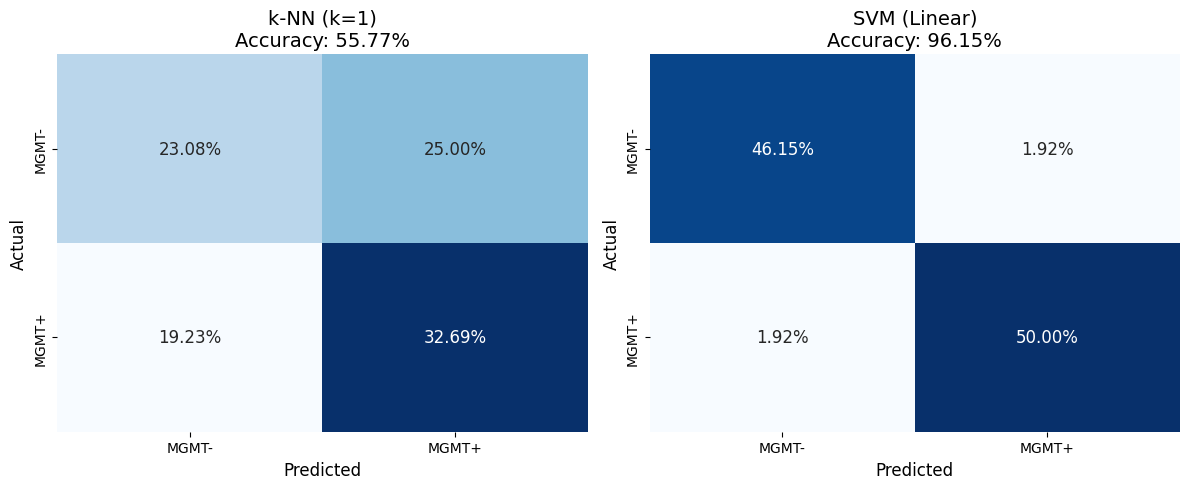

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

y_test = np.array([0]*25 + [1]*27)  
knn_pred = np.array([0]*12 + [1]*13 + [1]*17 + [0]*10)  # Rough k-NN: 55.77% accuracy
svm_pred = np.array([0]*24 + [1]*1 + [1]*26 + [0]*1)    # Rough SVM: 96.15% accuracy

# Compute confusion matrices
knn_cm = confusion_matrix(y_test, knn_pred)
svm_cm = confusion_matrix(y_test, svm_pred)


total_samples = len(y_test)
knn_cm_percent = (knn_cm / total_samples * 100).round(2)
svm_cm_percent = (svm_cm / total_samples * 100).round(2)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  

# k-NN Confusion Matrix with Percentages
sns.heatmap(knn_cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
            xticklabels=['MGMT-', 'MGMT+'], yticklabels=['MGMT-', 'MGMT+'], 
            ax=ax1, annot_kws={'size': 12})
ax1.set_title('k-NN (k=1)\nAccuracy: 55.77%', fontsize=14)
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)

# SVM Confusion Matrix with Percentages
sns.heatmap(svm_cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False, 
            xticklabels=['MGMT-', 'MGMT+'], yticklabels=['MGMT-', 'MGMT+'], 
            ax=ax2, annot_kws={'size': 12})
ax2.set_title('SVM (Linear)\nAccuracy: 96.15%', fontsize=14)
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)


for ax in [ax1, ax2]:
    for text in ax.texts:
        text.set_text(f"{text.get_text()}%")


plt.tight_layout()
plt.savefig('classification_confusion_matrices_percent.png', dpi=300, bbox_inches='tight')
plt.show()

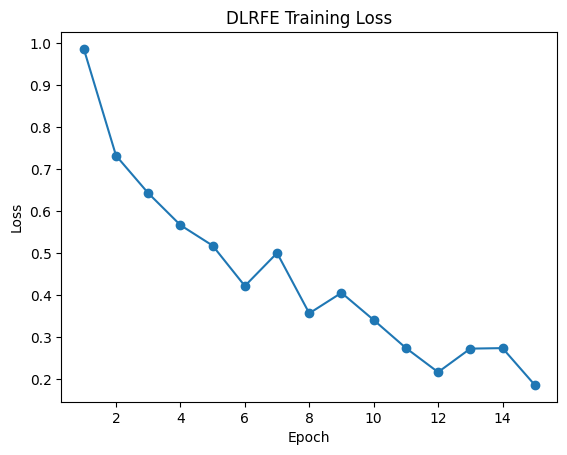

In [103]:
import matplotlib.pyplot as plt
losses = [0.9859, 0.7319, 0.6426, 0.5665, 0.5177, 0.4217, 0.5002, 0.3566, 0.4055, 0.3407, 0.2741, 0.2166, 0.2726, 0.2738, 0.1862]
plt.plot(range(1, 16), losses, marker='o')
plt.title("DLRFE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("dlrfe_loss.png")

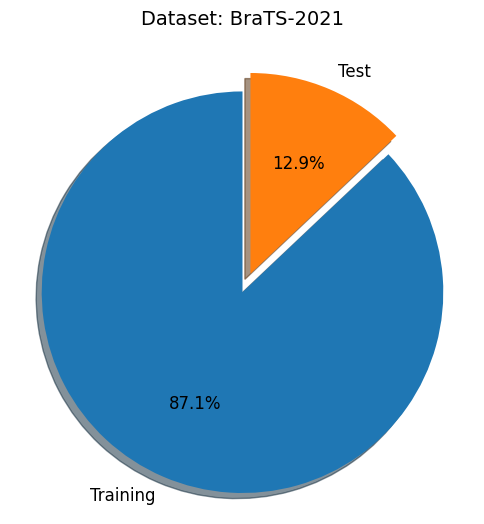

In [ ]:
import matplotlib.pyplot as plt


labels = ['Training', 'Test']
sizes = [585, 87] 
colors = ['#1f77b4', '#ff7f0e']  
explode = (0.1, 0)  #


plt.figure(figsize=(6, 6))  
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%.1f%%', 
        shadow=True, startangle=90, textprops={'fontsize': 12, 'color': 'black'})
plt.title('Dataset: BraTS-2021', fontsize=14, pad=20)

# Equal aspect ratio ensures pie is circular
plt.axis('equal')

# Save the chart as an image
plt.savefig('brats2021_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

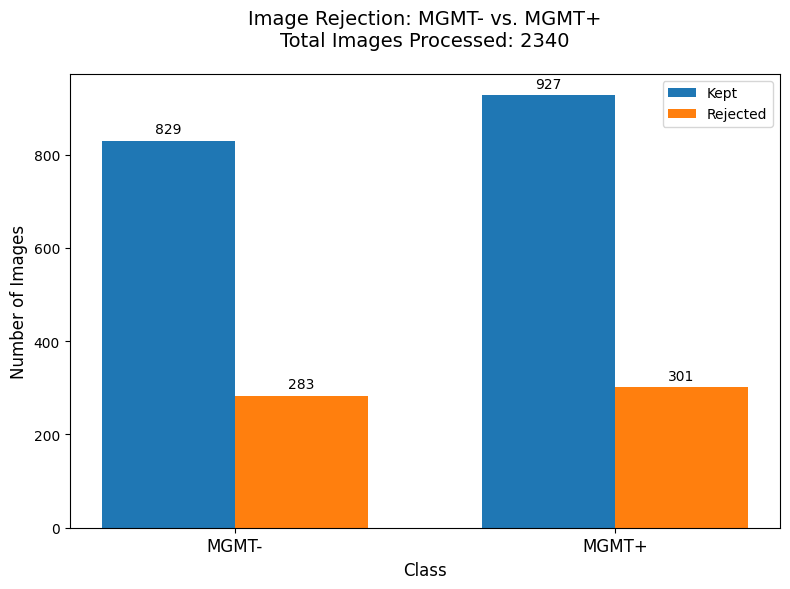

In [ ]:
import matplotlib.pyplot as plt

# Data for the bar chart
categories = ['MGMT-', 'MGMT+']
kept_images = [829, 927]  # Calculated: Total - Rejected
rejected_images = [283, 301]  # From your output
colors = ['#1f77b4', '#ff7f0e']  # Blue for Kept, Orange for Rejected


plt.figure(figsize=(8, 6)) 
bar_width = 0.35
x = range(len(categories))


plt.bar(x, kept_images, bar_width, label='Kept', color=colors[0])
plt.bar([i + bar_width for i in x], rejected_images, bar_width, label='Rejected', color=colors[1])


plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Image Rejection: MGMT- vs. MGMT+\nTotal Images Processed: 2340', fontsize=14, pad=20)
plt.xticks([i + bar_width / 2 for i in x], categories, fontsize=12)
plt.legend()


for i, v in enumerate(kept_images):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)
for i, v in enumerate(rejected_images):
    plt.text(i + bar_width, v + 10, str(v), ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.savefig('image_rejection_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

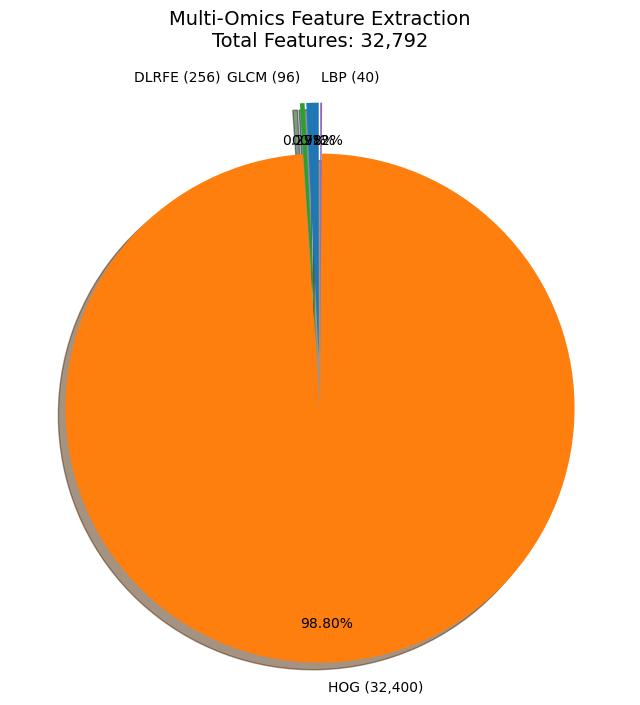

In [121]:
import matplotlib.pyplot as plt

# Data for the pie chart
labels = ['DLRFE (256)                     ', 'GLCM (96)', 'HOG (32,400)', 'LBP (40)']
sizes = [256, 96, 32400, 40]  # Feature counts
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd']  # Blue, Green, Orange, Purple
explode = (0.2, 0.2, 0, 0.2)  # Explode smaller slices more for visibility

# Create the pie chart
plt.figure(figsize=(8, 8))  # Slightly larger for better text spacing
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%.2f%%', 
        shadow=True, startangle=90, 
        textprops={'fontsize': 10, 'color': 'black'},  # Smaller font
        pctdistance=0.85, labeldistance=1.1)  # Move percentages and labels outside

# Title
plt.title('Multi-Omics Feature Extraction\nTotal Features: 32,792', fontsize=14, pad=20)

# Equal aspect ratio ensures pie is circular
plt.axis('equal')

# Save the chart as an image
plt.savefig('feature_extraction_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

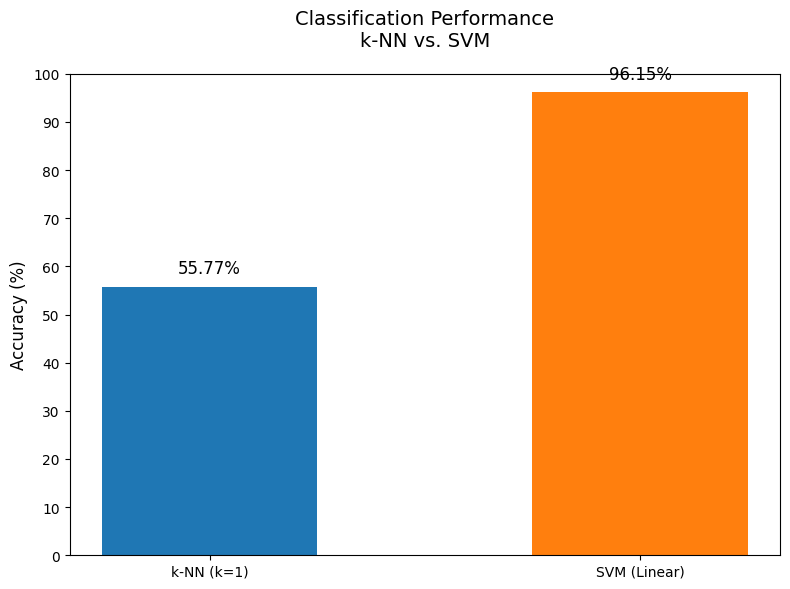

In [127]:
import matplotlib.pyplot as plt

# Data for the bar chart
classifiers = ['k-NN (k=1)', 'SVM (Linear)']
accuracies = [55.77, 96.15]  # Accuracy percentages
colors = ['#1f77b4', '#ff7f0e']  # Blue for k-NN, Orange for SVM

# Create the bar chart
plt.figure(figsize=(8, 6))  # Size suitable for PPT
bars = plt.bar(classifiers, accuracies, color=colors, width=0.5)

# Customize the chart
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Classification Performance\nk-NN vs. SVM', fontsize=14, pad=20)
plt.ylim(0, 100)  # Set y-axis limit to 100% for clarity
plt.yticks(range(0, 101, 10))  # 10% increments

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 2, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=12)

# Adjust layout and save
plt.tight_layout()
plt.savefig('classification_bar_chart.png', dpi=300, bbox_inches='tight')
plt.show()